# Global Sensitivity analysis

To investigate the uncertainty in and the influence of the choice of parameter values we conducted a global sensitivity analysis (see for example Saltelli et al., 2005).Although, there are several methods of global sensitivity analysis suited for different models, we chose a Latin Hypercube (LH) sampling approach coupled to the calculation of the Partial Rank Correlation Coefficient (PRCC) as described in Marino et al., 2008. We chose this method for its robustness and simplicity. For the LH sampling we used the Python package pyDOE version 0.3.8. For each parameter, the LH sample was transformed to a suitable uniform distribution. The combined parameter distribution was sampled 1000 times and the model was simulated with the new parameters. Using the steady-state output of the compounds and the fluxes the PRCC for each parameter was calculated. 

## References
Saltelli, A., Ratto, M., Tarantola, S., and Campolongo, F. (2005). Sensitivity analysis for chemical models.352Chemical reviews 105, 2811–2828

Marino, S., Hogue, I. B., Ray, C. J., and Kirschner, D. E. (2008). A methodology for performing global340uncertainty and sensitivity analysis in systems biology.Journal of theoretical biology 254, 178–196

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modelbase
import multiprocessing
import scipy
import seaborn as sns
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from sklearn import linear_model
from pyDOE import lhs
from copy import deepcopy

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture

cd analyses/

# Function definitions

In [5]:
def PRCC(design_matrix,output_matrix,output_variable):
    r"""calculate Partial Rank Correlation Coefficient.

    Returns pandas.DataFrame object

    Parameters
    ----------
    design_matrix : pandas.DataFrame object
        LHS design matrix. Transformed to desired distribution
        
    output_matrix: pandas.DataFrame object
        output of model after changing parameters according to the design matrix
      

    Returns
    -------
    PRCC_main_dict: dict object
        dictionary containing PRCC for compounds
     
    """
    PCRR_main_dict = {}
    d_names = design_matrix.columns
    design_matrix_ranked = design_matrix.rank()
    output_matrix_ranked = output_matrix.rank()
    for i in d_names:
        PCRR_dict = {}
        X = design_matrix_ranked.drop(i,axis=1)
        y = design_matrix_ranked[i]
        y2 = output_matrix_ranked[output_variable]
        
        lm = linear_model.LinearRegression()
        model = lm.fit(X,y)
        prediction = model.predict(X)
        residual = (y - prediction)
        
        lm = linear_model.LinearRegression()
        model = lm.fit(X,y2)
        prediction = model.predict(X)
        residual2 = (y2 - prediction)
        
        r,p_val = scipy.stats.pearsonr(residual2,residual)
        PCRR_dict['r'] = r
        PCRR_dict['p_val'] = p_val
        PCRR_dict['residual_design'] = residual
        PCRR_dict['residual_out'] = residual2
        PCRR_main_dict[i] = PCRR_dict
    return PCRR_main_dict


def plot_PCRR(out,figsize=(15,8)):
    r"""Plot LHS-PCRR results
    """
    fig,ax = plt.subplots(figsize=figsize)
    df = pd.DataFrame(out).loc[['r','p_val']]
    df.loc['color'] = 1 
    mask = df.loc['p_val'] < 0.05
    df.loc['color'][mask] = 0
    colors = {0: 'lime', 1: 'blue'}
    df.loc['r'].plot(kind='bar', color=[colors[i] for i in df.loc['color']], ax=ax)
    ax.axhline(c='k',linewidth=1)
    ax.set_ylim([-1,1])
    ax.set_ylabel('PRCC')
    fig.tight_layout()
    return fig,ax


def plot_residuals(out,figsize=(10,10),name='NAME',save=False, reverse=False):
    r"""Plot LHS-PCRR results. Plots scatterplot of residuals
    """
    for i in out:
        fig,ax = plt.subplots(figsize=(15,8))
        if reverse:
            ax.scatter(out[i]['residual_out'],out[i]['residual_design'])
        else:
            ax.scatter(out[i]['residual_design'],out[i]['residual_out'])
        ax.set_title(i)
        ax.set_xlabel('design residual')
        ax.set_ylabel('output residual')
        if save:
            fig.savefig('GSA_output/img/ResidualScatter_' + i + '_' + name + '.png')
            plt.show()
        else:
            plt.show()

# Initialise model

In [6]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [7]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

s = Simulator(get_model())
s.initialise(y0)

## Latin hyperspace sampling

In [8]:
parameter_names = ['k_ex_atp','k_ex_nadph',
                   
                   'thioredoxin_tot', 'k_fd_tr_reductase',
                   
                   'e_cbb_tot','k_e_cbb_activation','k_e_cbb_relaxation',
                   
                   'kMehler','kcyc',
                  
                   'V1_base', 'V6_base',
                   
                   'V9_base','kcat_DHAR',
                   
                   'kcatMDAR']

parameter_names_translated = ['k_ex_atp','k_ex_nadph',
                   
                   'thioredoxin_tot', 'k_fd_tr_reductase',
                   
                   'e_cbb_tot','k_e_cbb_activation','k_e_cbb_relaxation',
                   
                   'kMehler','kcyc',
                             
                   'kRuBisCO','kFBPase',
                              
                   'kSBPase','kDHAR',
                    
                   'kMDAR']

### uniform

In [9]:


design = lhs(len(parameter_names), samples=1000)

loc = [0, 0, 
       0, 0,
       0, 0, 0,
       0, 0,
       0, 0,
       0, 0,
       0]

scale = [1, 1,
         10, 10,
         60, 10, 10,
         10, 10,
         30, 20,
         3, 1400,
         3000]

         

#scale design
for i in range(len(parameter_names)):
    design[:, i] = scipy.stats.distributions.uniform(loc=loc[i], scale=scale[i]).ppf(design[:, i])

design_matrix = []
for j in  range(len(design)):
    design_matrix.append(dict(zip(parameter_names,design[j,:])))
    
design_matrix = pd.DataFrame(design_matrix)

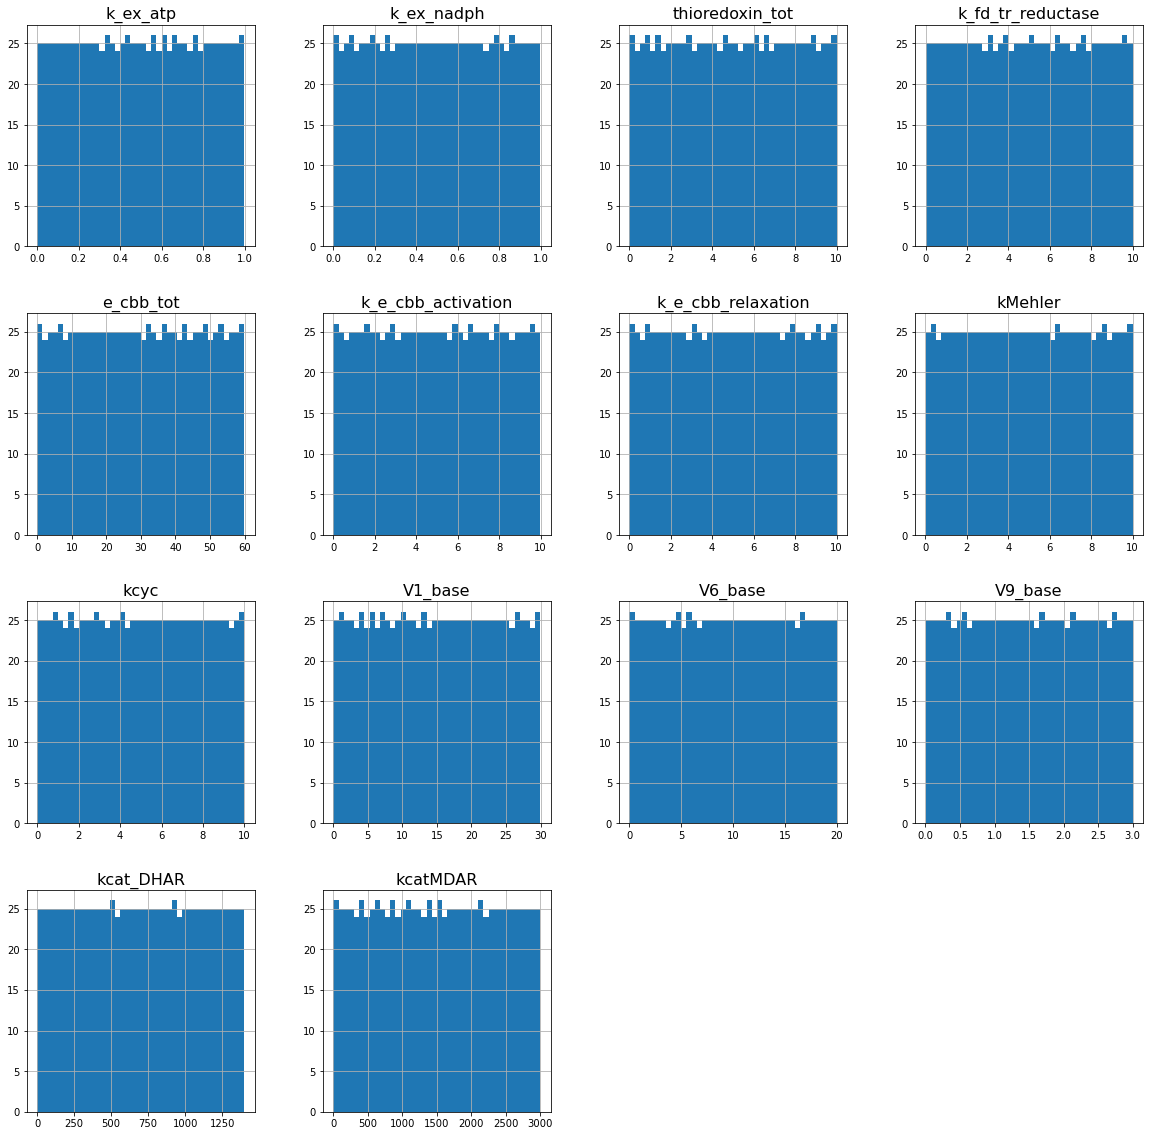

In [10]:
#check distributions
fig,ax = plt.subplots(figsize=(20,20))
design_matrix.hist(bins=40,ax=ax)
plt.show()

### lognormal

In [11]:
# design = lhs(len(parameter_names), samples=1000)

# #only for lognormal scale=0.5
# mean = [0.2,   0.2,
#         1,     1,
#         6,     1,  0.1,
#         1,     1]

# #scale design
# for i in range(len(parameter_names)):
#     design[:, i] = scipy.stats.distributions.lognorm(s=0.5, loc=0, scale=mean[i]).ppf(design[:, i])
#     print(np.median(design[:,i]))
    
# design_matrix = []
# for j in  range(len(design)):
#     design_matrix.append(dict(zip(parameter_names,design[j,:])))
    
# design_matrix = pd.DataFrame(design_matrix)

In [12]:
#check distributions
# fig,ax = plt.subplots(figsize=(20,20))
# design_matrix.hist(bins=40,ax=ax)
# plt.show()

# Global Sensitivity Analysis: Partial Rank Correlation Coeffecient

In [13]:
def gsa(i):
    s = Simulator(get_model())
    s.update_parameter('pfd',1000)
    s.initialise(y0)
    print(i)
    p_dict = design_matrix.iloc[i].to_dict()
    s.update_parameters(p_dict)
    try:
        s.simulate_to_steady_state()
        return p_dict,s.get_full_results_dict()|s.get_fluxes_dict()
    except:
        pass
    
def gsa_v2(i):
    s = Simulator(get_model())
    s.update_parameter('pfd',100)
    s.initialise(y0)
    print(i)
    p_dict = design_matrix.iloc[i].to_dict()
    s.update_parameters(p_dict)
    #s.simulate_to_steady_state(integrator_kwargs={})
    try:
        s.simulate_to_steady_state({'atol':1e-8,'minh':1e-4})
        return p_dict,s.get_full_results_dict()|s.get_fluxes_dict()
    except:
        pass
    
pool = multiprocessing.Pool(multiprocessing.cpu_count())
output = pool.map(gsa,range(len(design)))
pool.close()

631890126



64
1
127
190
128
65
2
191
66
129
3
192
130
67
4
193
131
5
68
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning]194
 b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0499982 and h = 2.97621e-18 are such that t + h = t on the next ste

74
11
199
75


132
200
76
12
133
201
77
13
134
202
78
14
135
203
79
15
80
136
204
16
205
81
137
138
17
82
206
18
139
83
207
19
140
208
84
20
141
209
85
21
142
210
86
22
143
211
87
23
212
144
88
24
145
213
89
146
25
214
90
26
147
215
91
27
148
216
92
28
217
149
29
93
218
150
30
94
219
31
151
220
95
32
221
152
96
33
222
153
97
34
223
154
224
98
35
225
155
99
36
226
100
156
37
227
38
101
157
228
39
158
102
40
229
159
41
103
230
160
231
42
104
161
43
232
162
44
163
105
233
45
164
46
106
234
165
47
107
235
166
108
48
236
167
237
109
49
168
238
50
110
169
51
239
111
170
52
240
112
53
171
113
241
54
172
242
114
55
173
115243

56
174
244
116
57
175
245
117
58
176
118
59
246
119
177
60
247


178
120
61
179
248
121
62
249
180
122
252
250
181
123
251
253
182
124
183
315
254
125
184
316
255
185
378
256
317
186
379
257
187
318
380
188
258
319
381
441
259
320
382


321
442
260
383
322
261
443
384
262
444
323
385
263
445
324
264
386
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0524569 and h = 2.95321e-18 are such that t + h = t on the next step. The sol

676
731
616
677


547
617
732
678
548
618
733
679
734
549
619
680
735
620
550
681
621
551
736
682
622
737
552
683
623
738
684
553
624
739
685
554
625
686
740
555
626
687
741
742
556
688
627
557
743
689
628
558
744
690
629
745
559
691
746
756
560
692
747
757
561
819
758
562
748
820
759
563
749
821
760
564
750
822
761
565
751
823
762
566
752
824
882
763
753
825
883
764
754
826
884
765
755
827
885
766
828
945
886
767
829
887
946
768
830
888
769
947
770
889
831
948
771
890
949
832
772
891
950
833
773
951
834
892
835
952
774
893
775
836
953
894
837
776
954
895
838
777
955
896
778
839
956
897
779
840
957
898
780
841
958
899
781
842
959
782
900
[CVode Warning] b'Internal t = 0.118506 and h = 6.55345e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.118506 and h = 6.55345e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.118506 and h = 6.55345e-18 are such that t + h = t on the next step

787
966
906
788


843
907
967
789
844
908
790
968
845
909
969
791
846
970
910
792
847
911
971
793
848


912
794
972
849
913
850
914
973
795
851
915
974
796
852
916
797
853
975
917
854
798
976
918
799
977
919
855
800
856
978
920
857
801
979
858
921
980
802
922
859
981
803
923
860
982
804
924
983
861
805
925
806
984
862
926
985
863
807
927
864
986
808
928
987
809
865
929
866
810
988
930
867
989
931
811
868
990
812
932
869
991
933
813
[CVode Warning] b'Internal t = 0.0547141 and h = 2.94341e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0547141 and h = 2.94341e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0547141 and h = 2.94341e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0547141 and h = 2.94341e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.0547141 and h = 2.94341e-18 are such that t + h = t on the next step. The solver will c

In [14]:
output = [x for x in output if x is not None]
design_out_matrix, output_matrix = zip(*output)
output_matrix = pd.DataFrame(output_matrix).astype(float)
design_out_matrix = pd.DataFrame(design_out_matrix)
final_df = pd.concat([design_out_matrix,output_matrix],axis=1)

final_df.to_csv('GSA.csv')
output_matrix.to_csv('GSA_output_matrix.csv')
design_out_matrix.to_csv('GSA_design_out_matrix.csv')

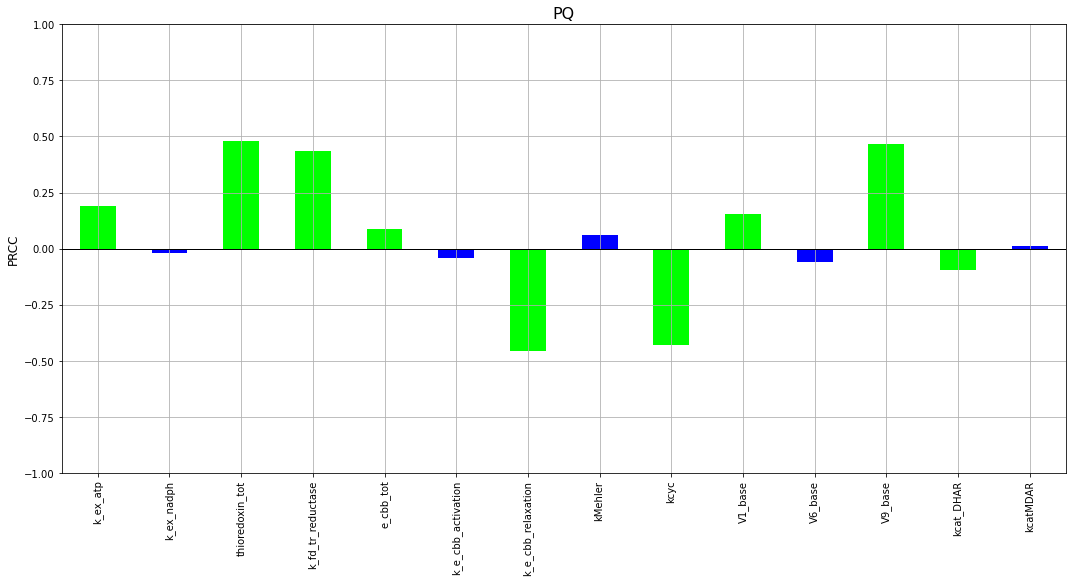

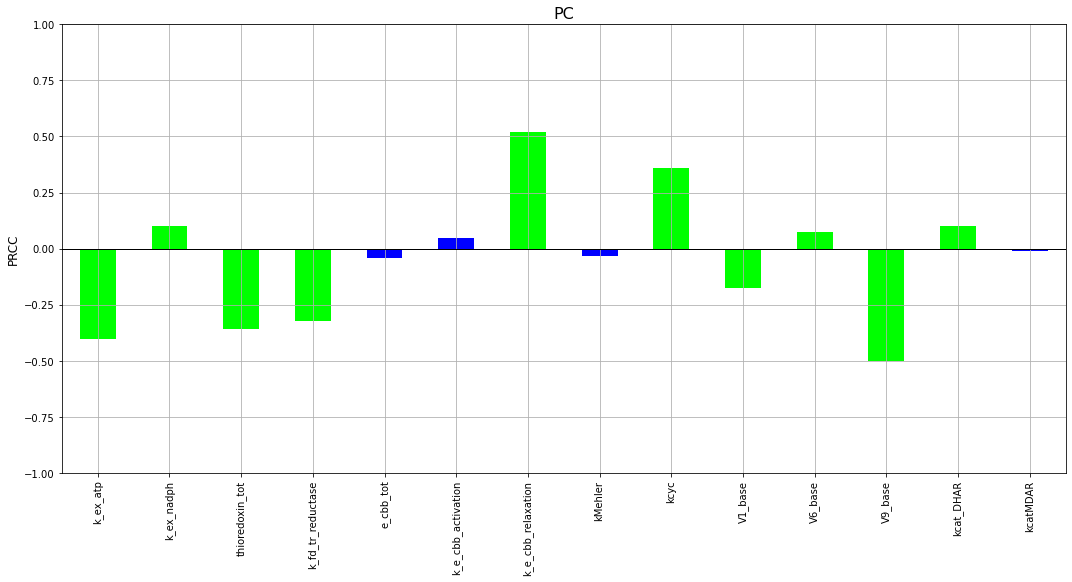

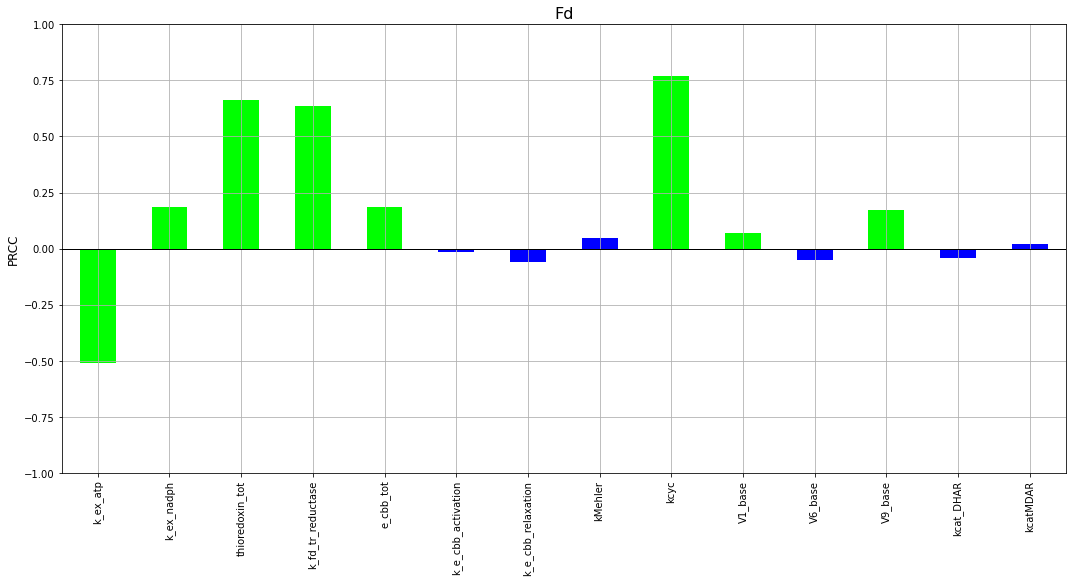

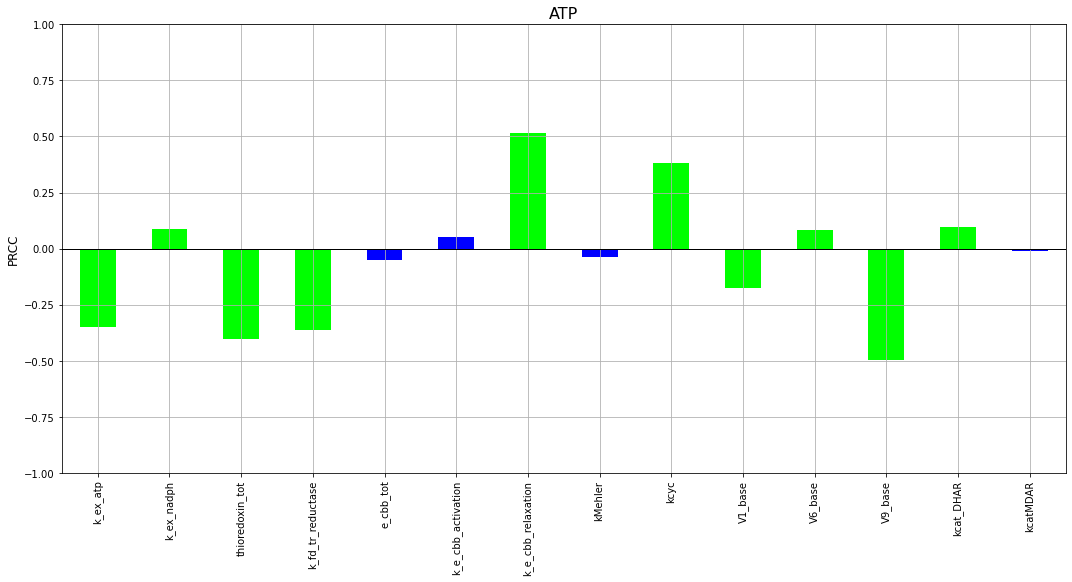

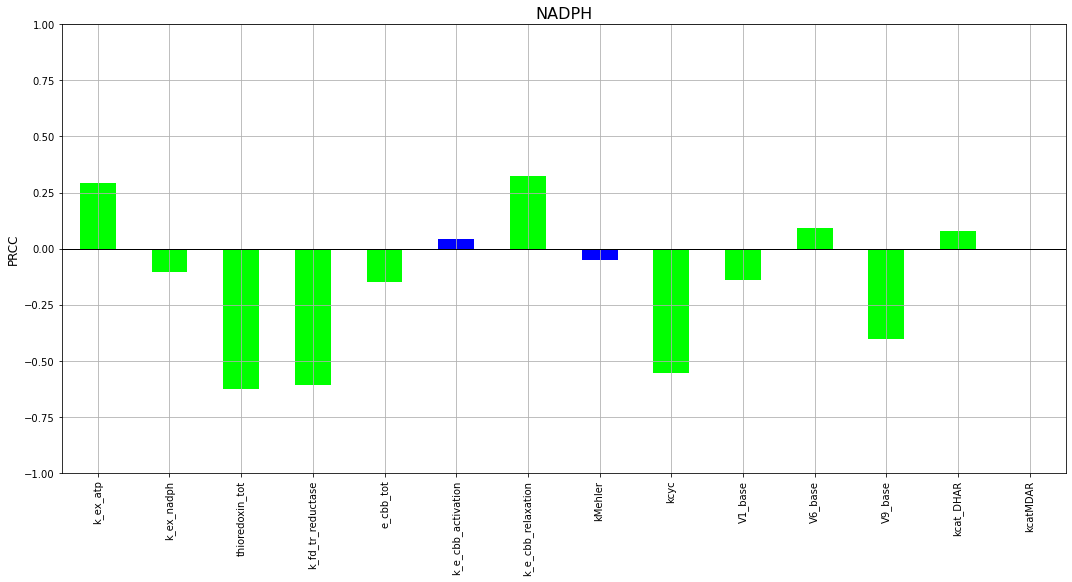

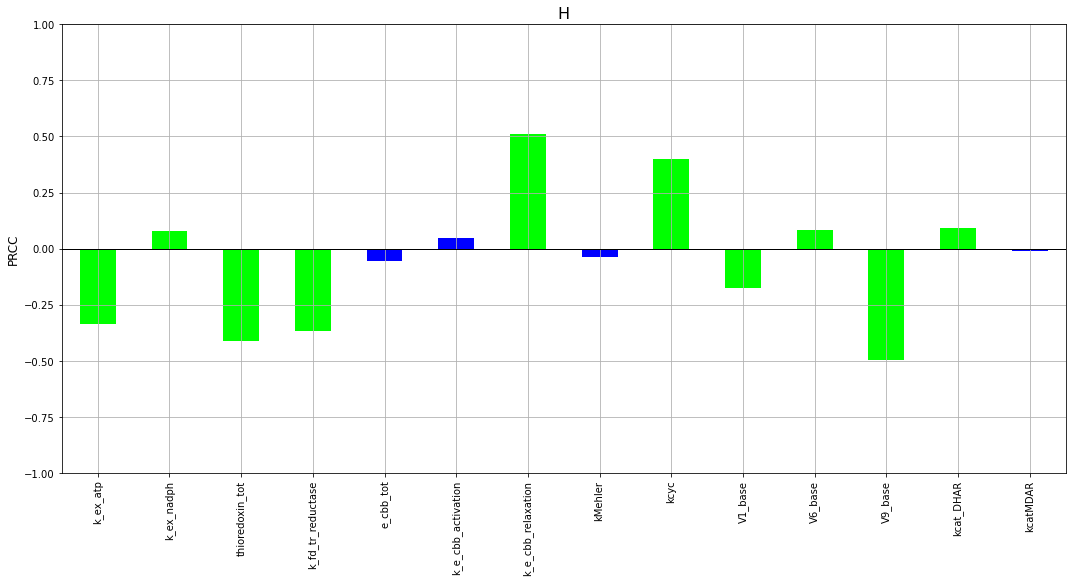

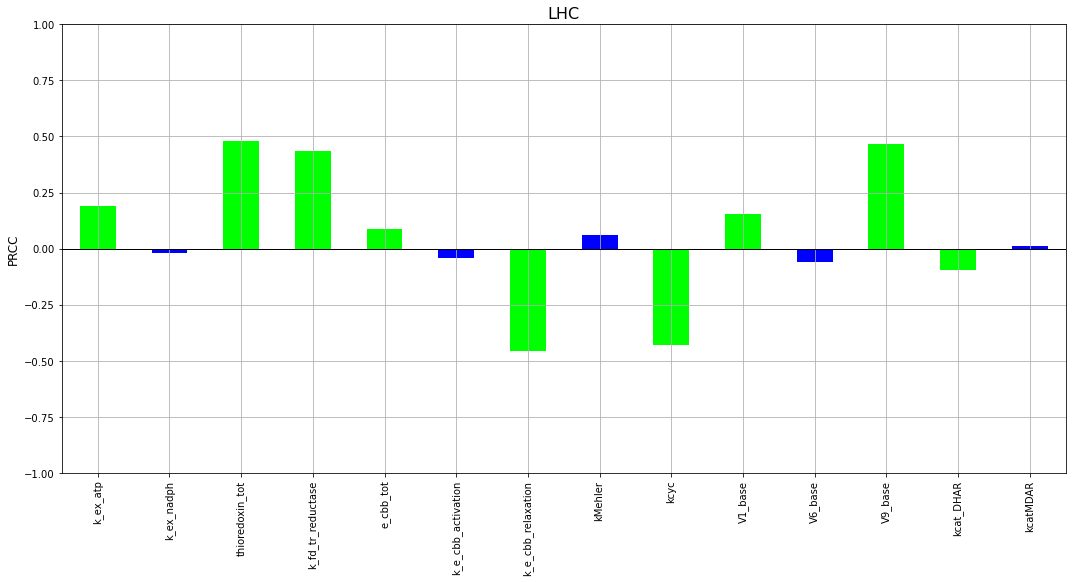

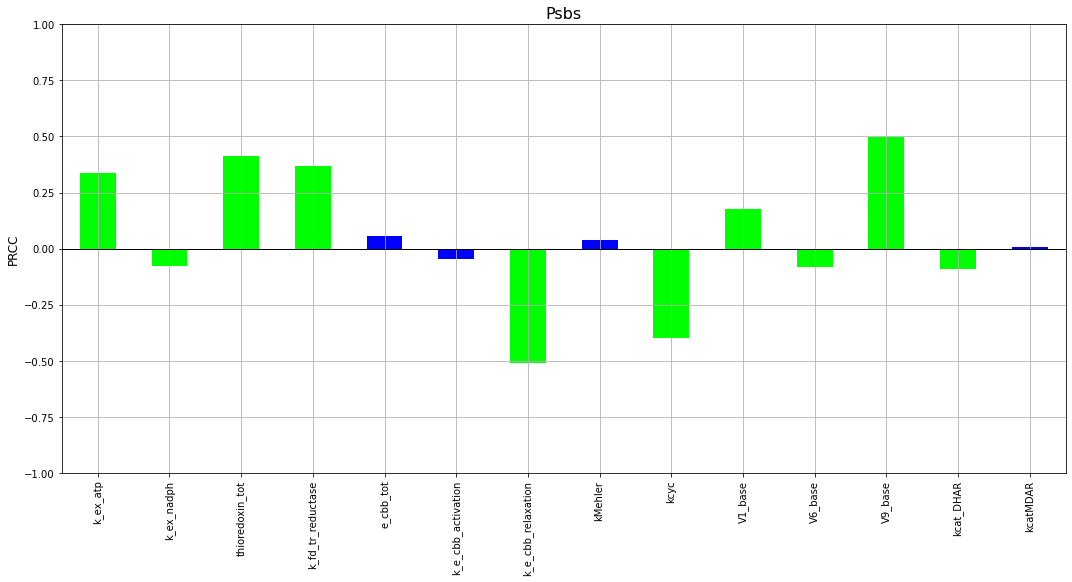

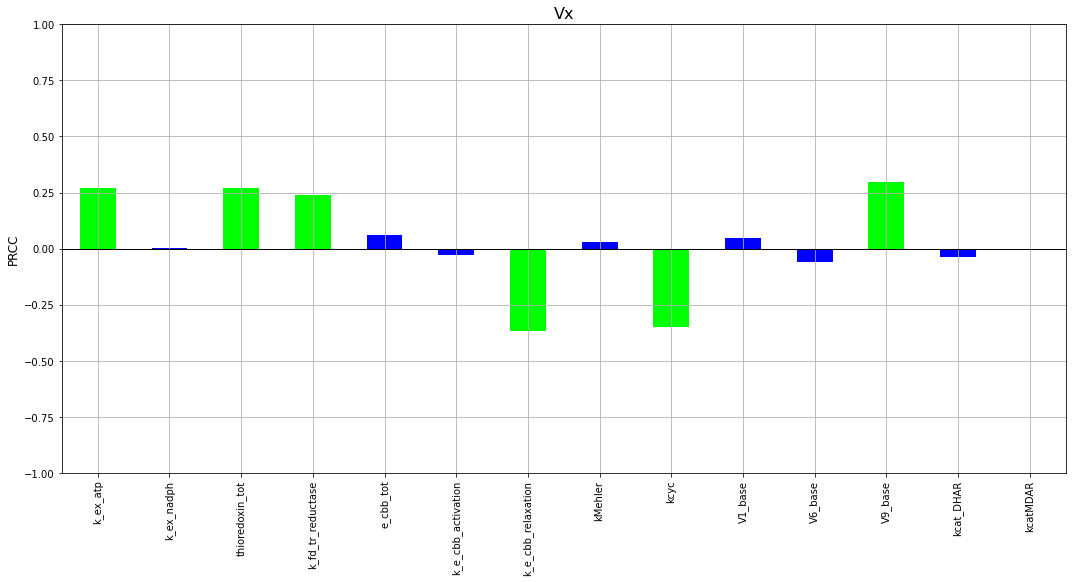

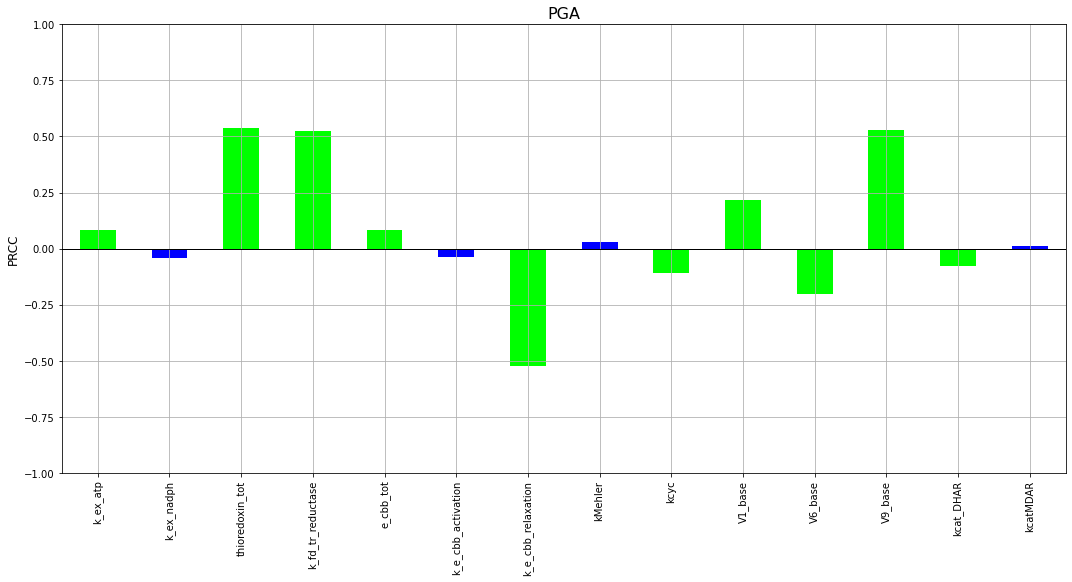

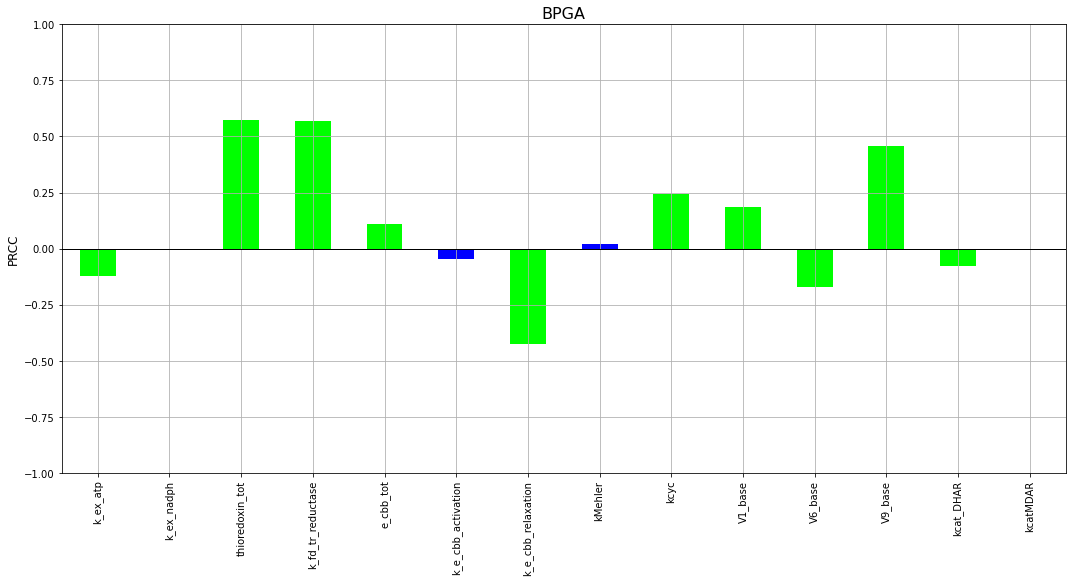

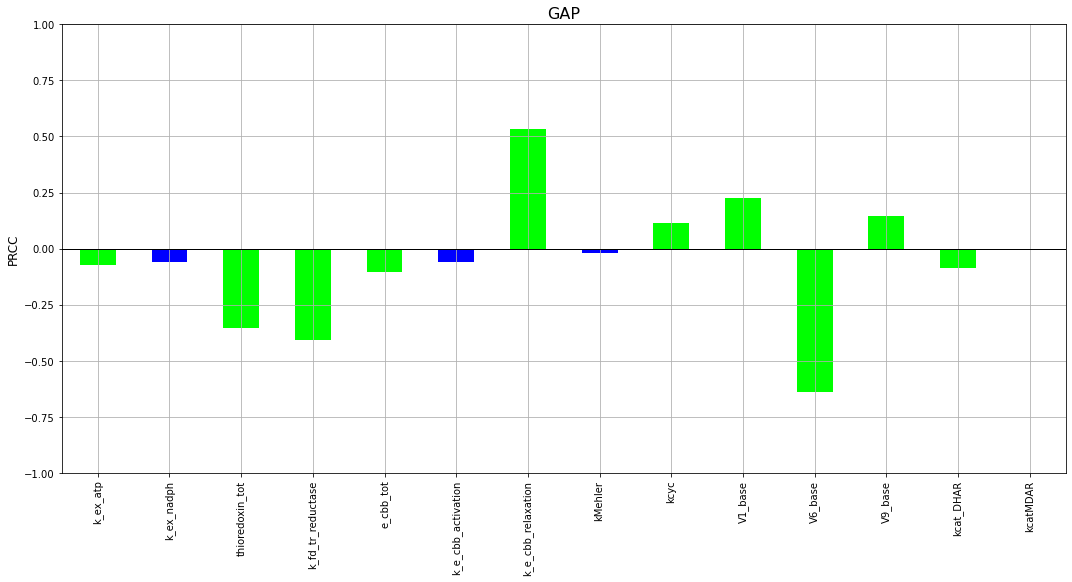

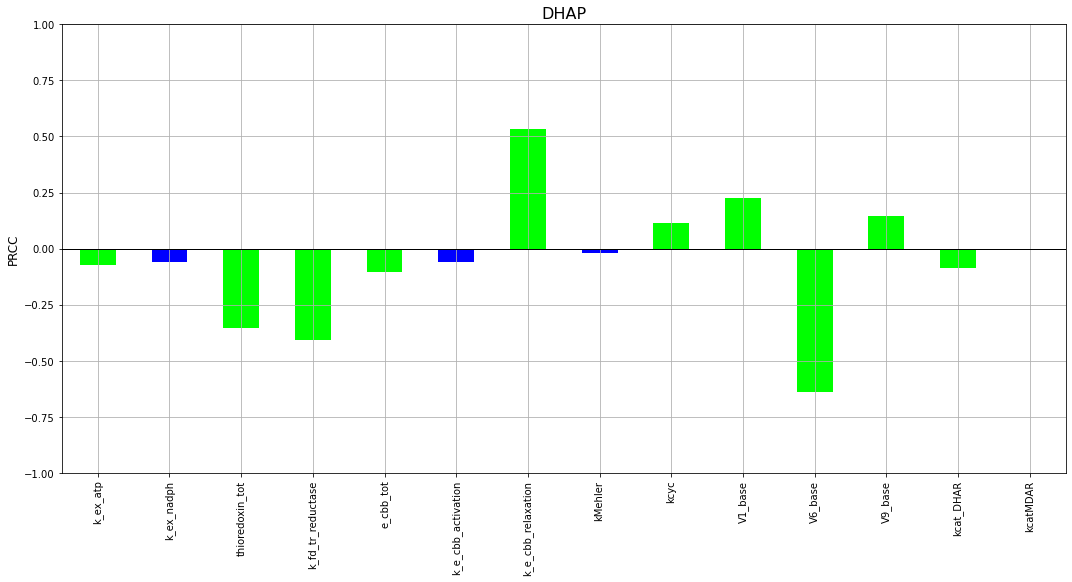

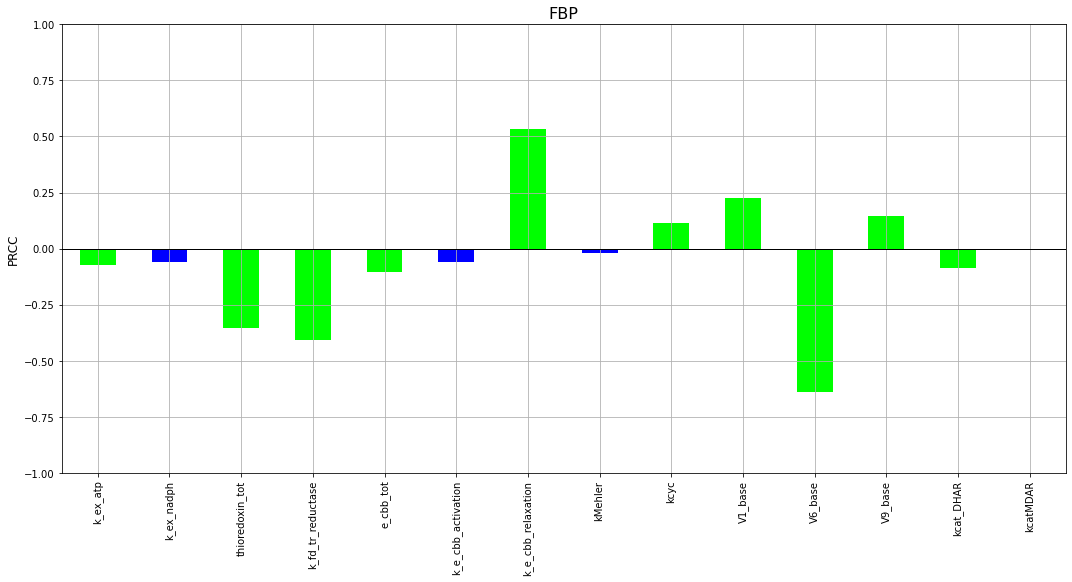

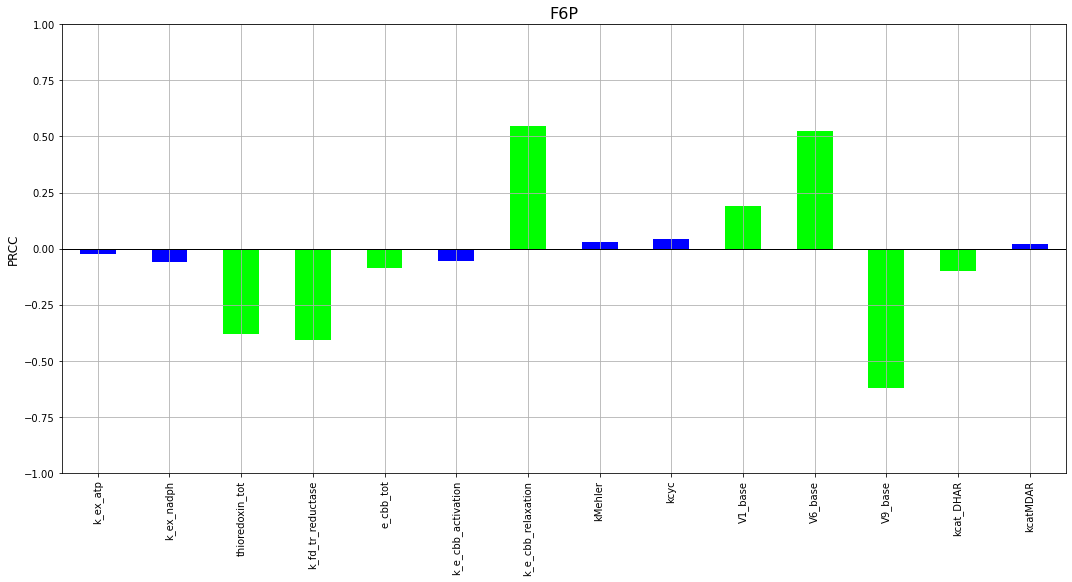

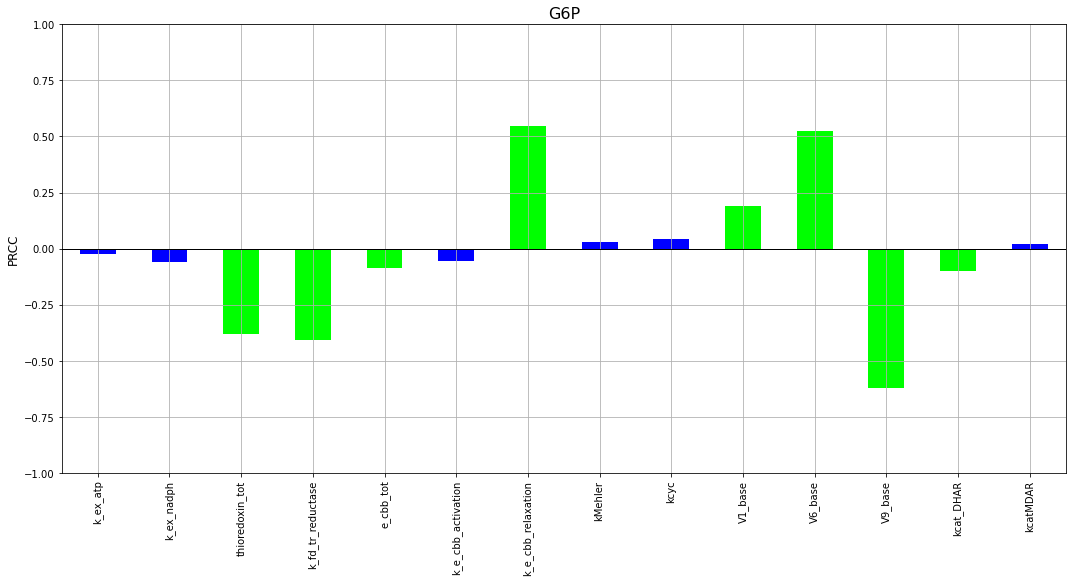

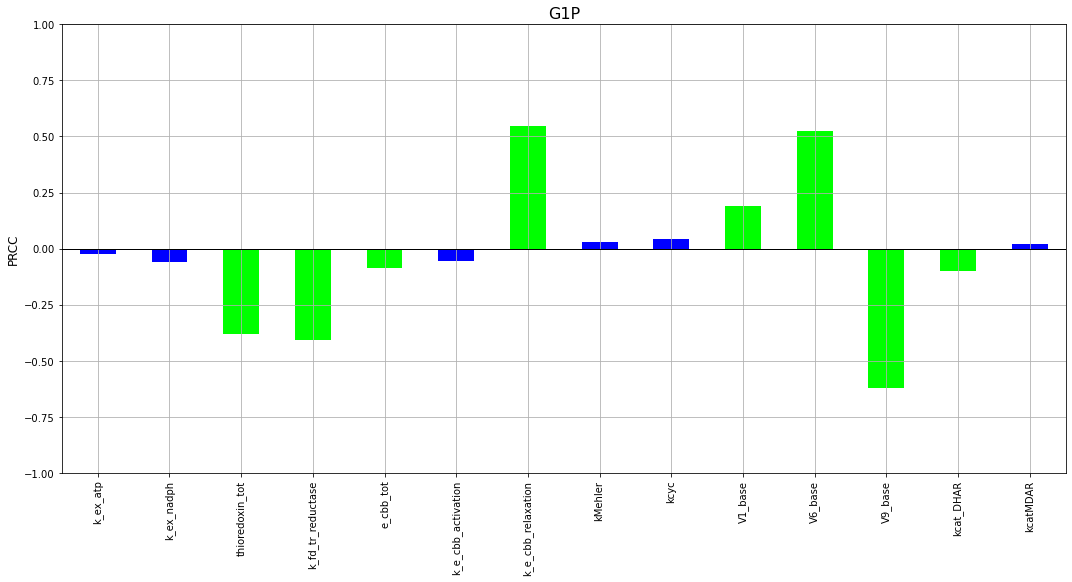

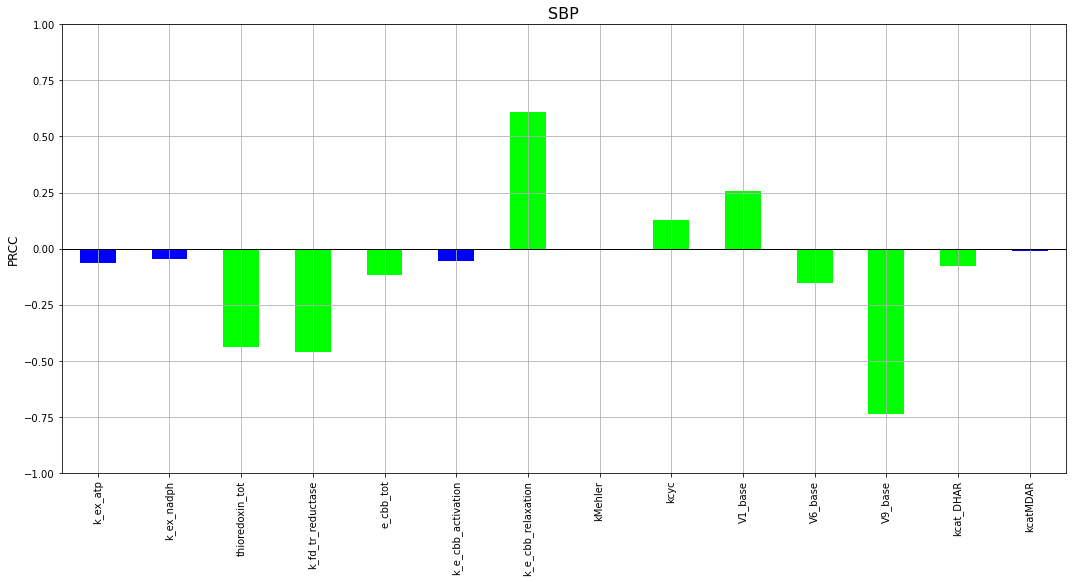

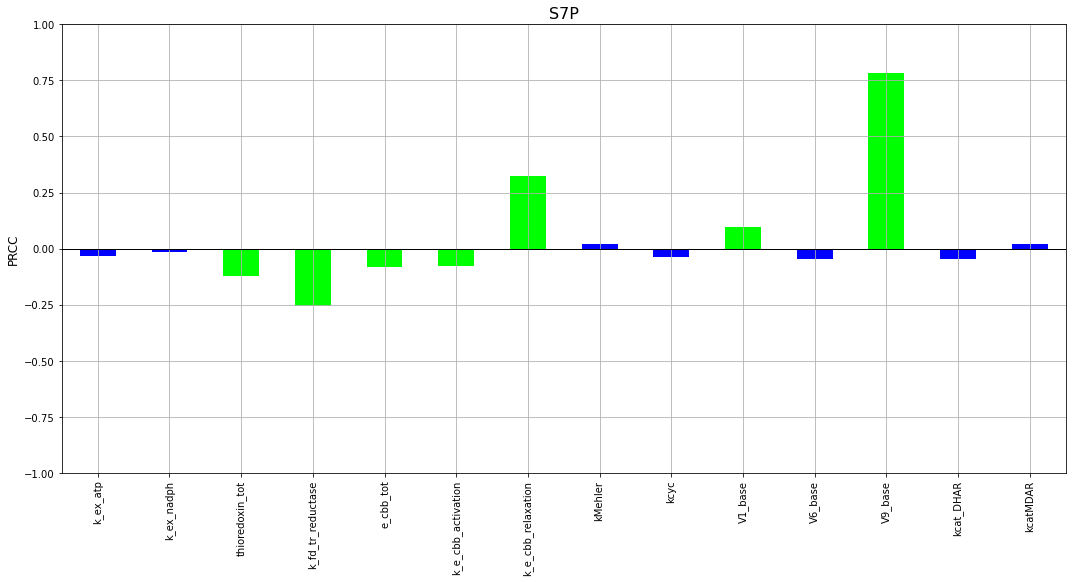

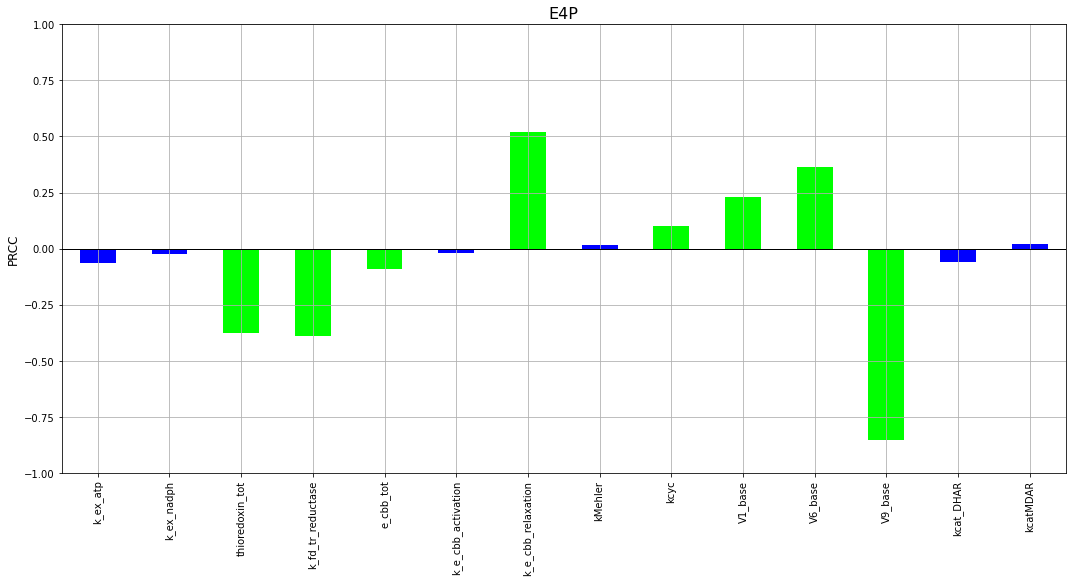

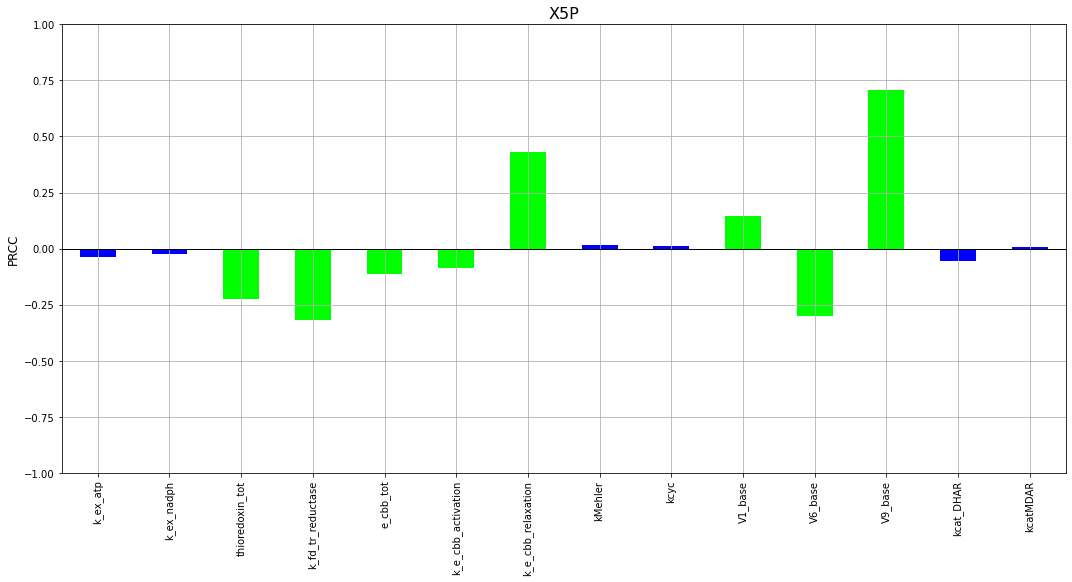

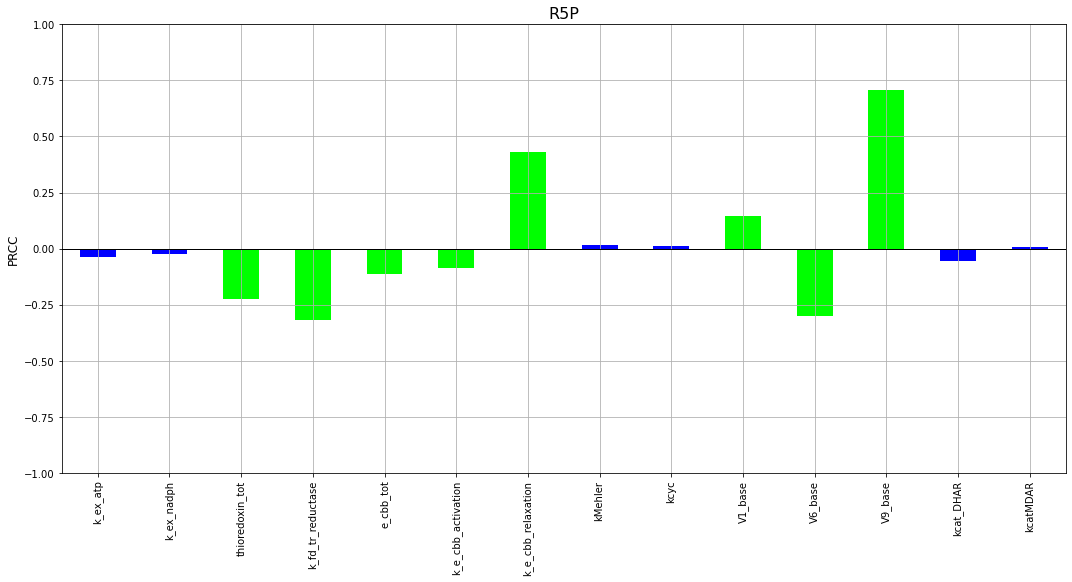

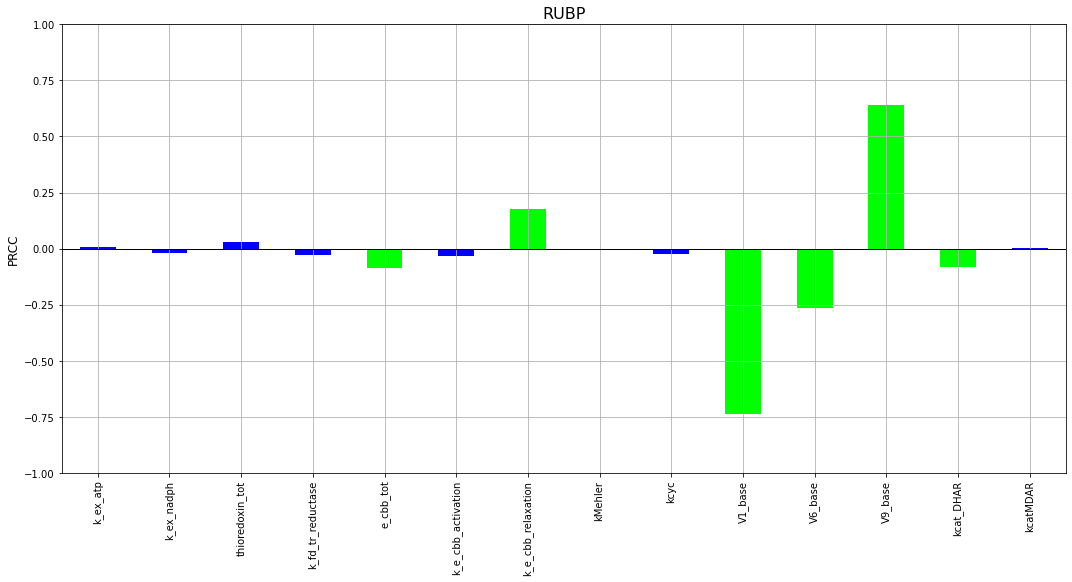

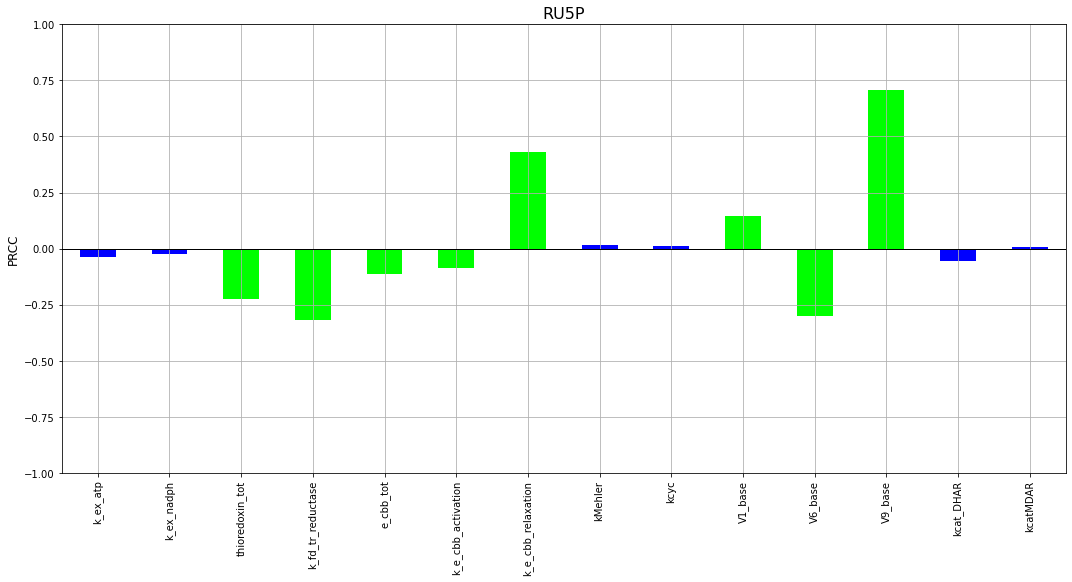

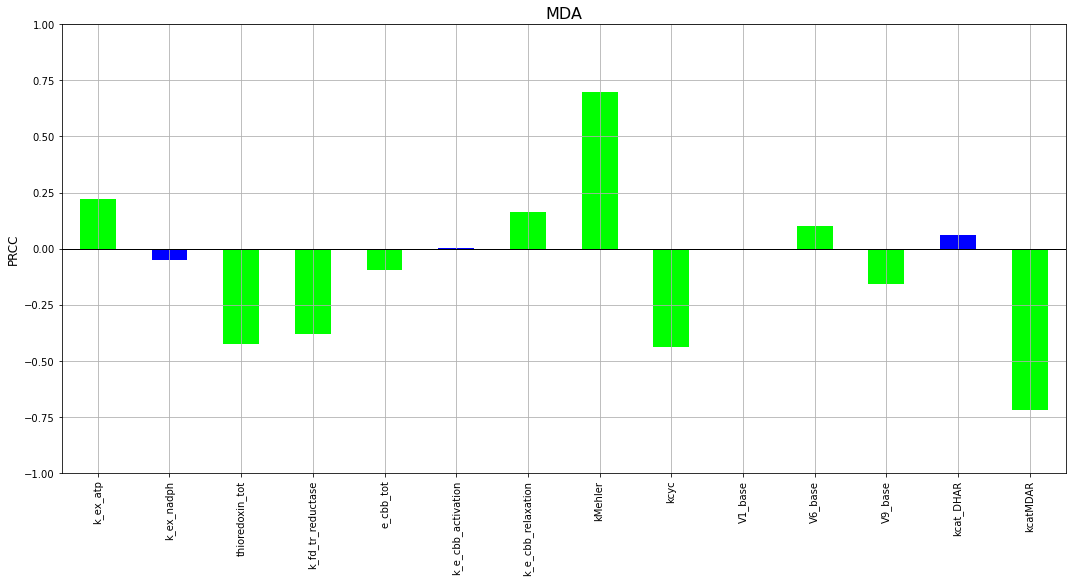

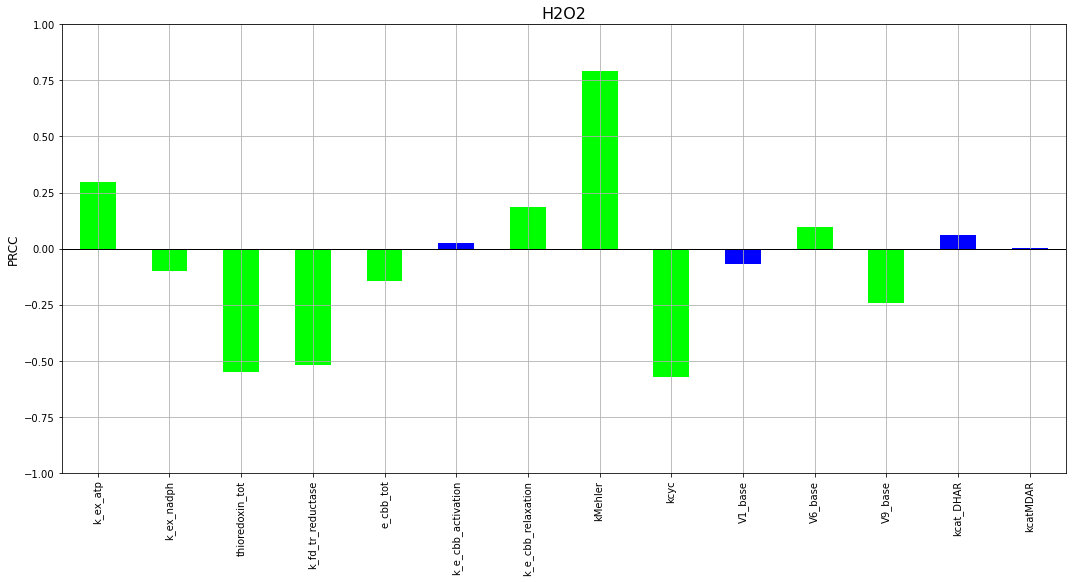

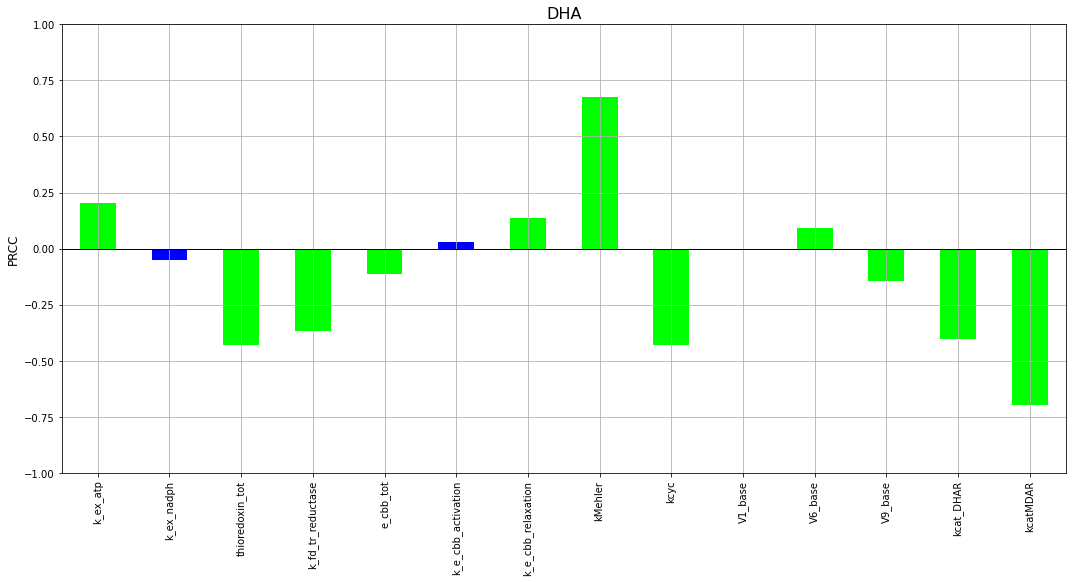

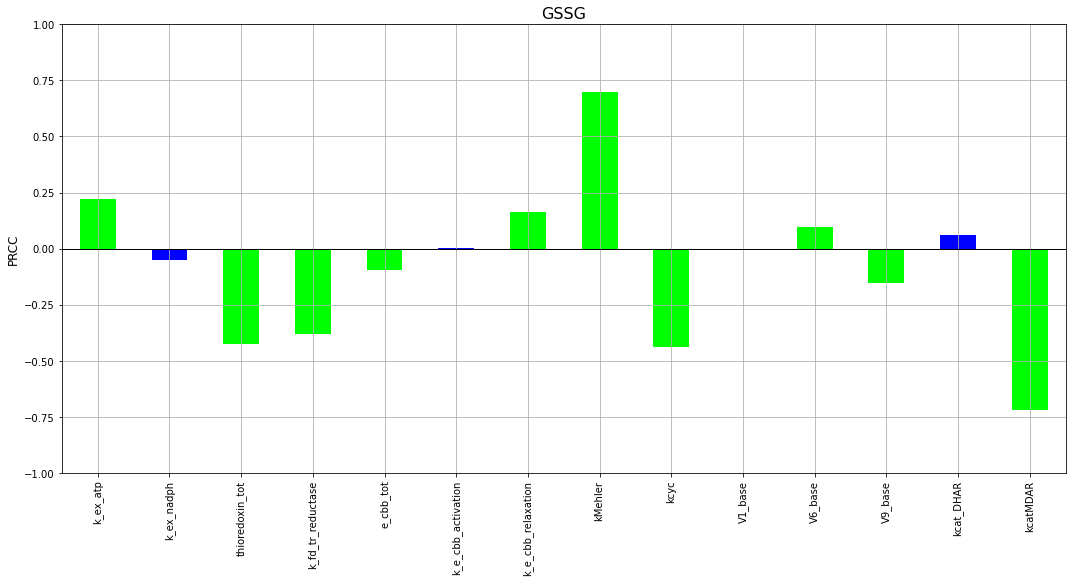

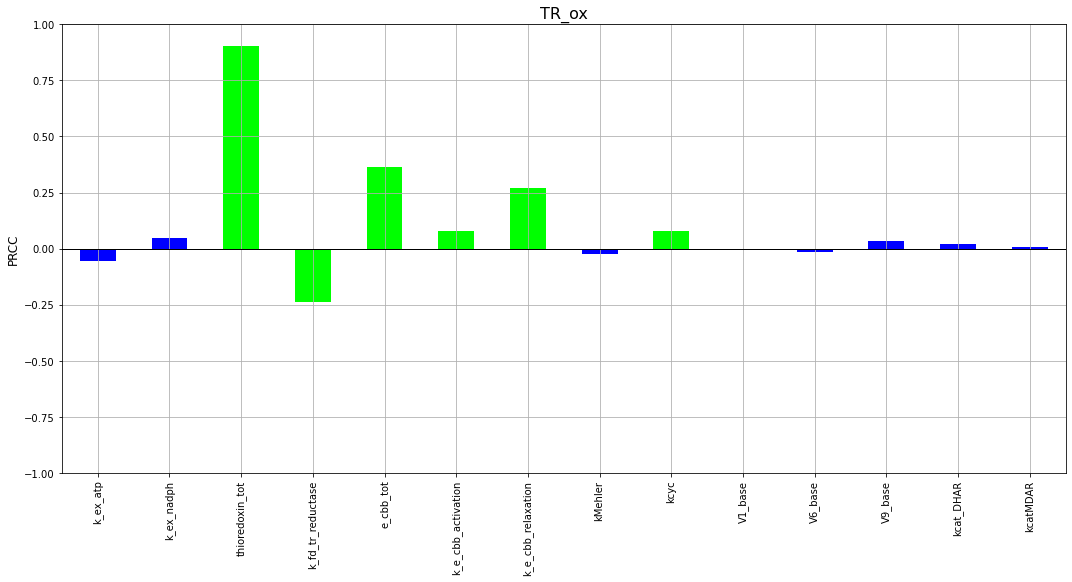

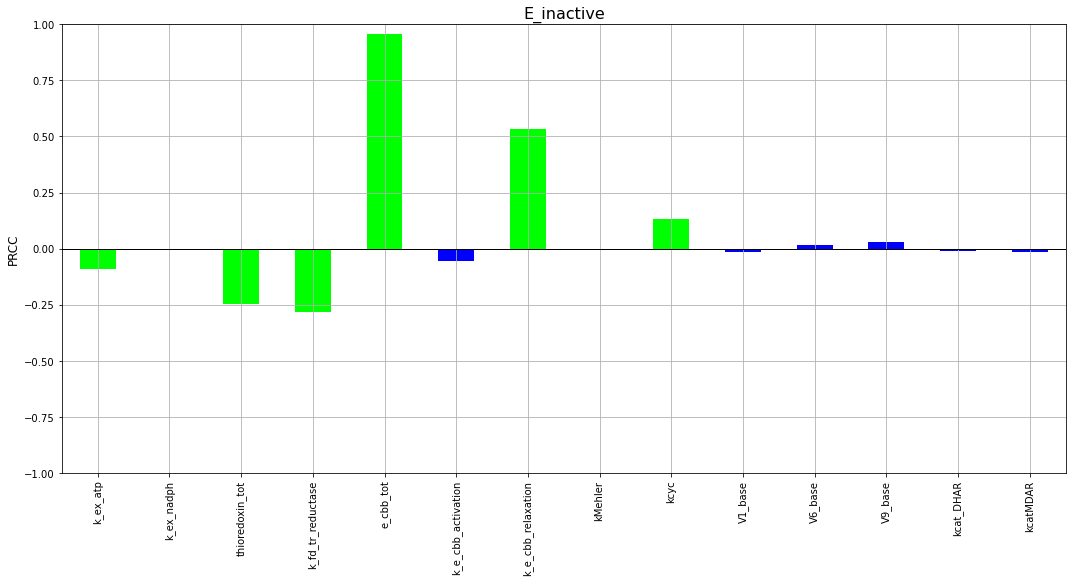

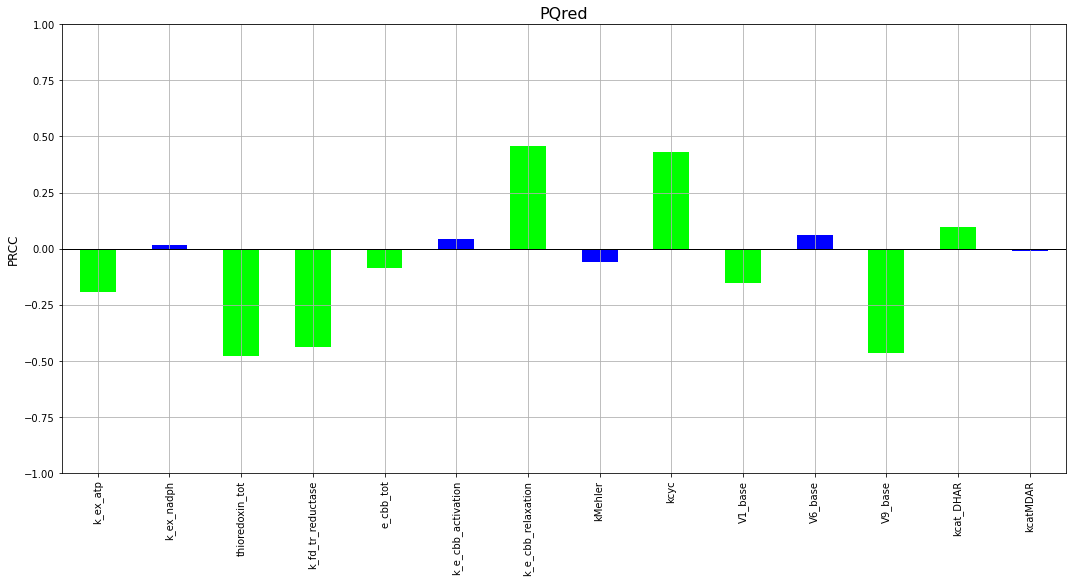

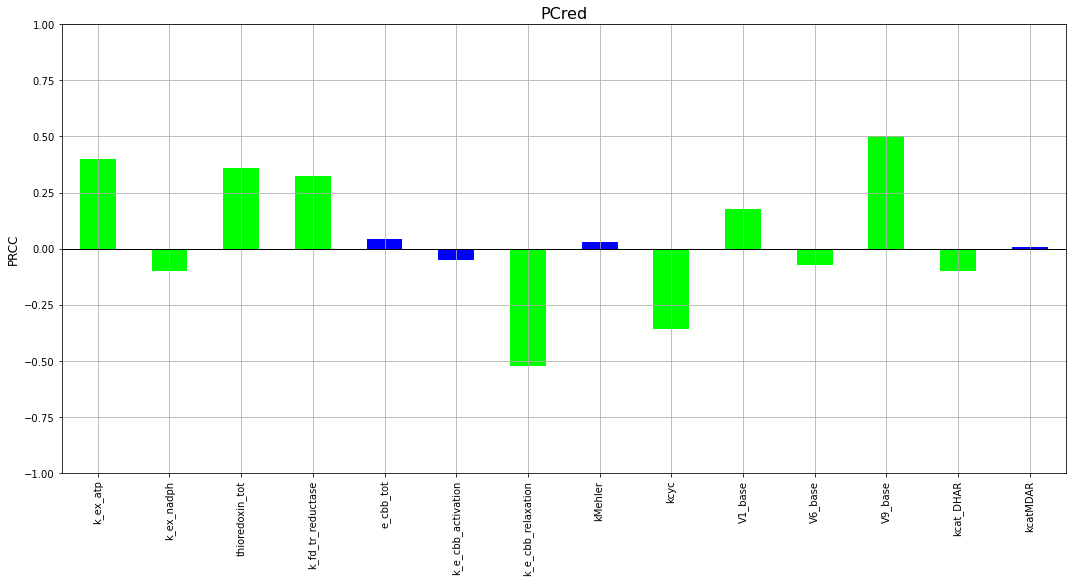

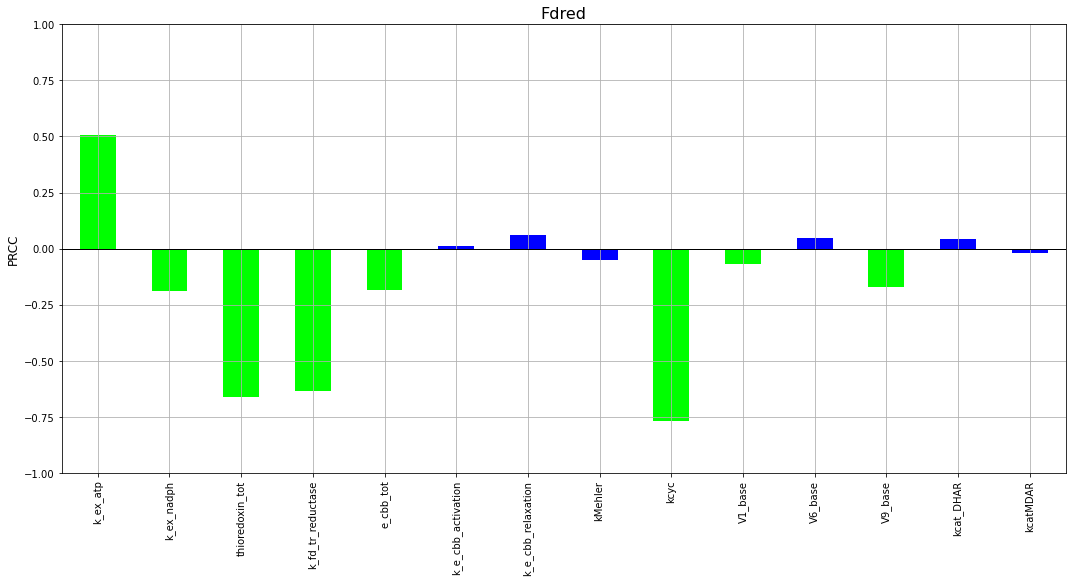

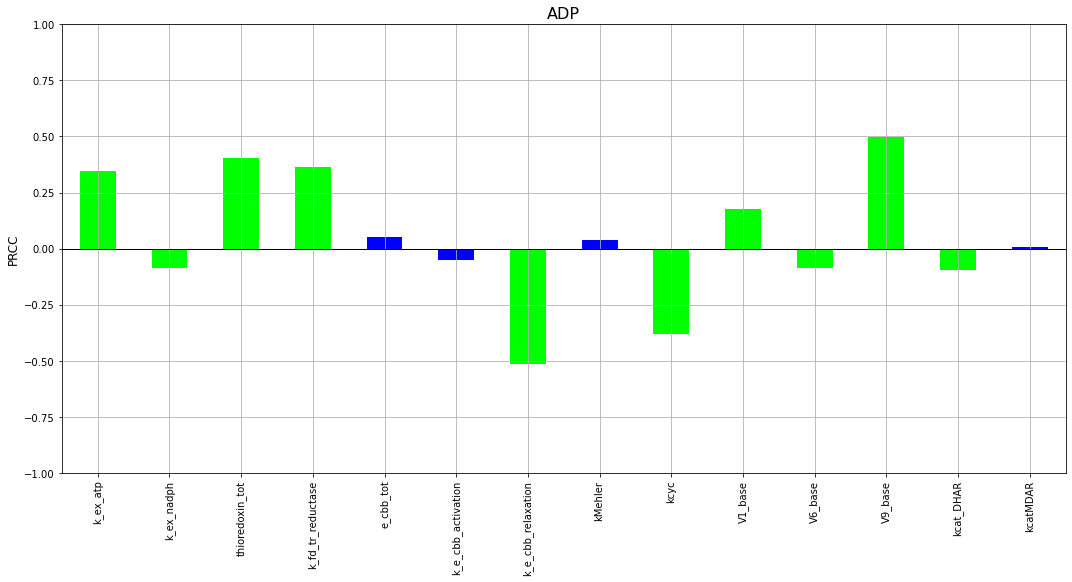

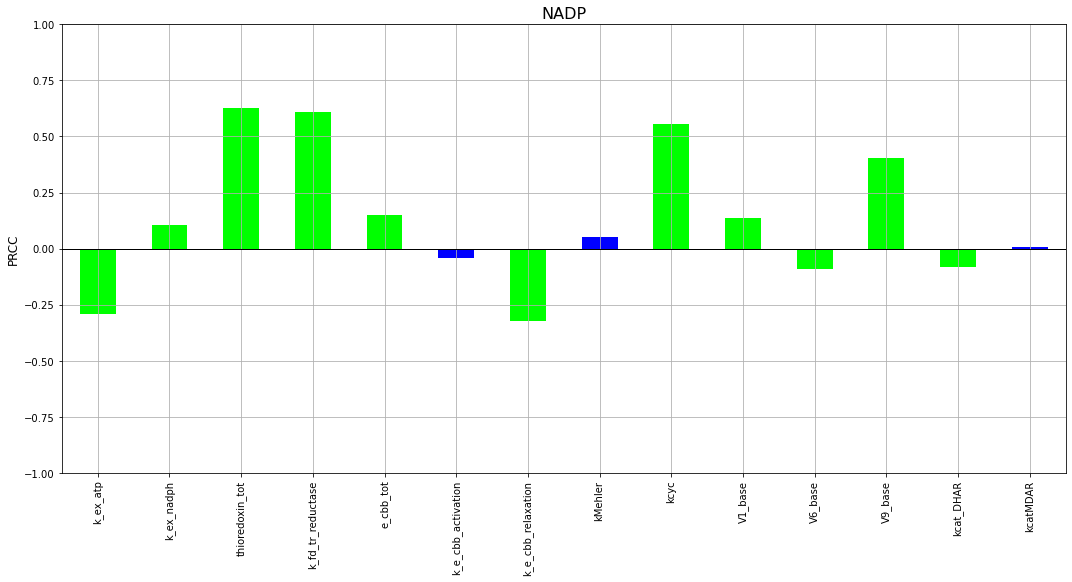

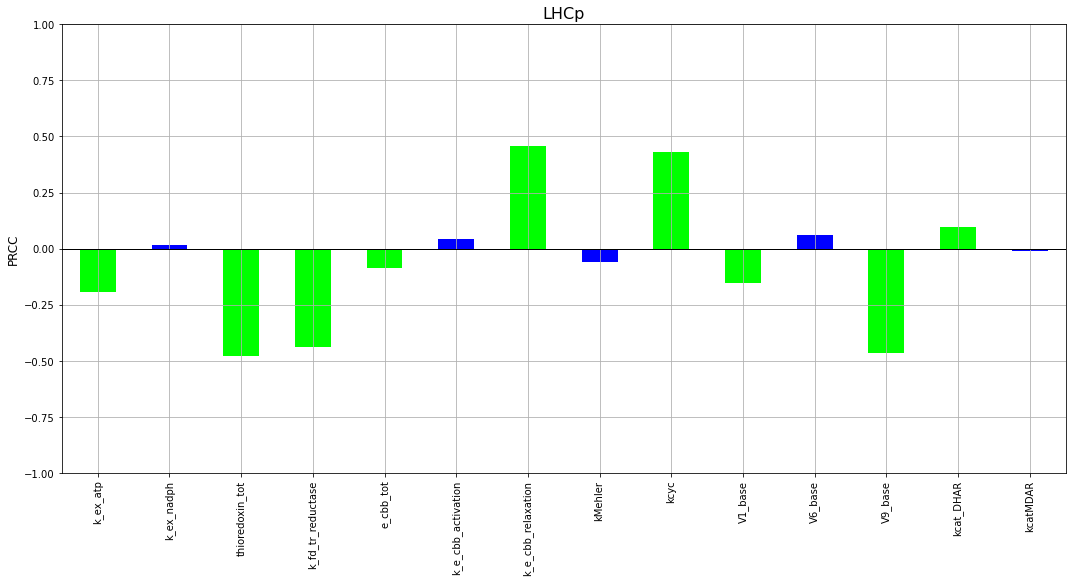

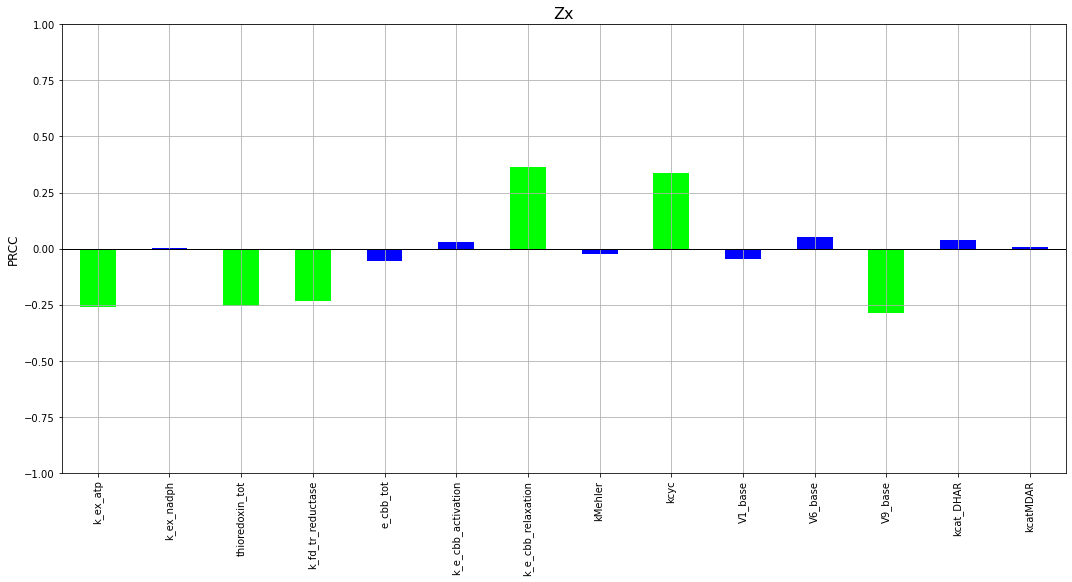

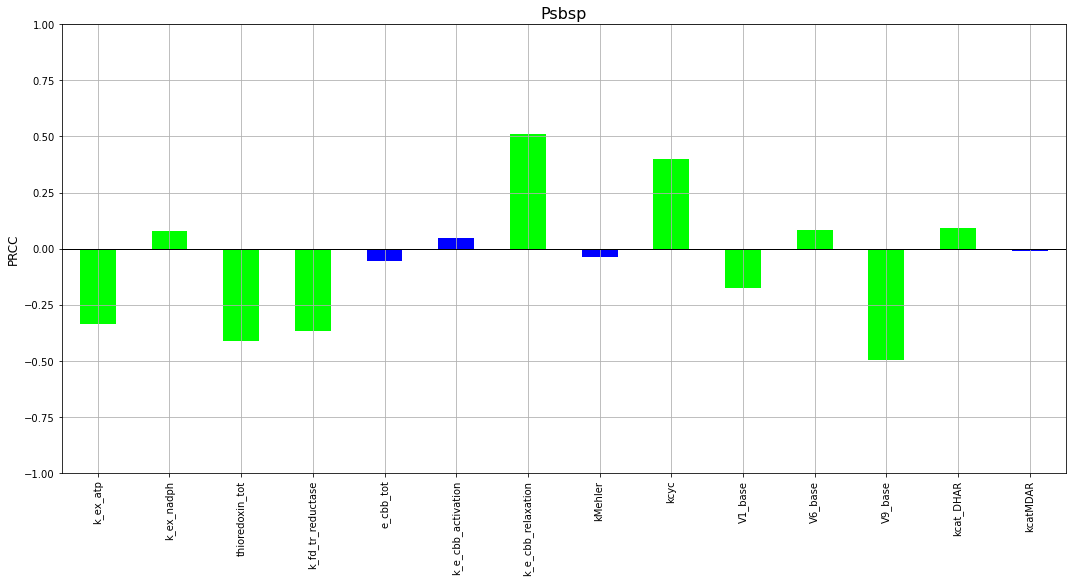

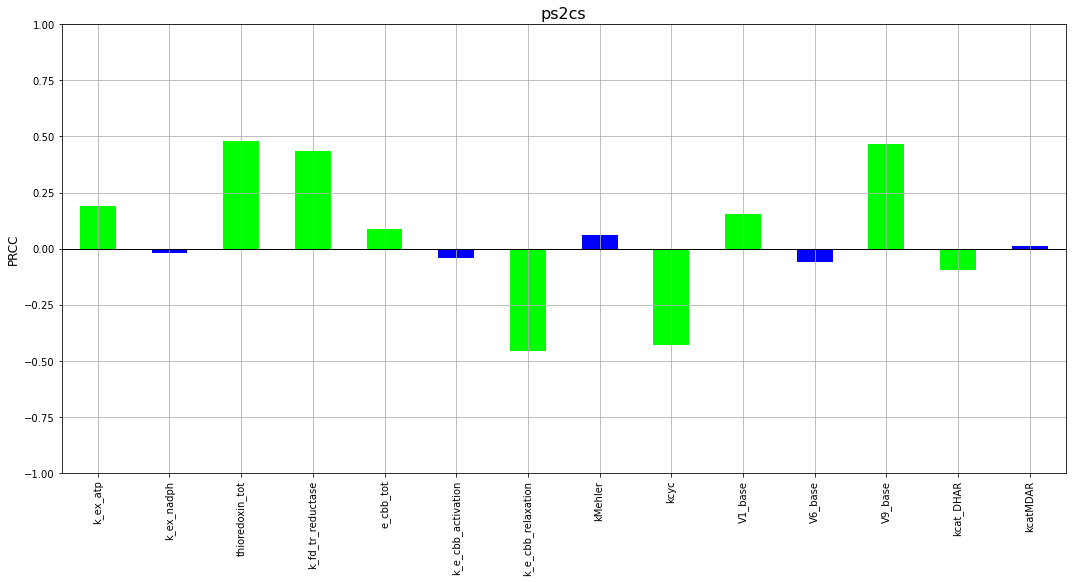

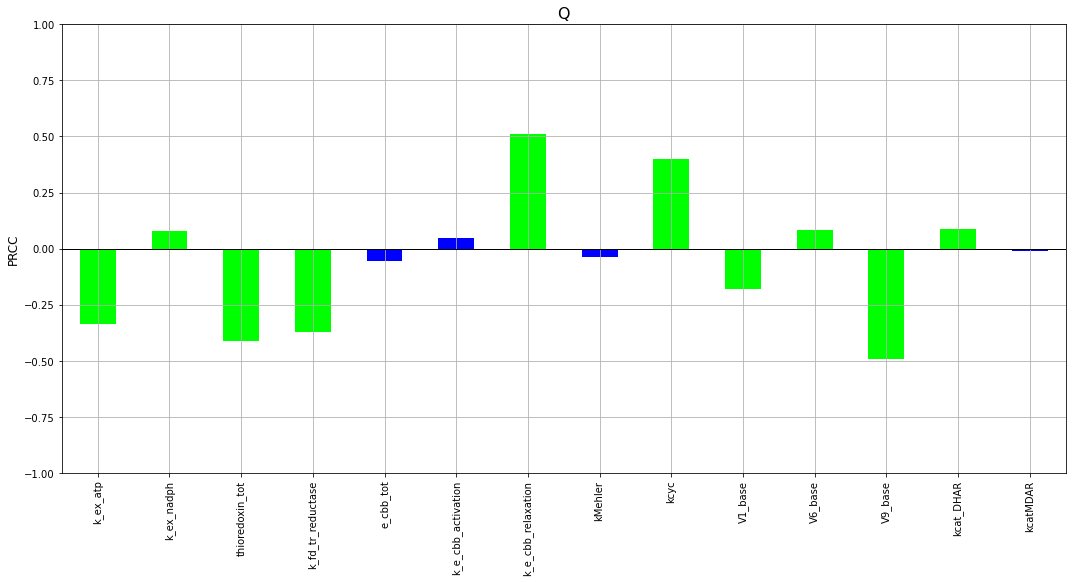

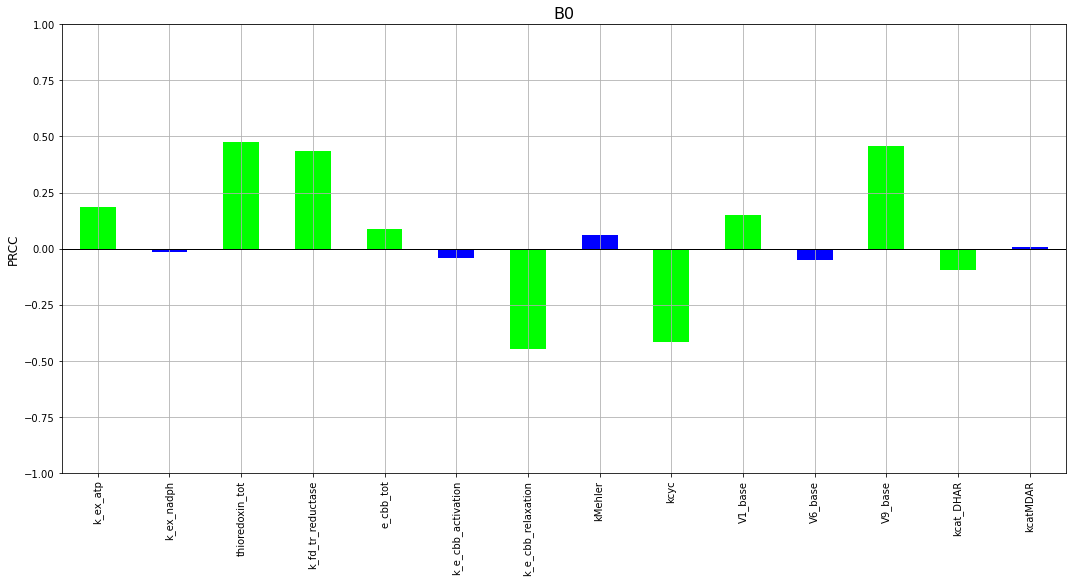

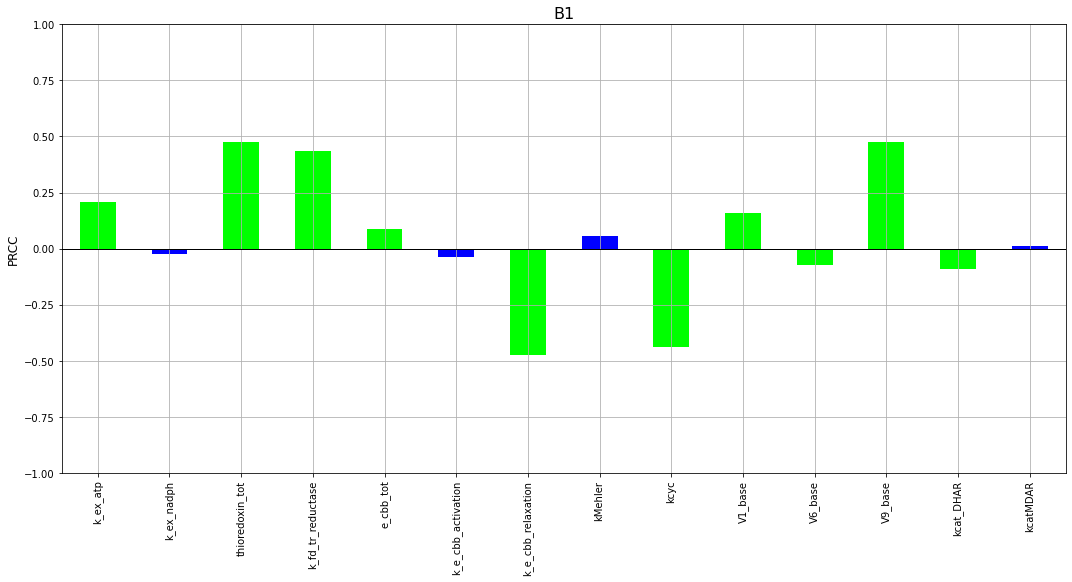

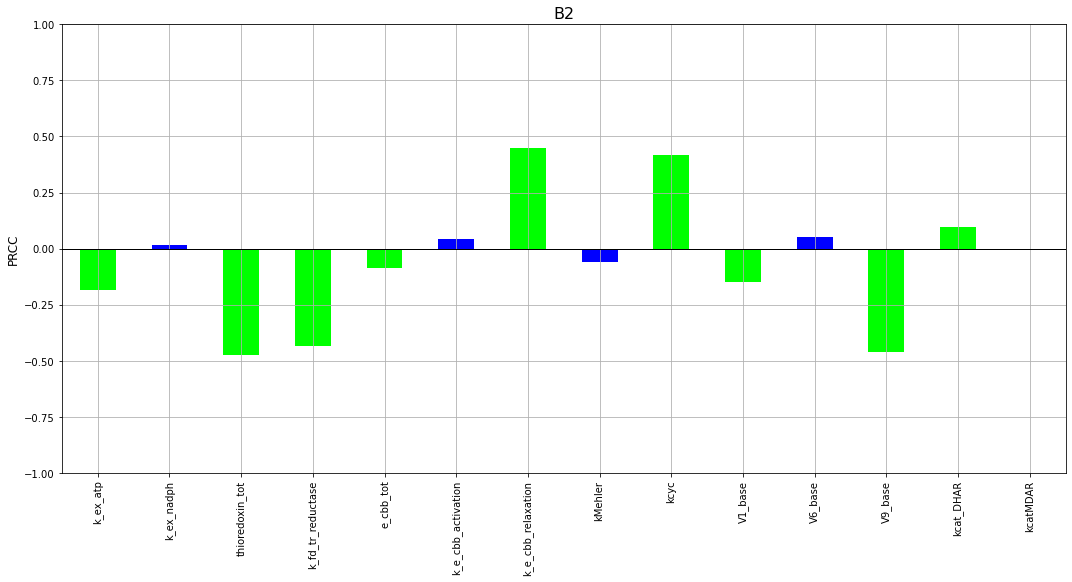

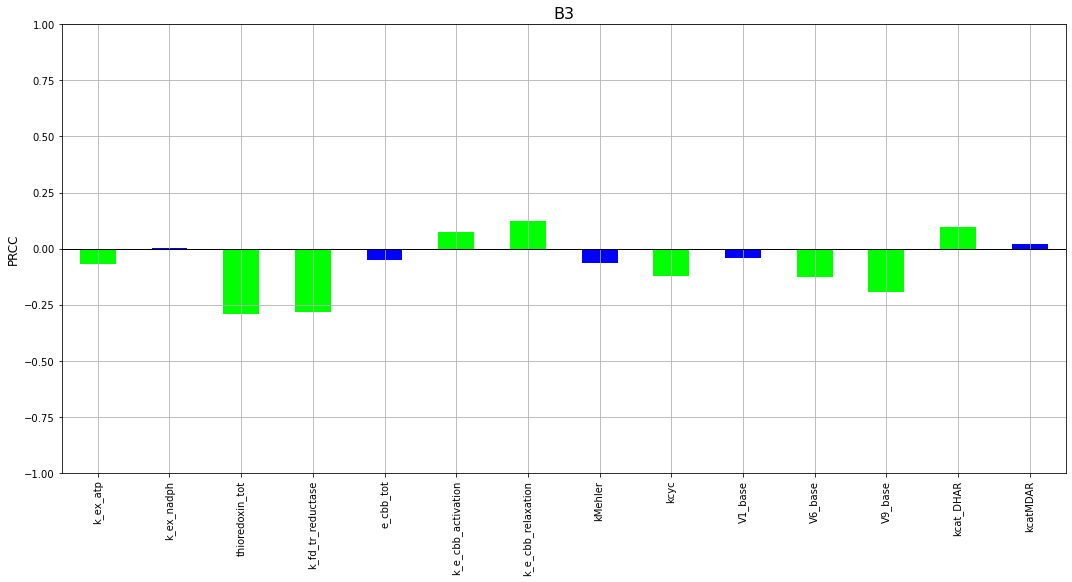

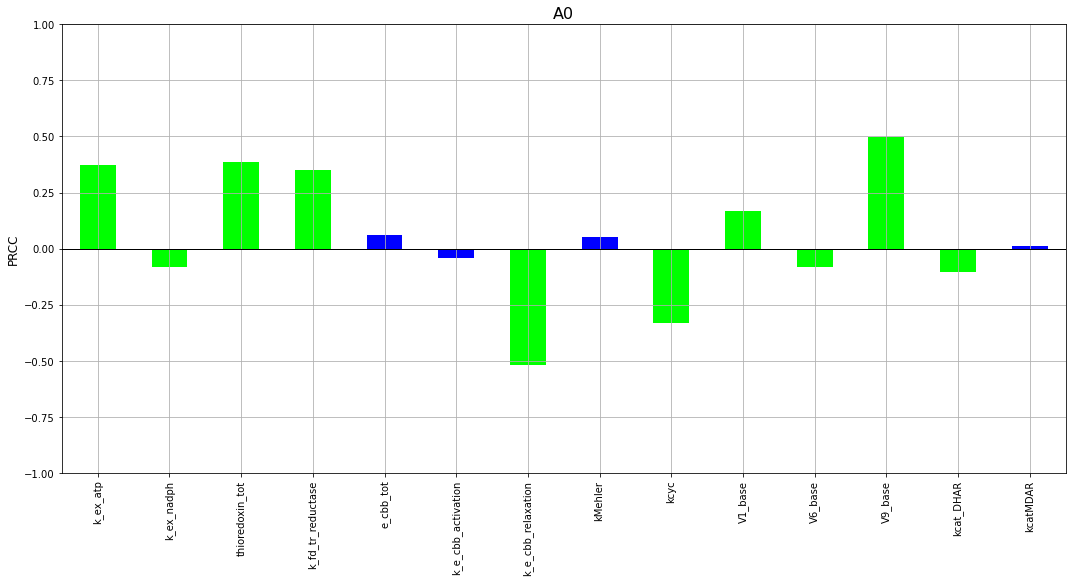

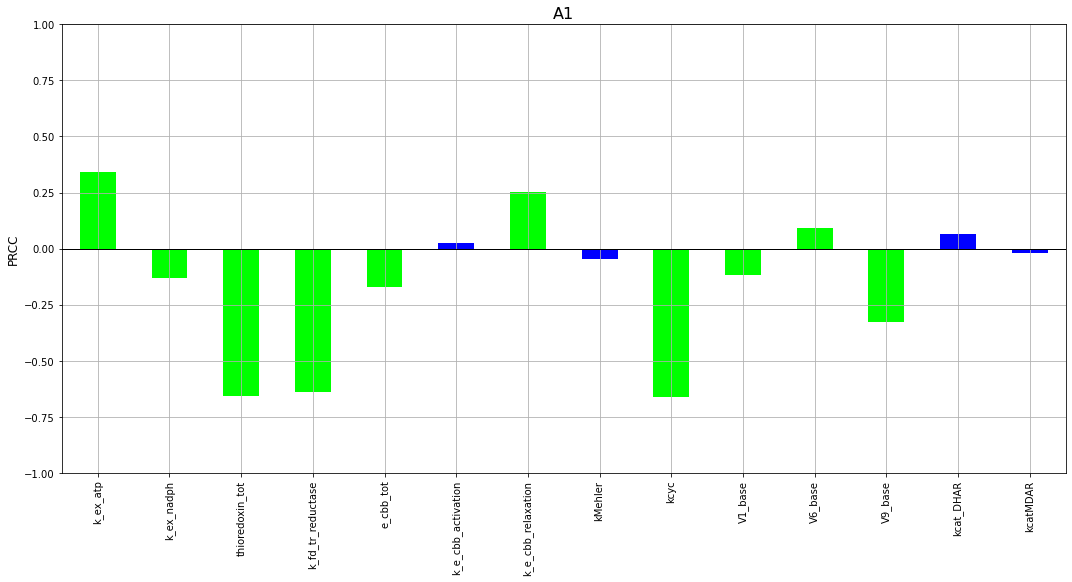

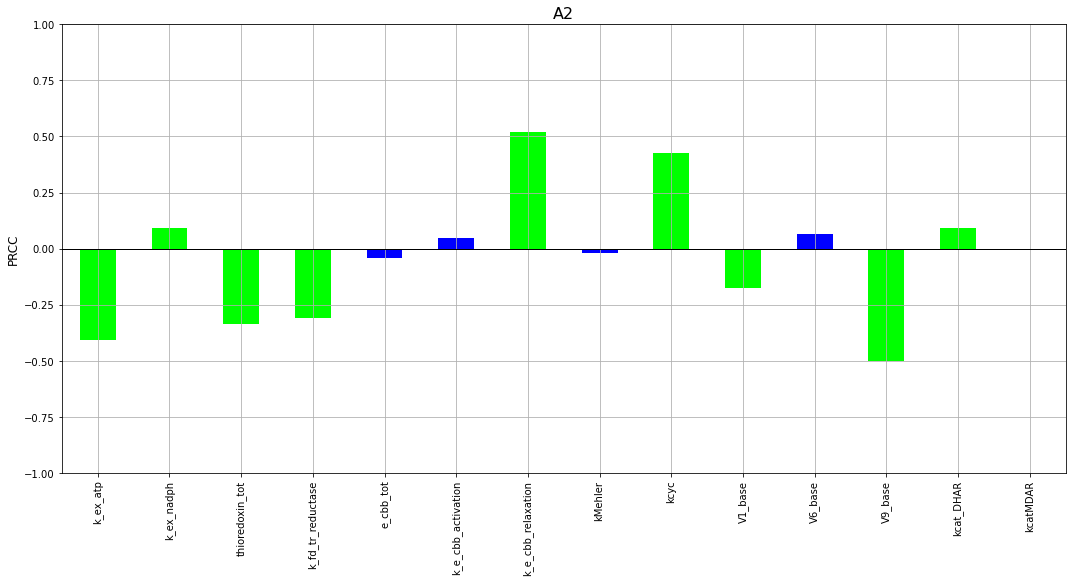

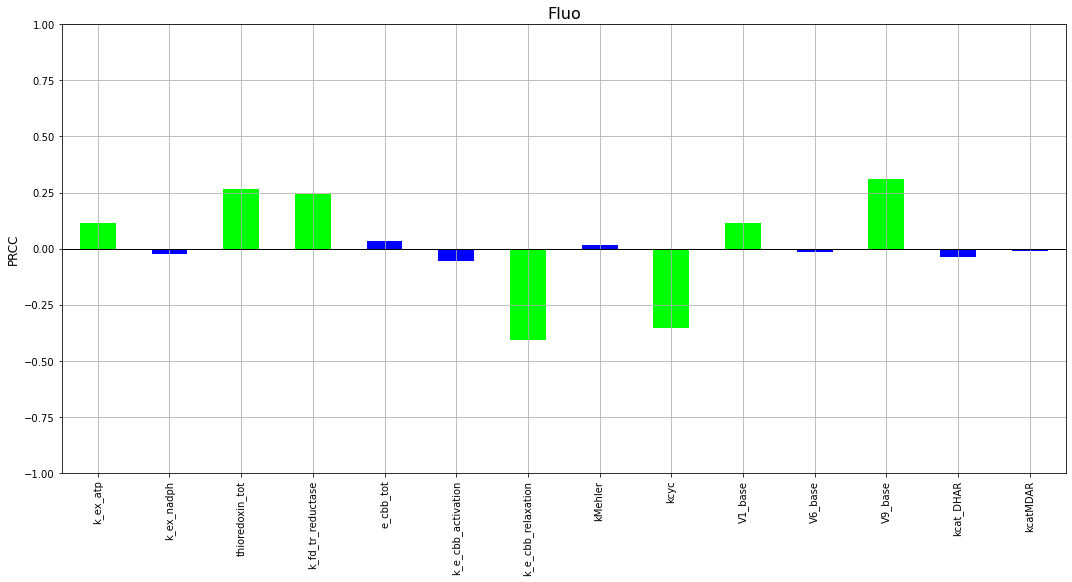

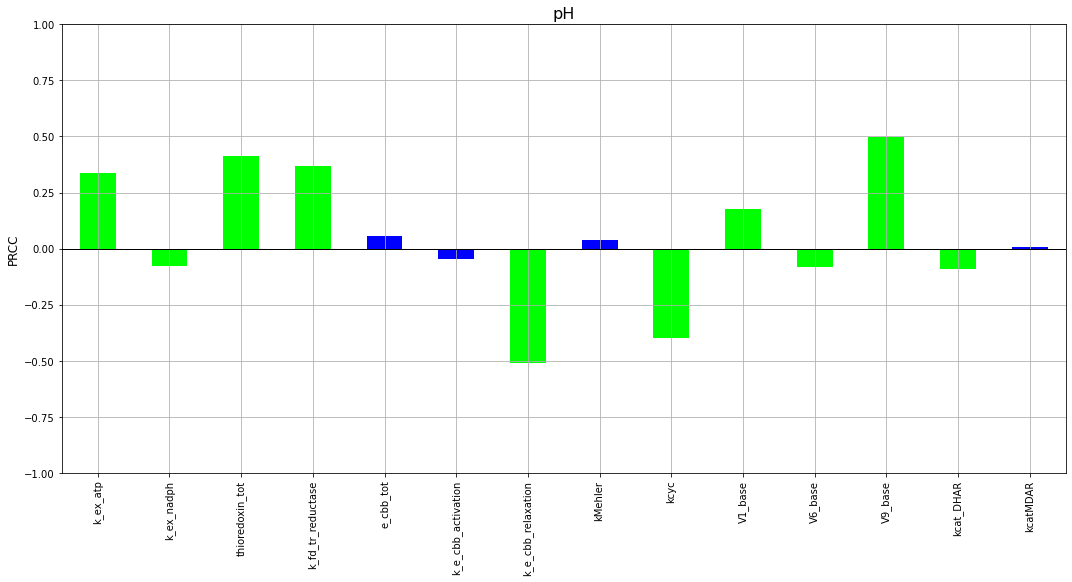

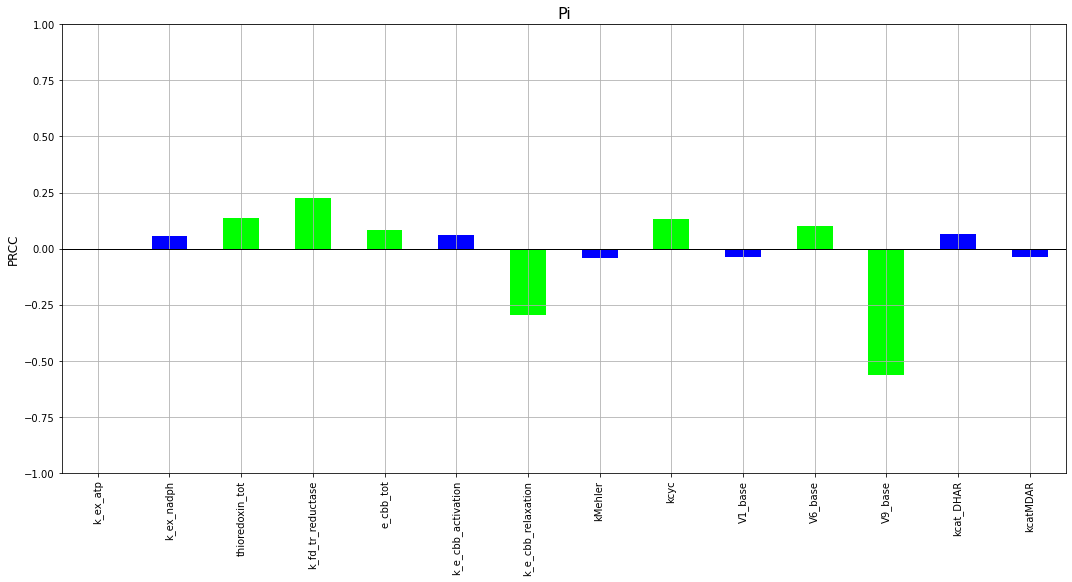

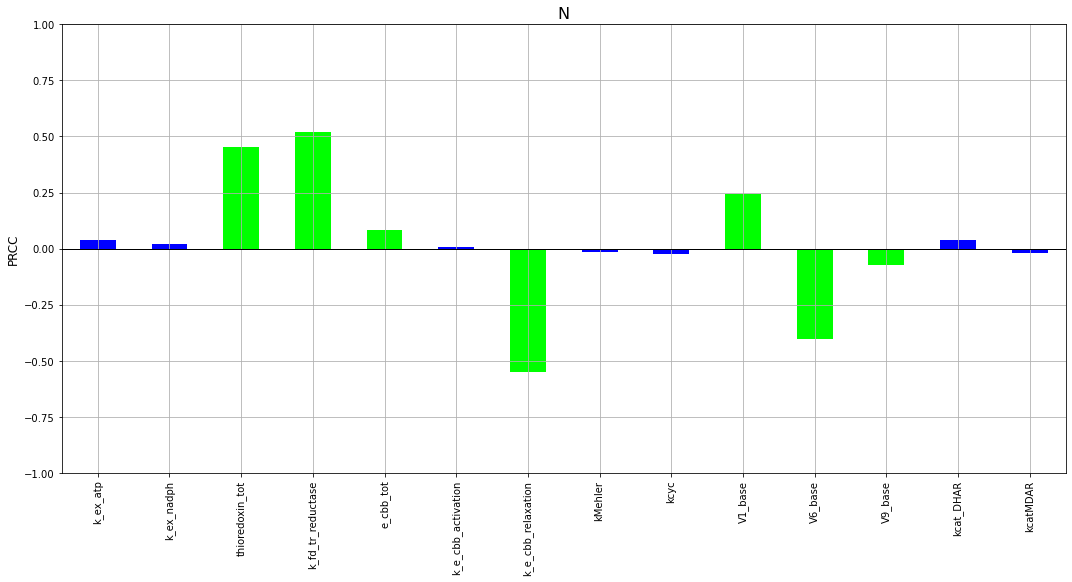

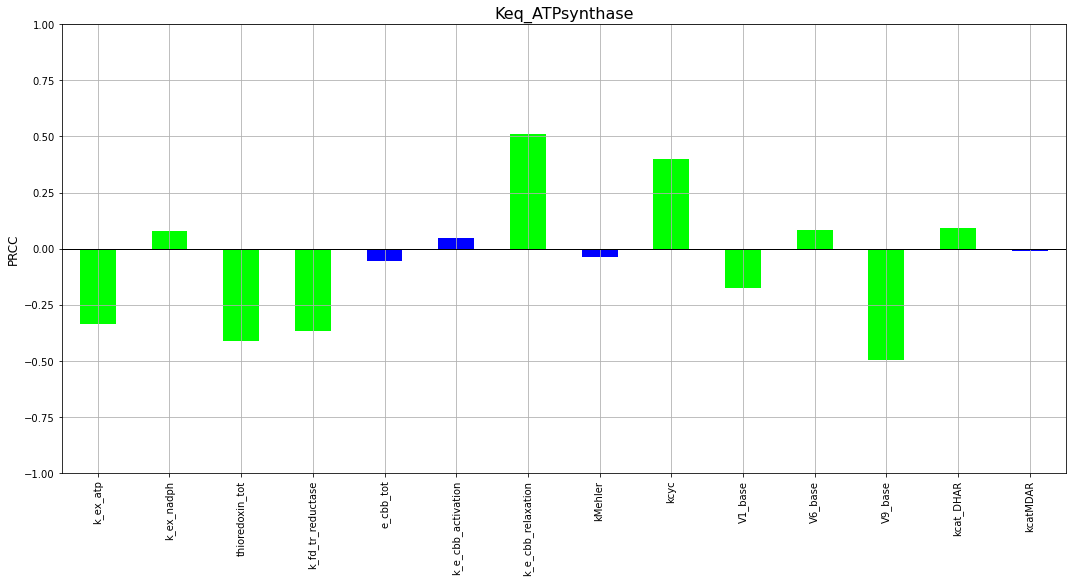

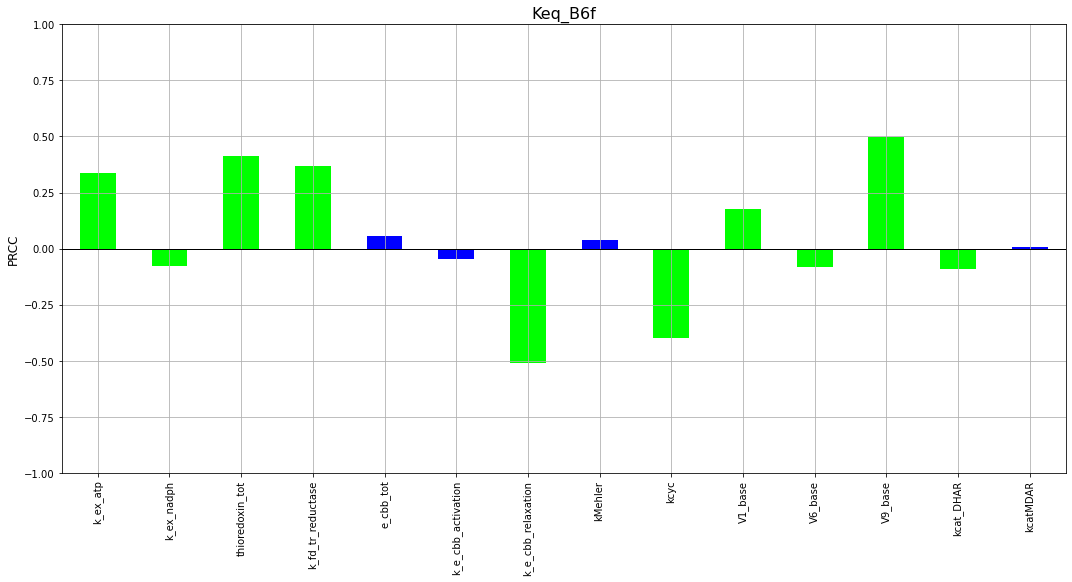

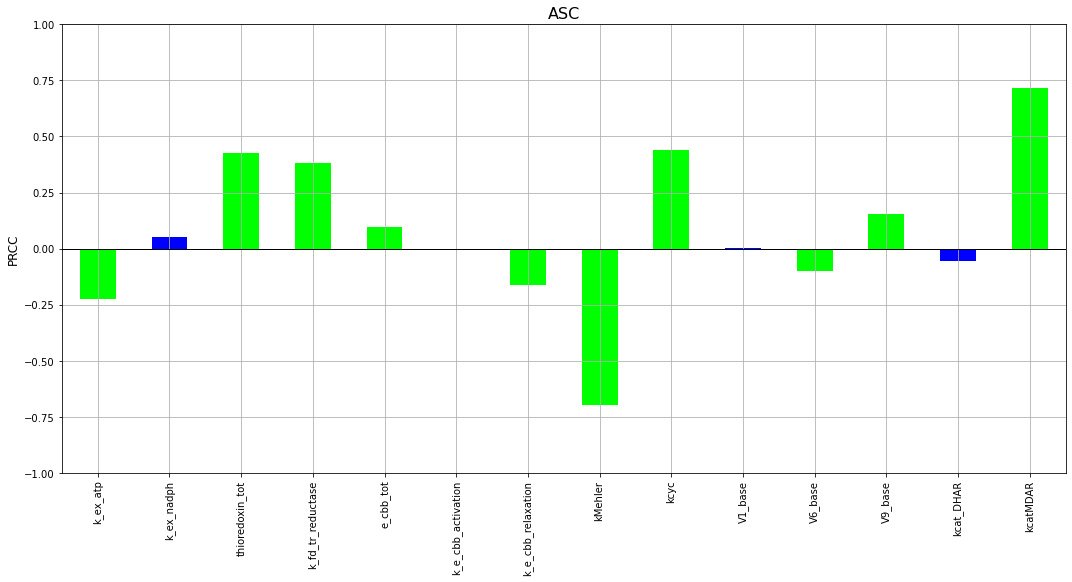

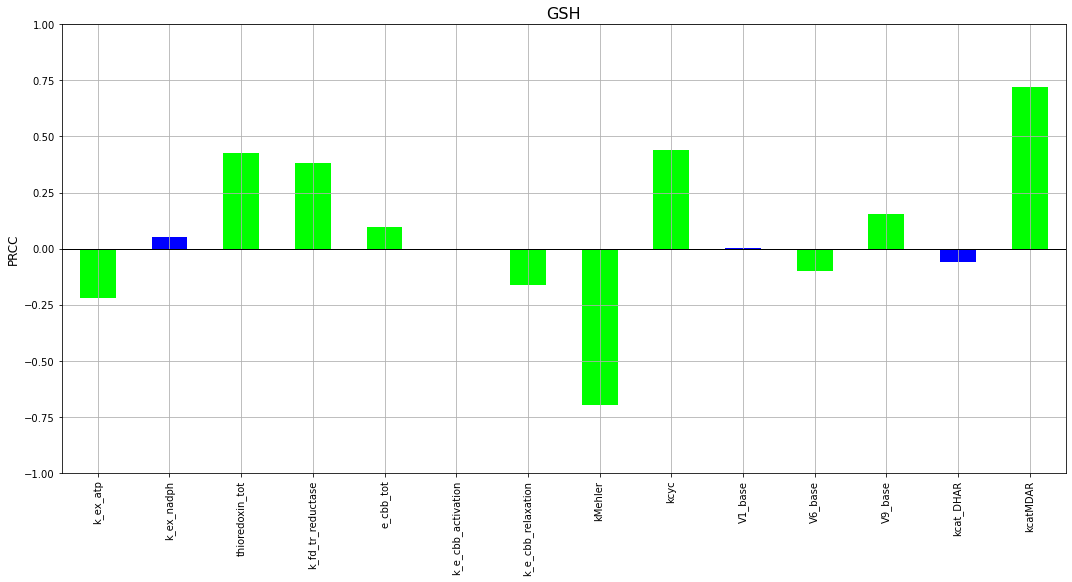

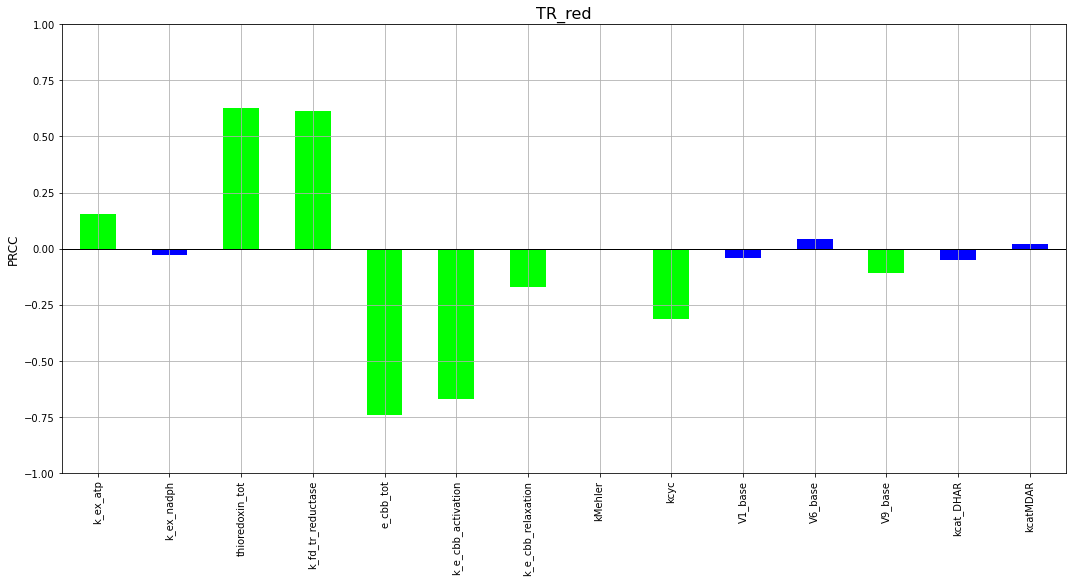

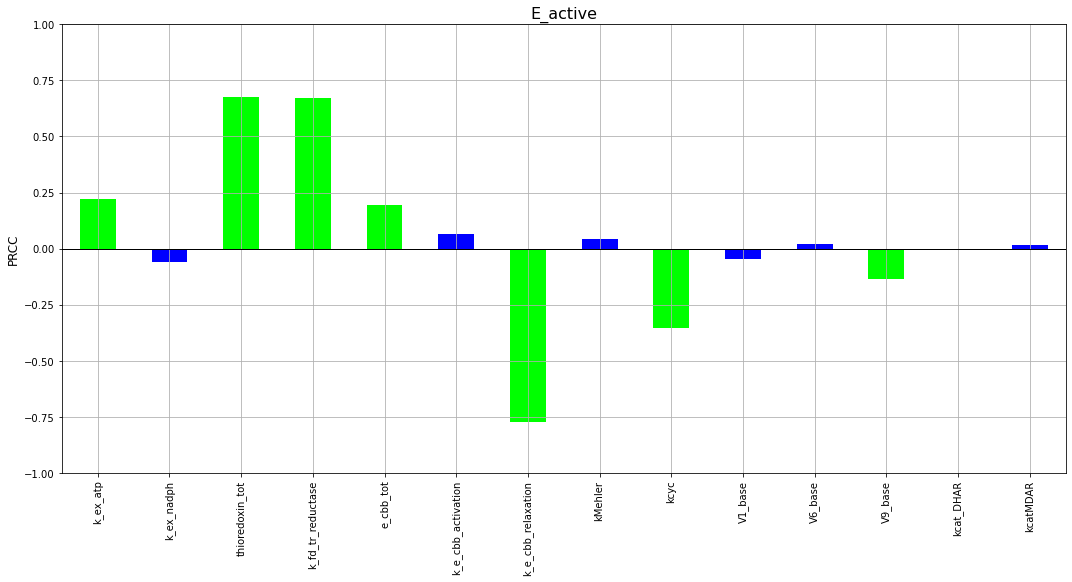

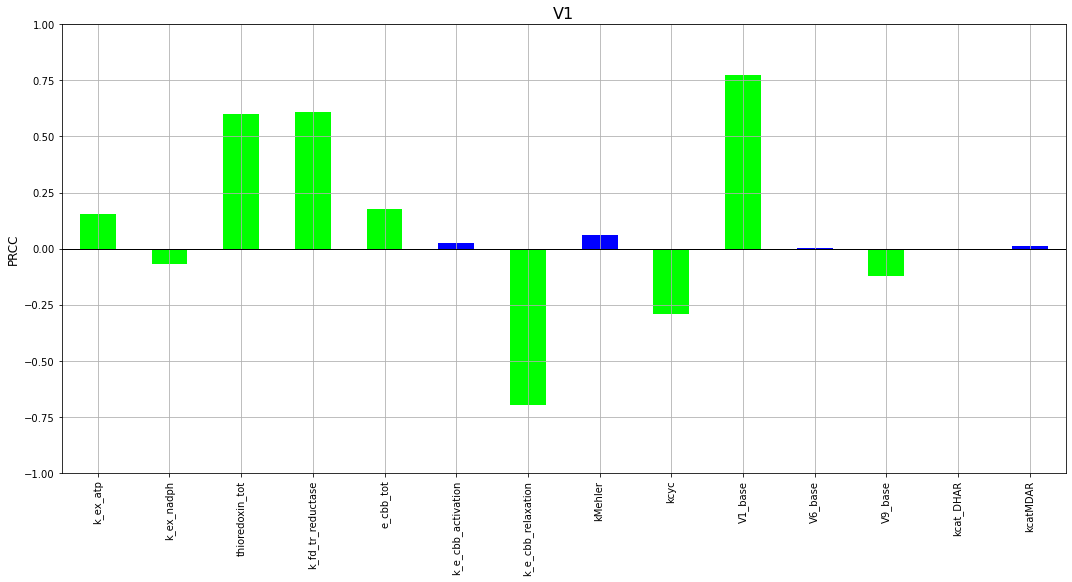

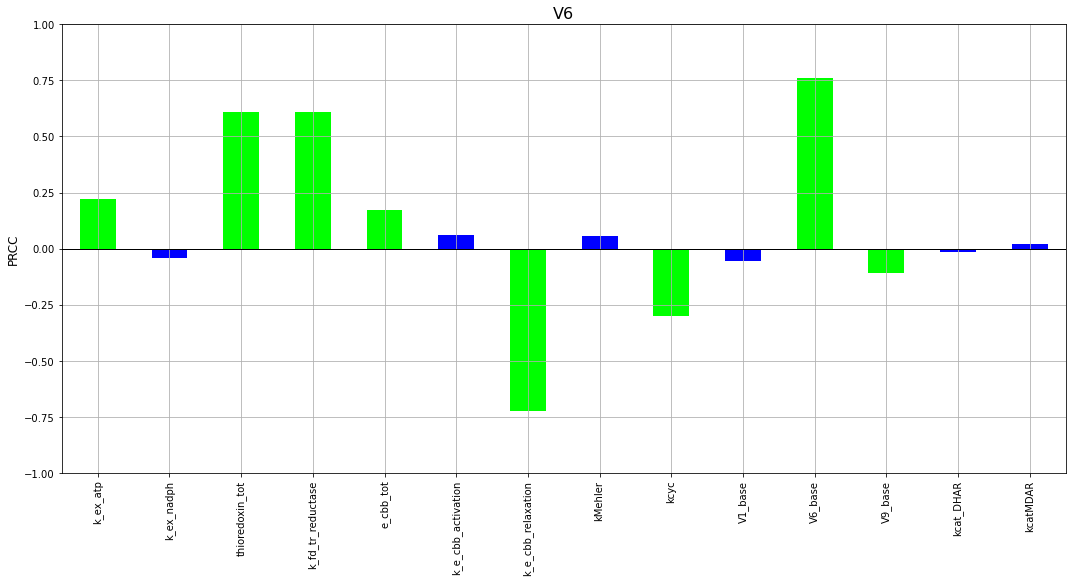

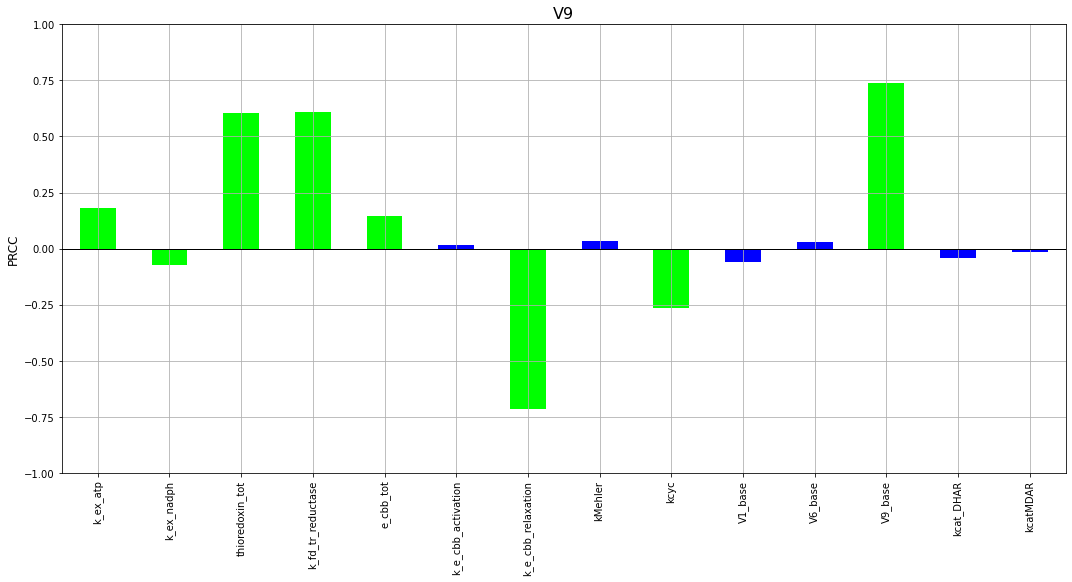

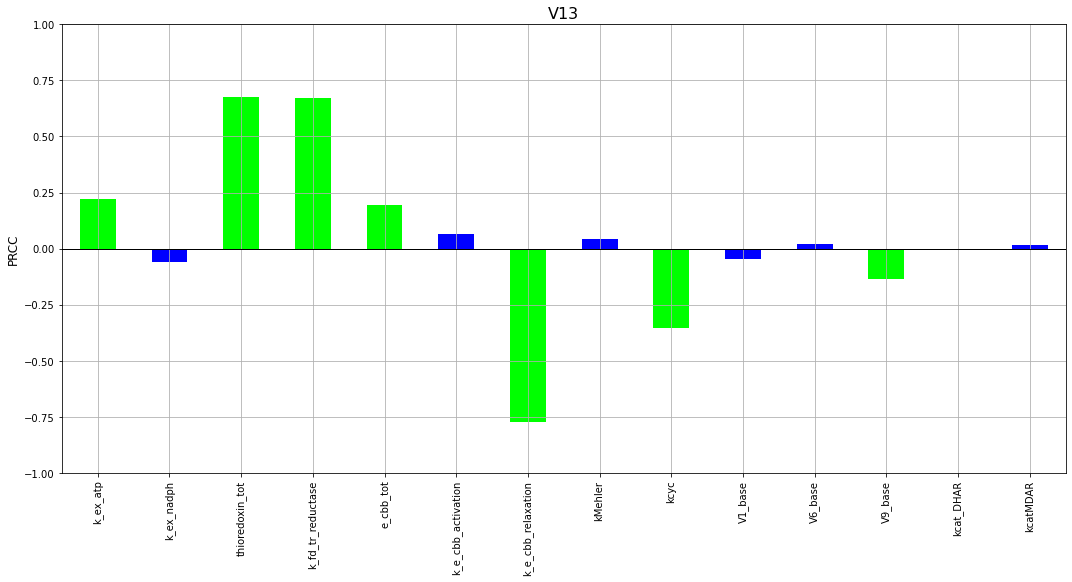

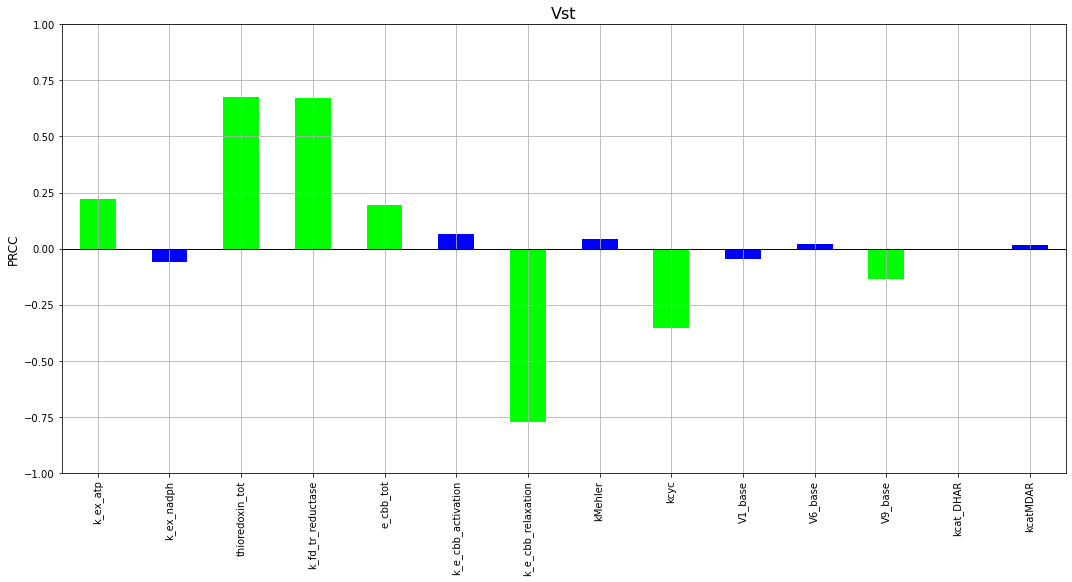

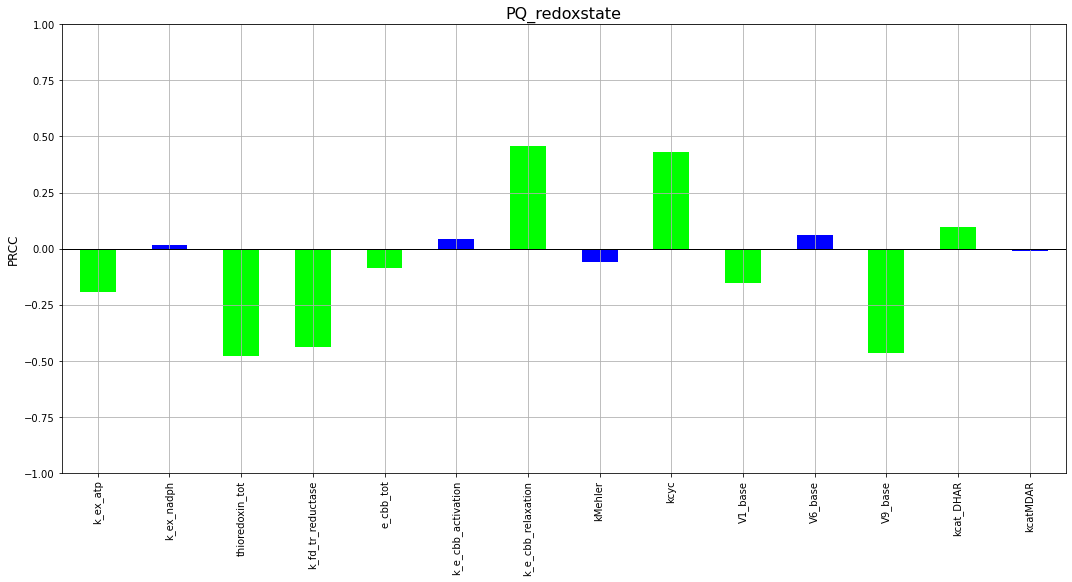

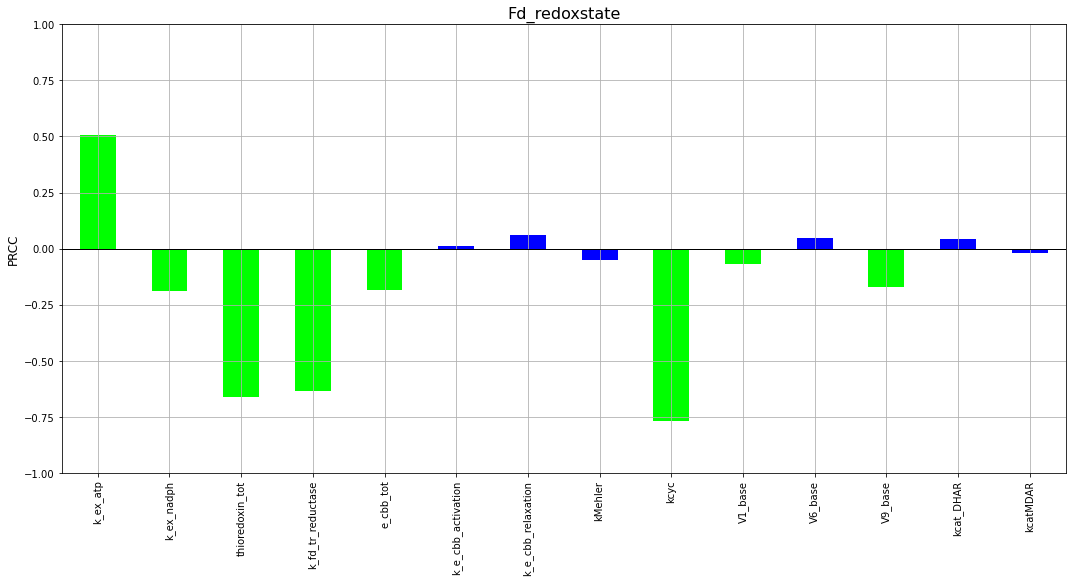

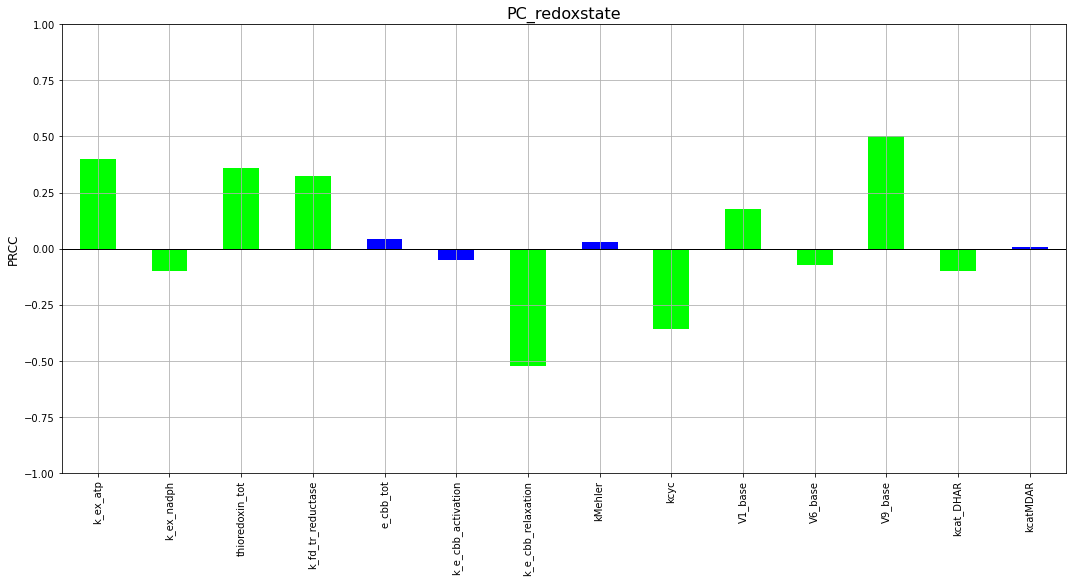

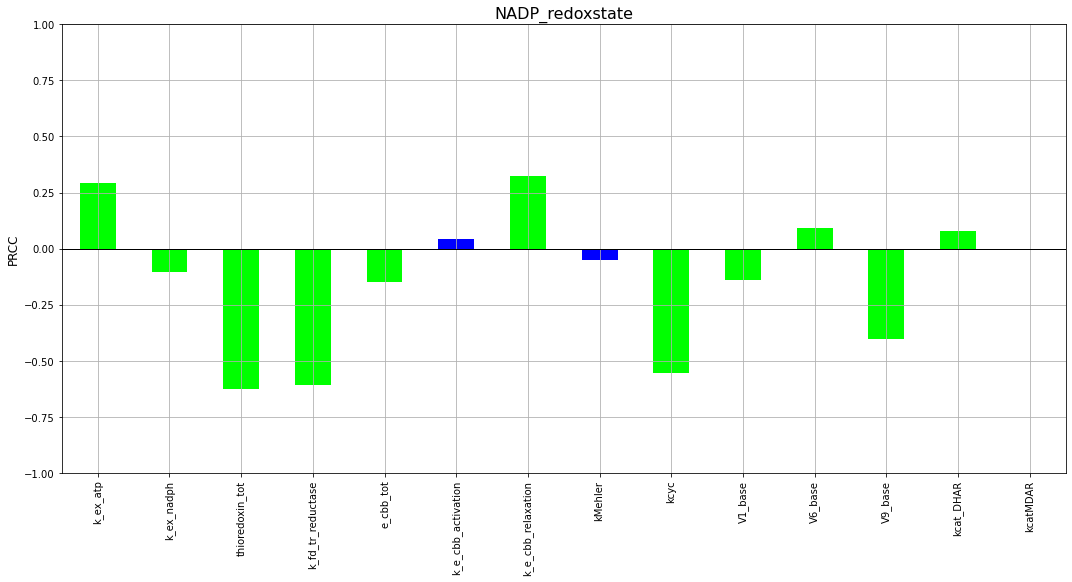

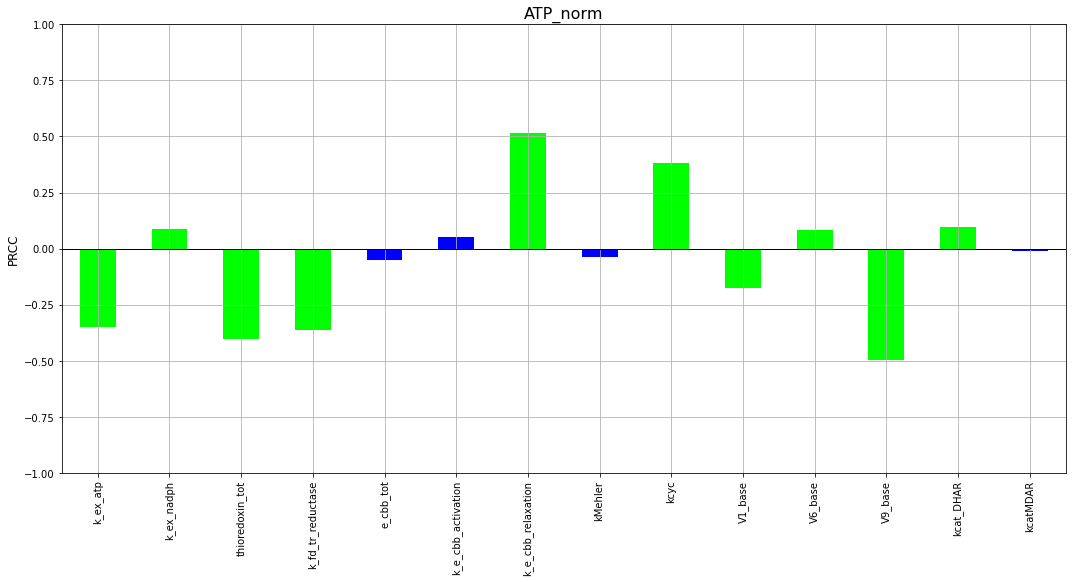

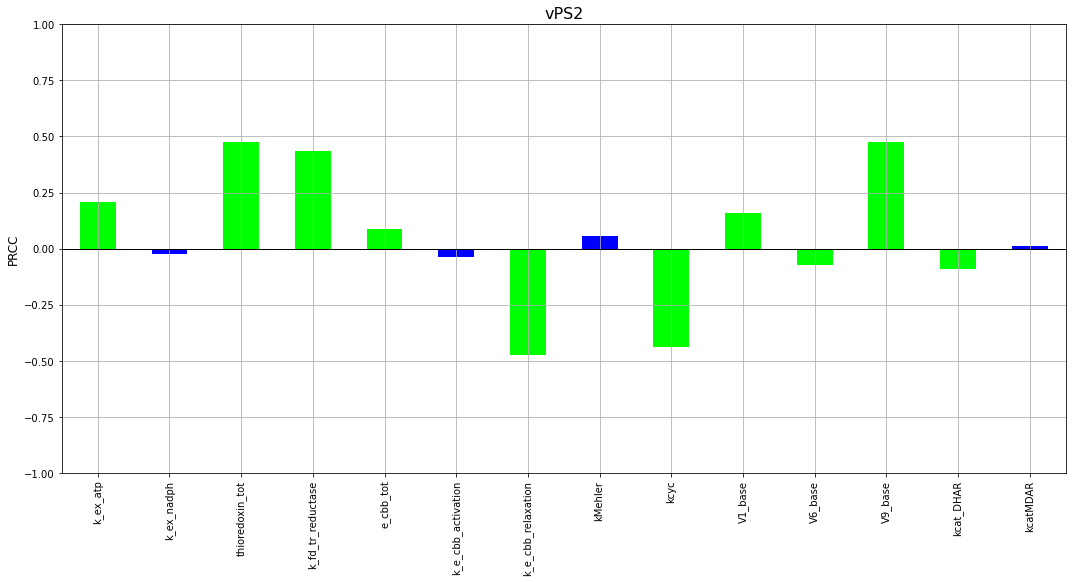

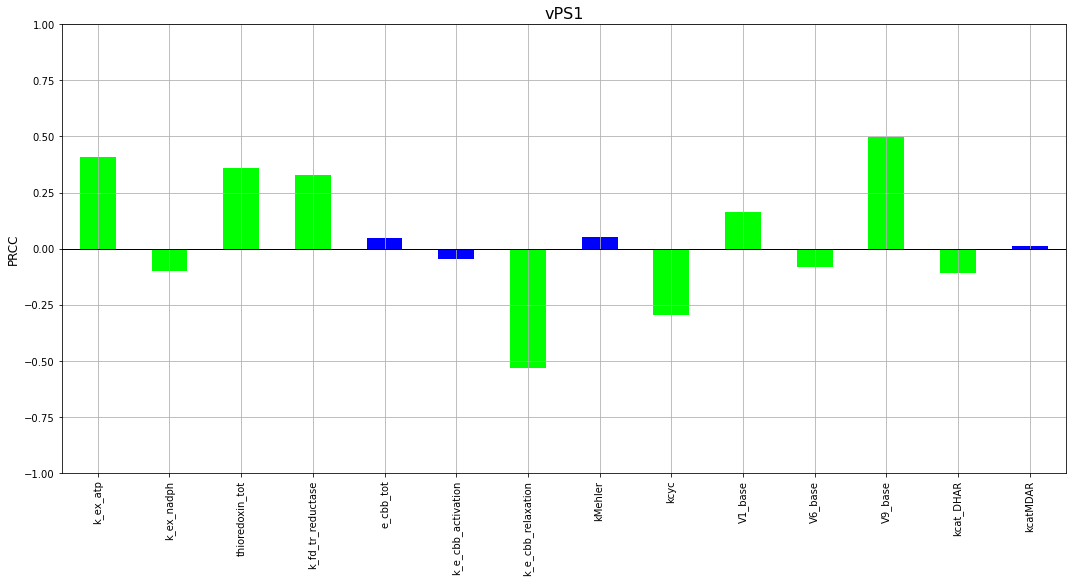

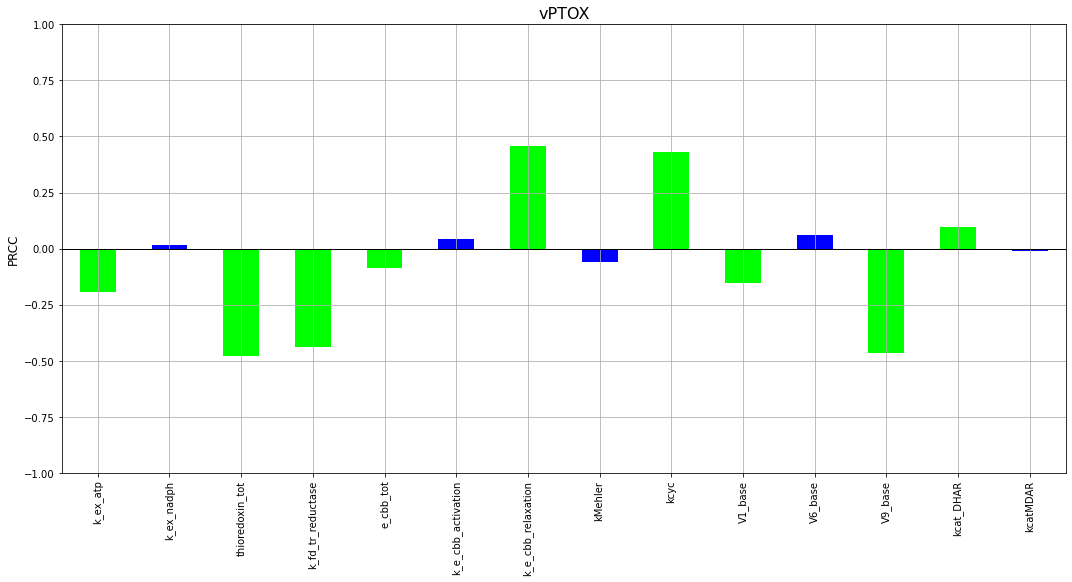

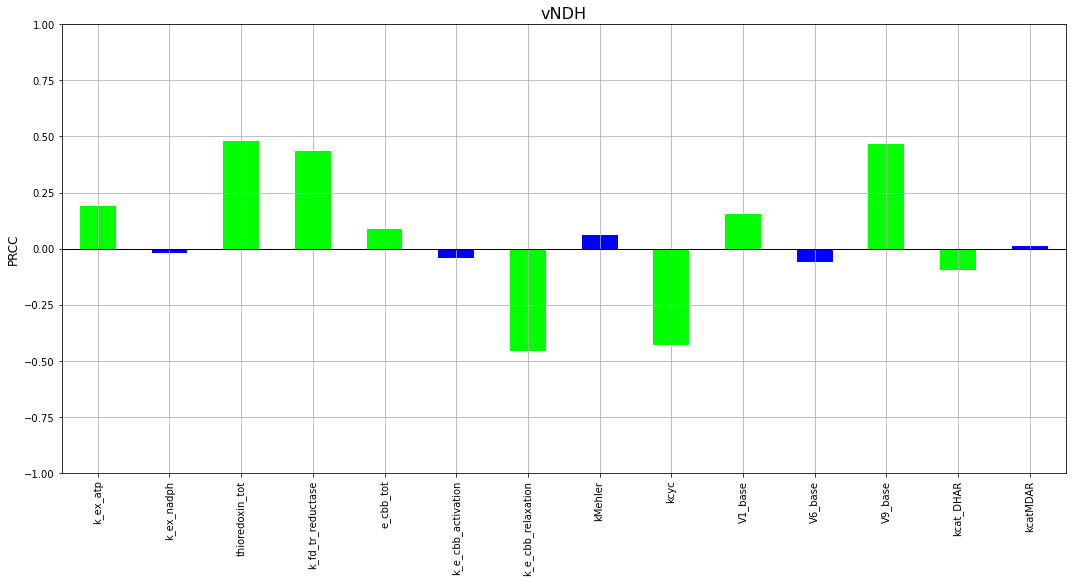

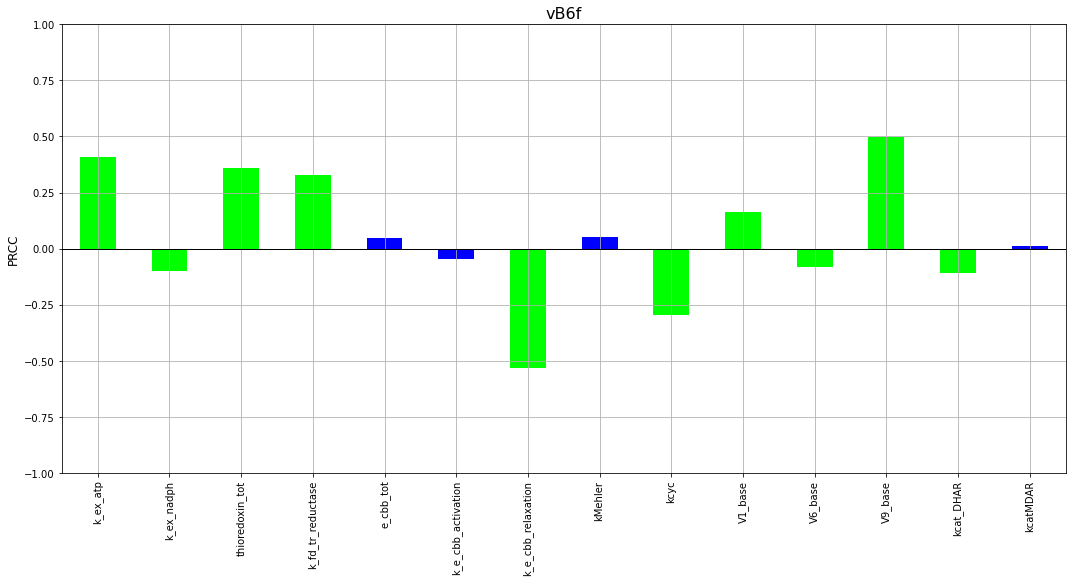

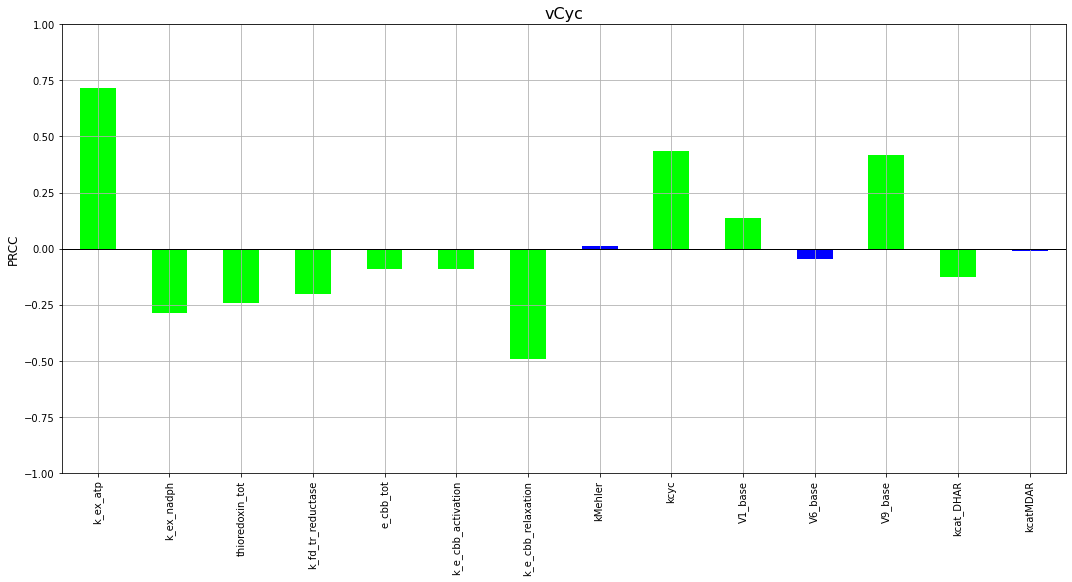

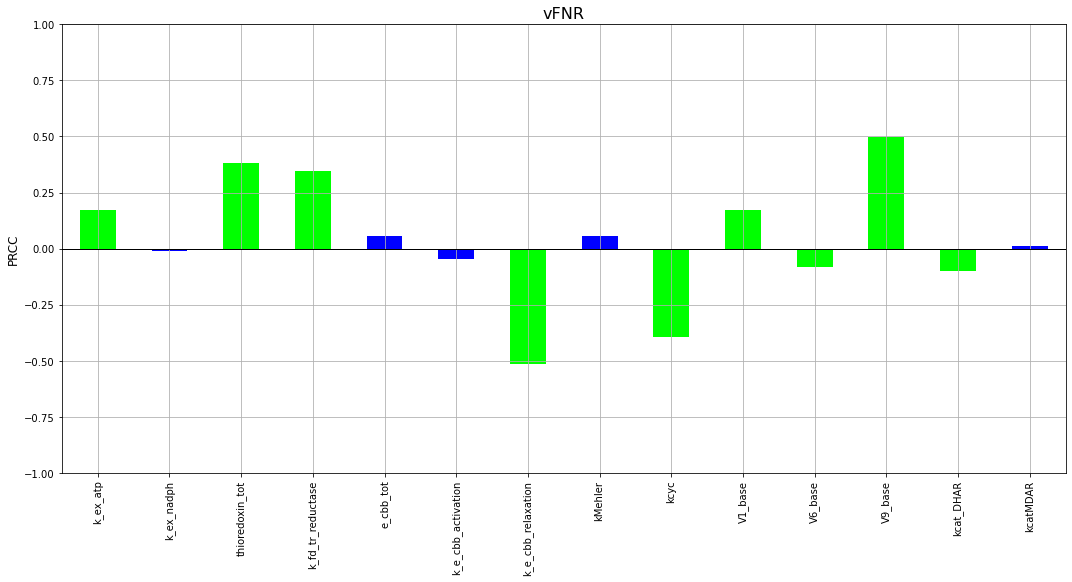

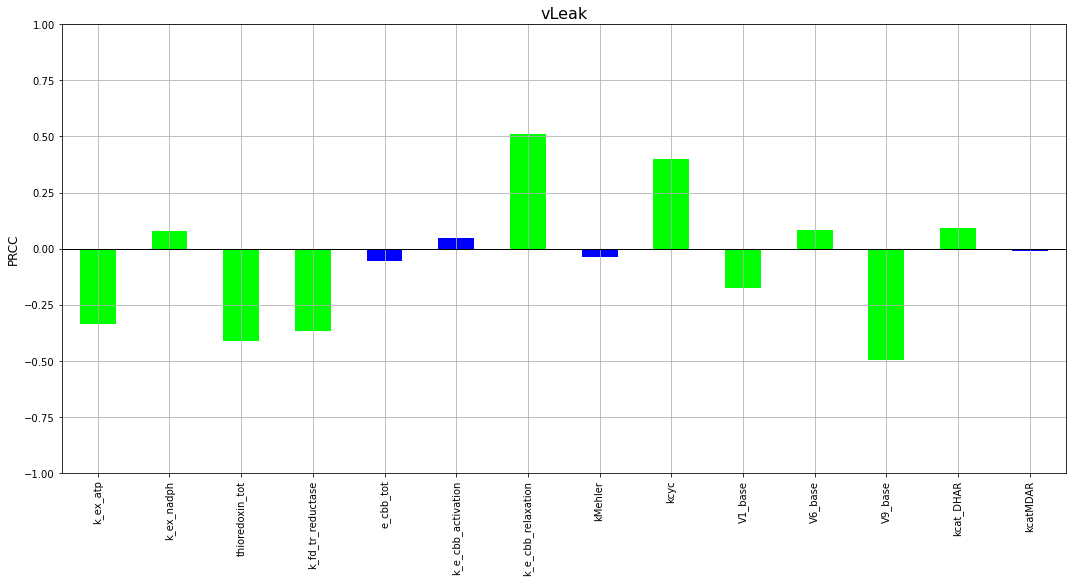

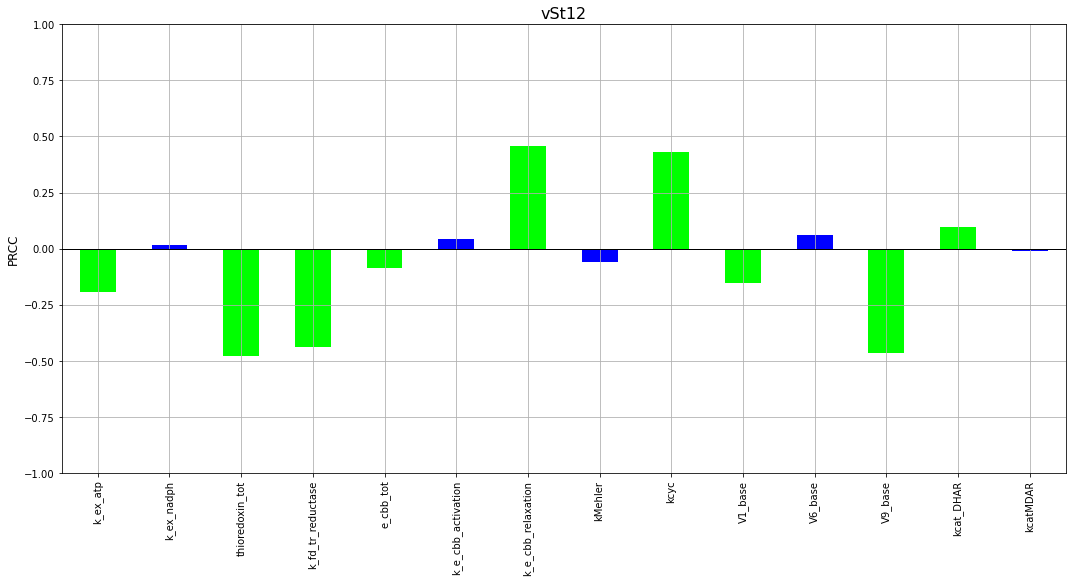

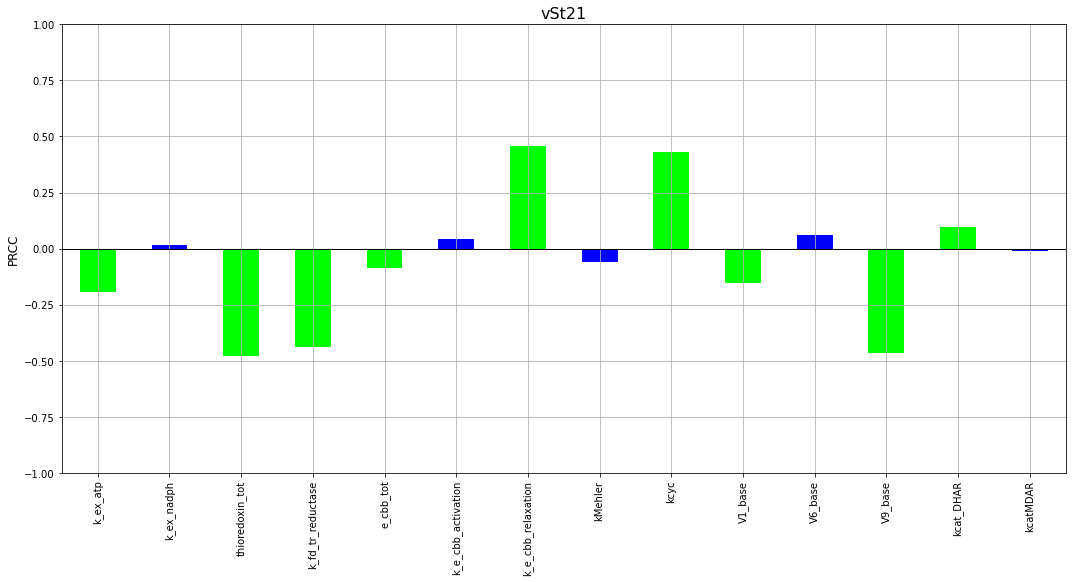

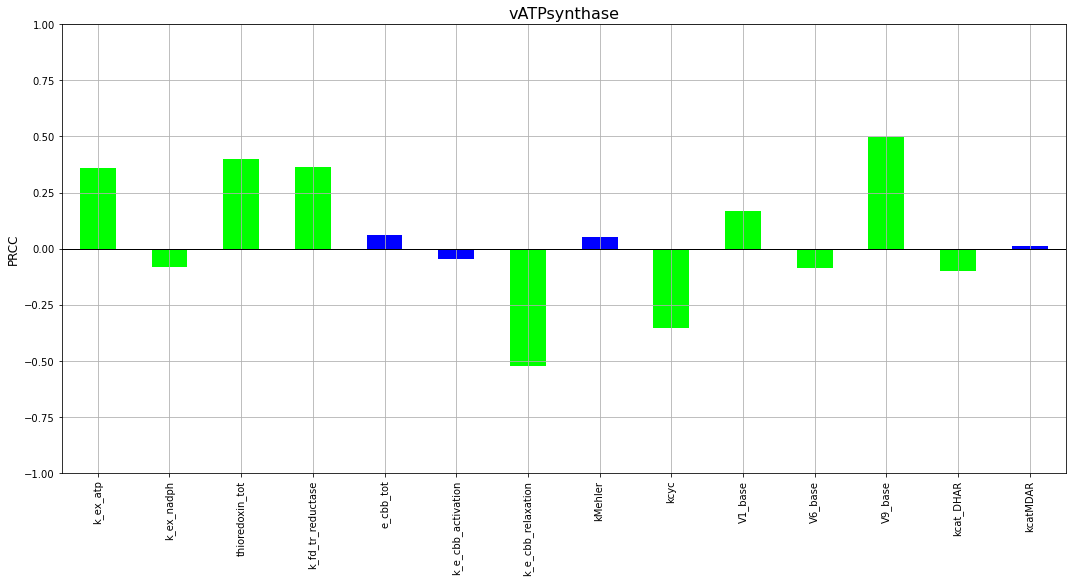

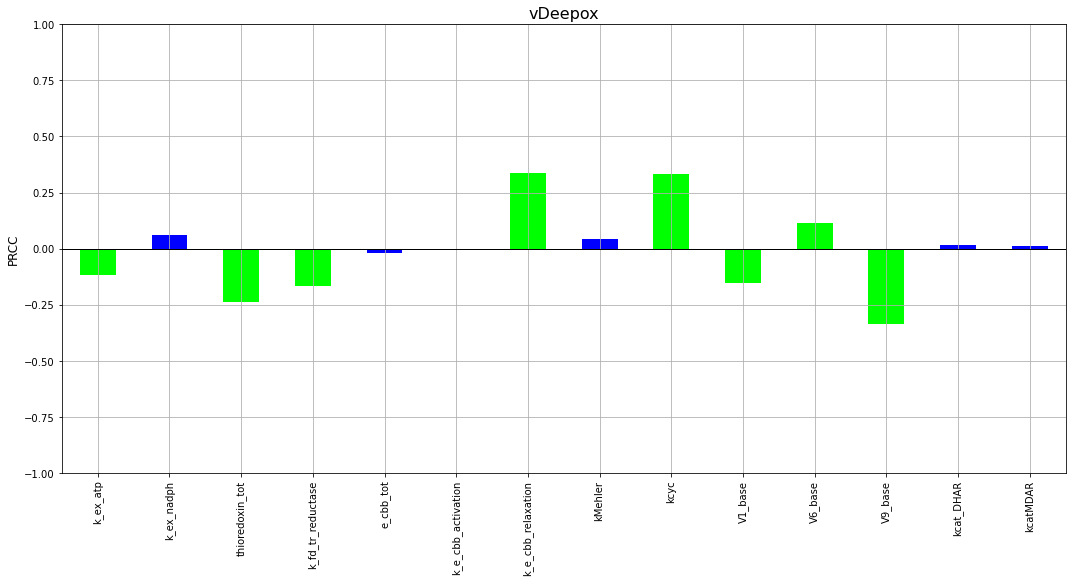

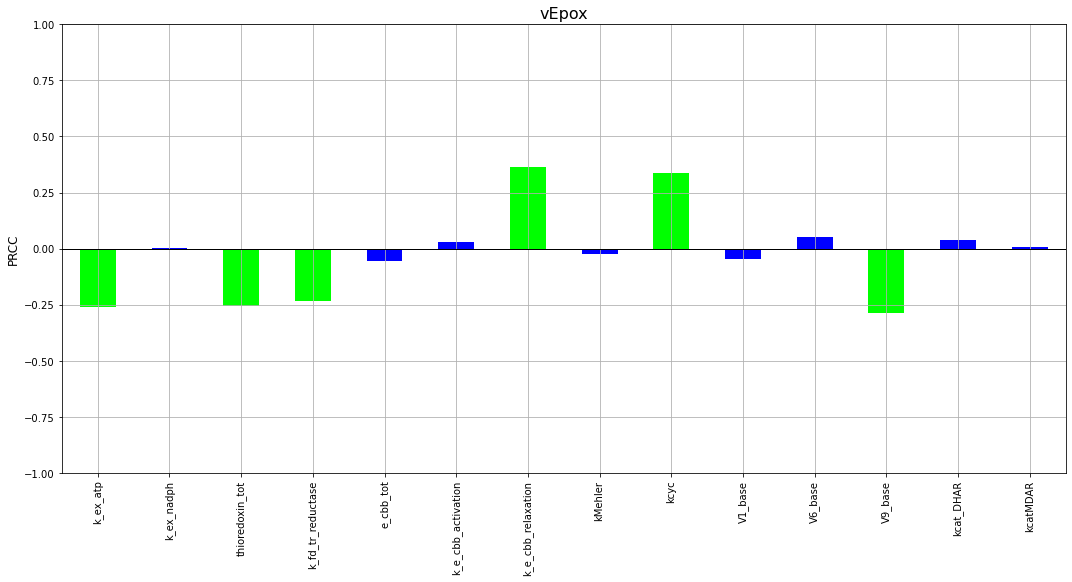

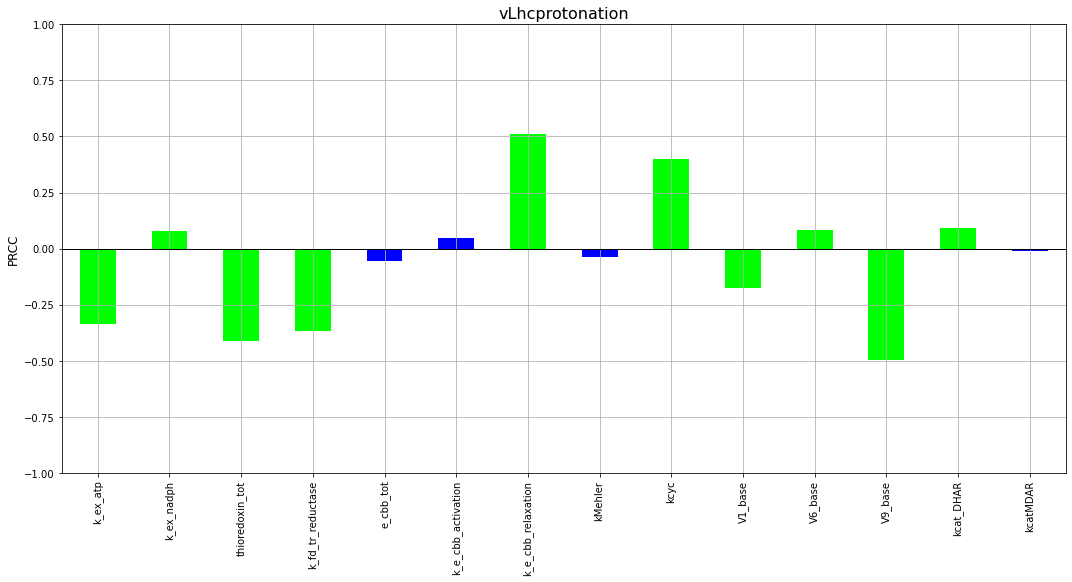

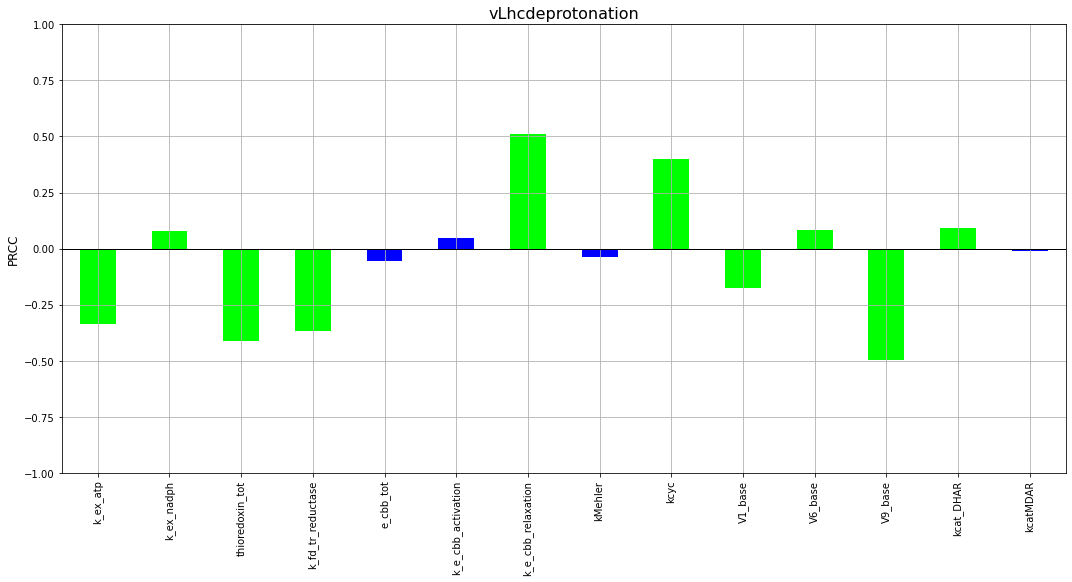

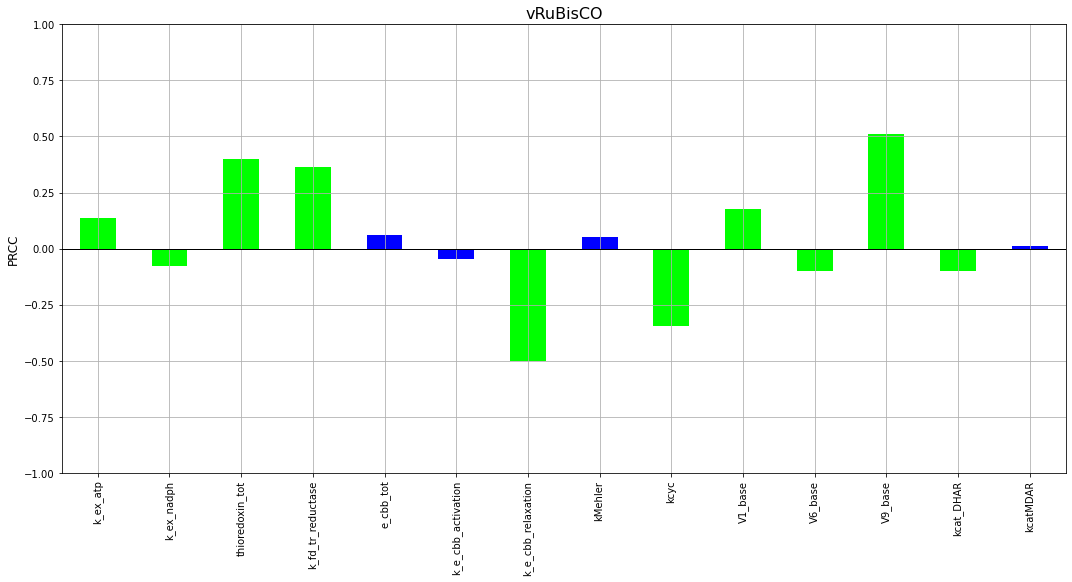

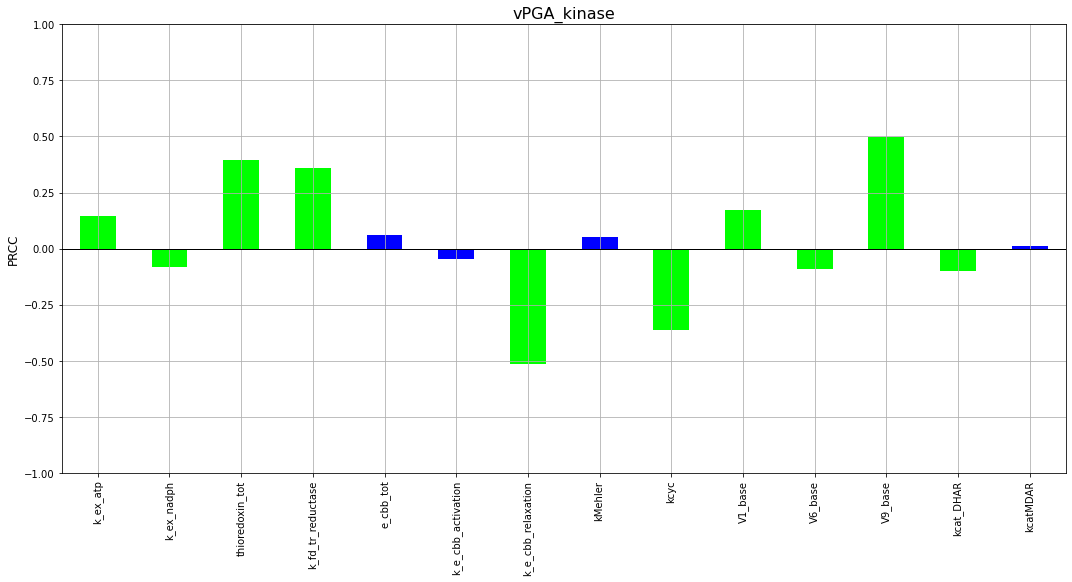

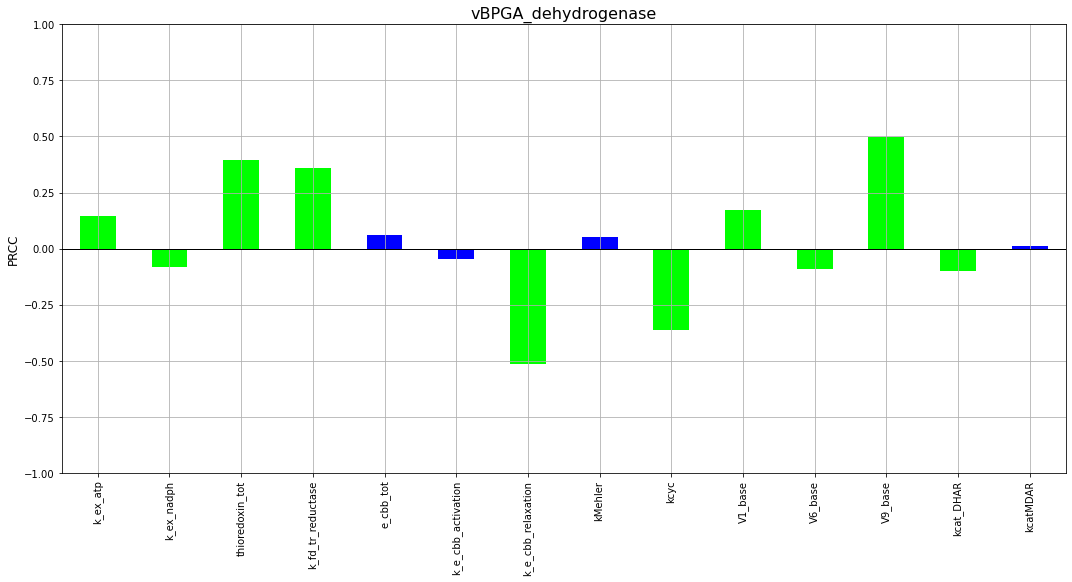

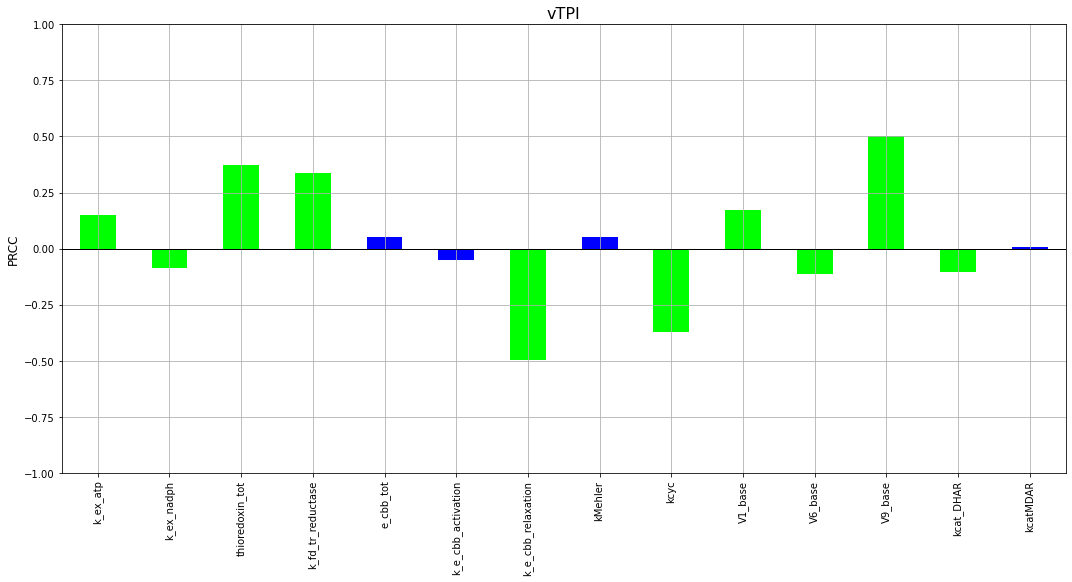

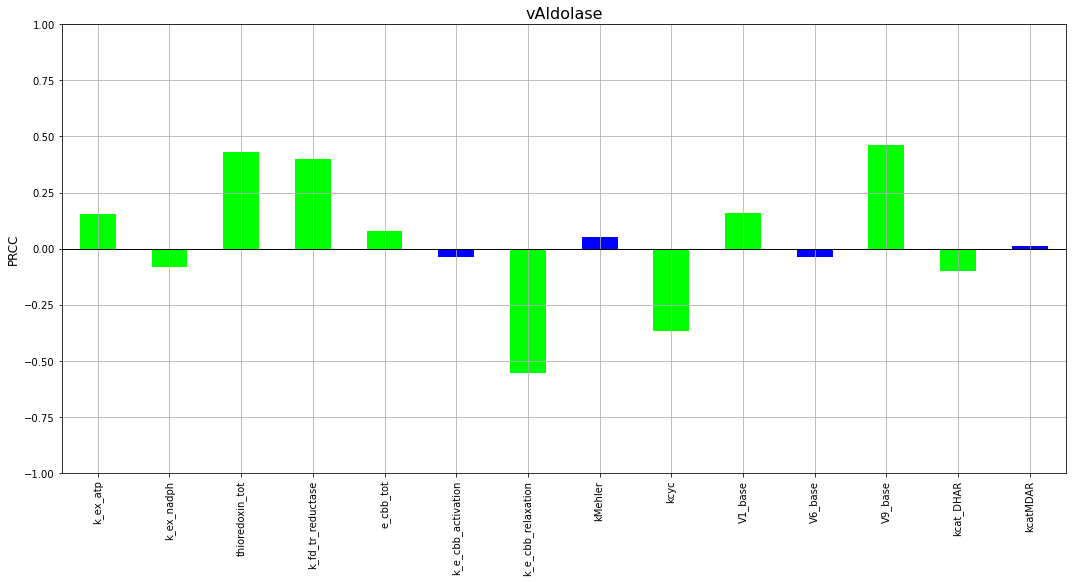

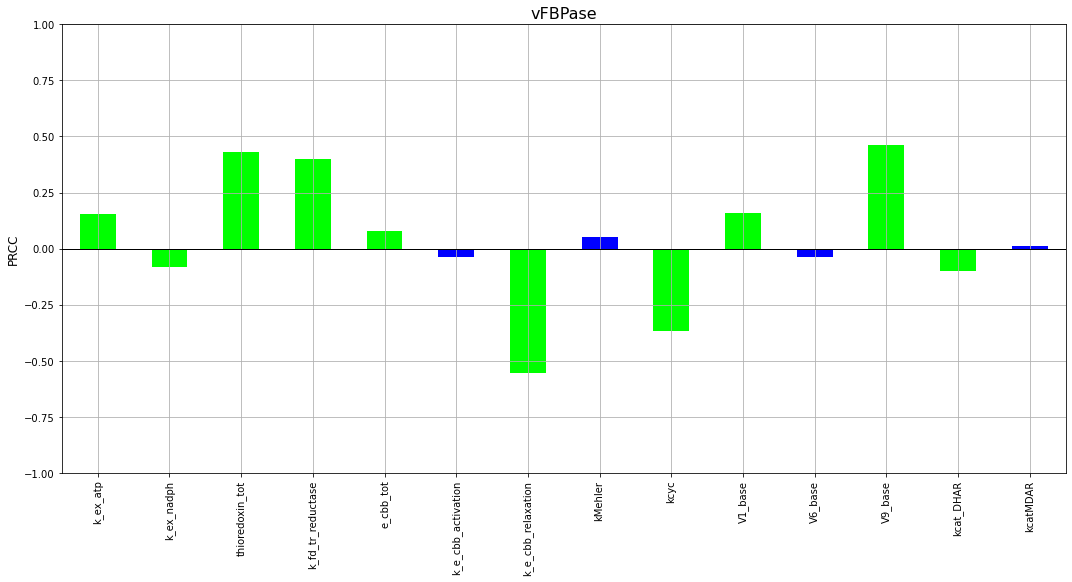

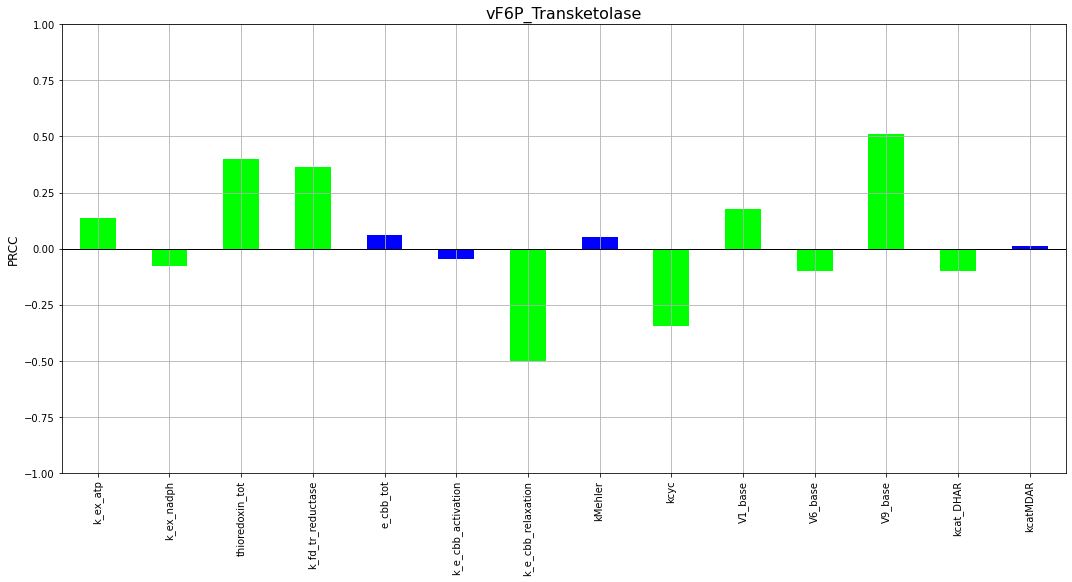

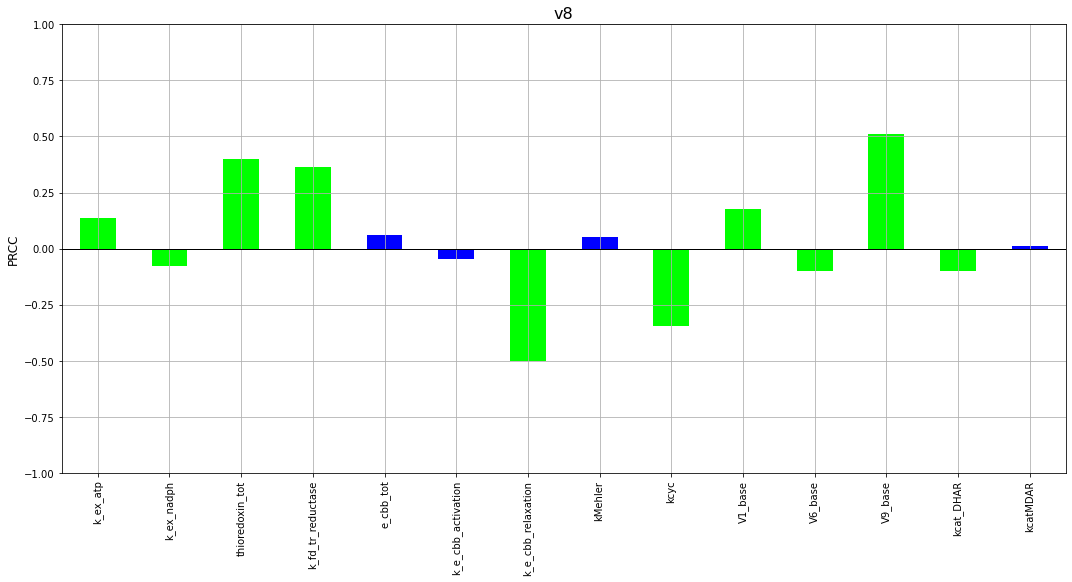

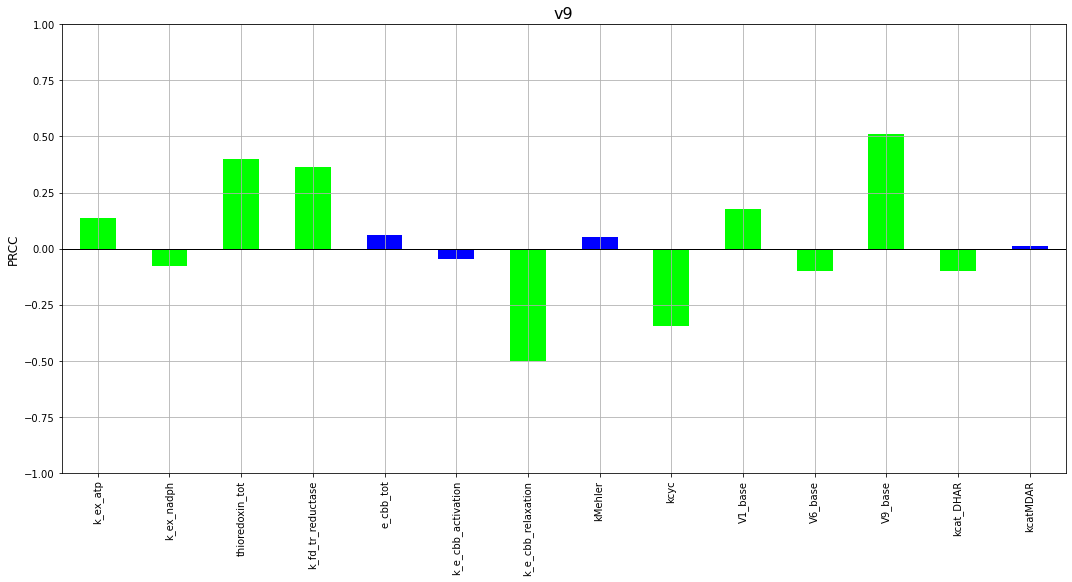

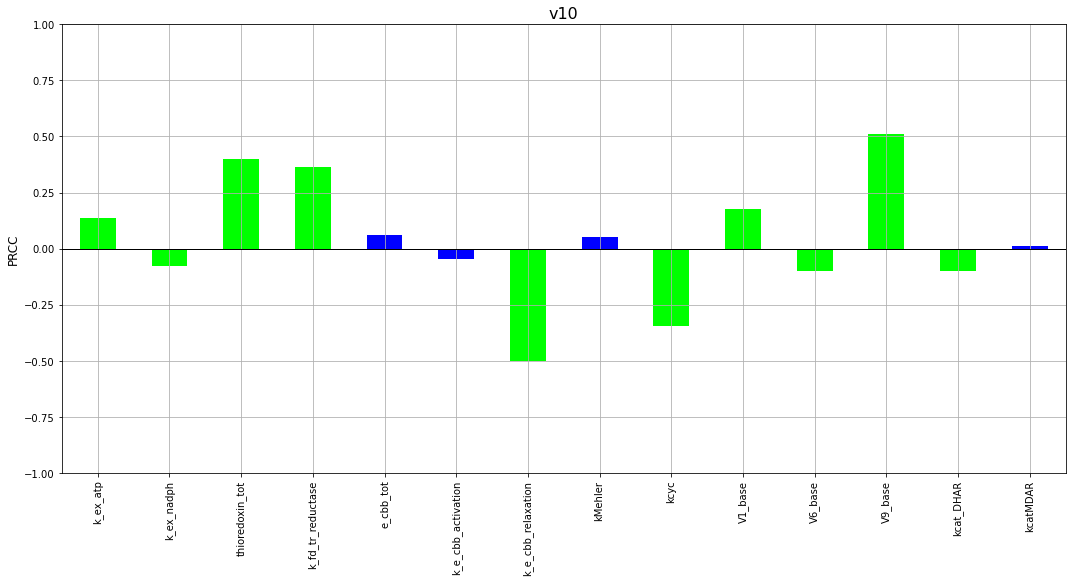

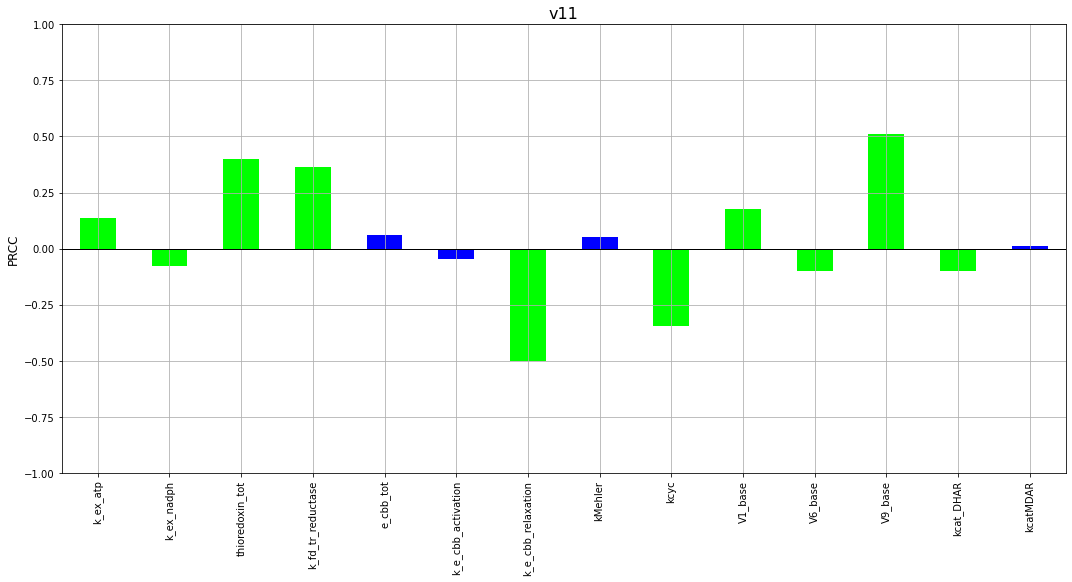

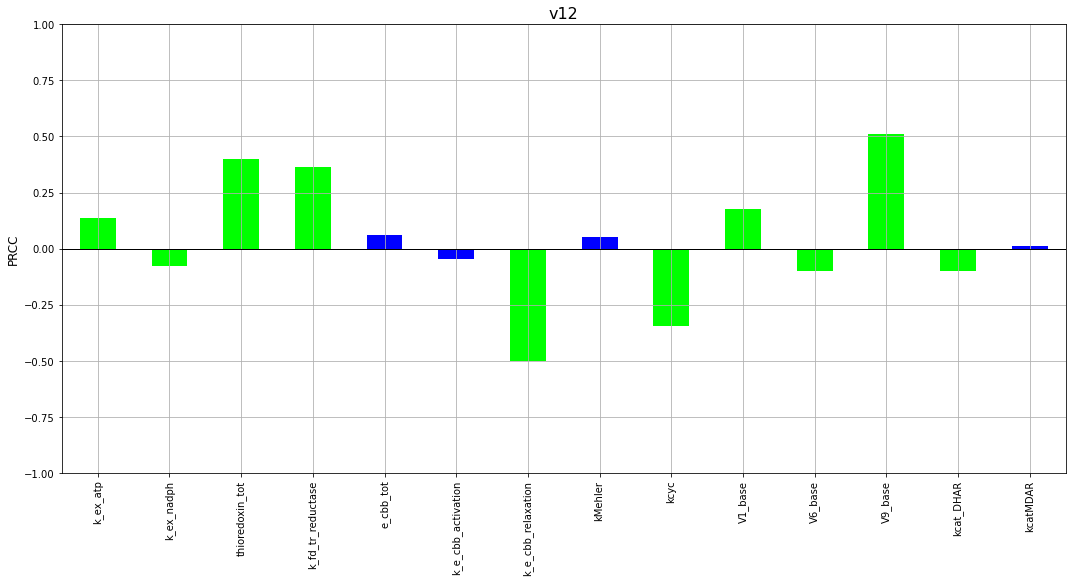

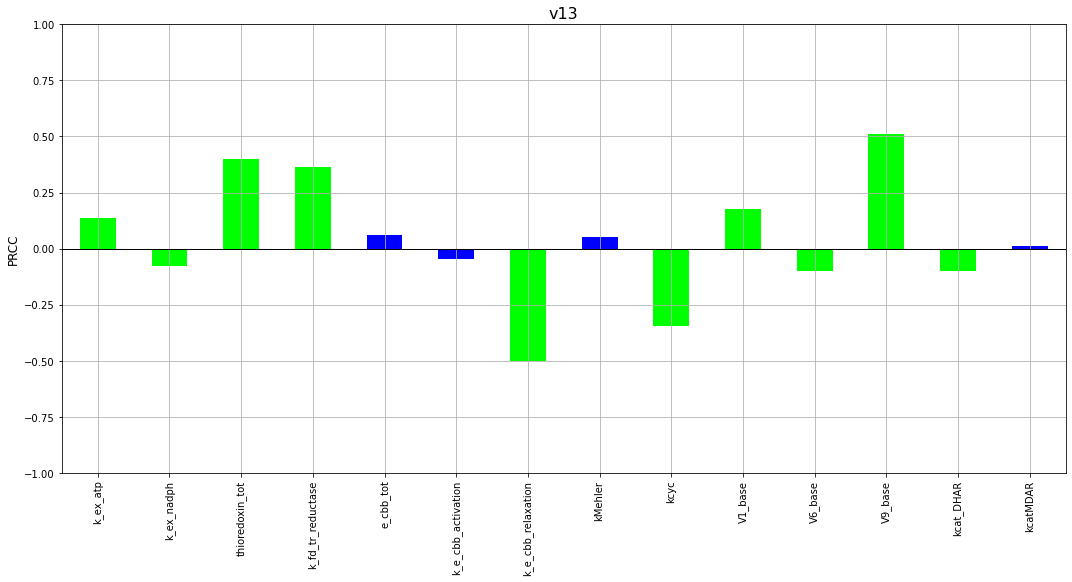

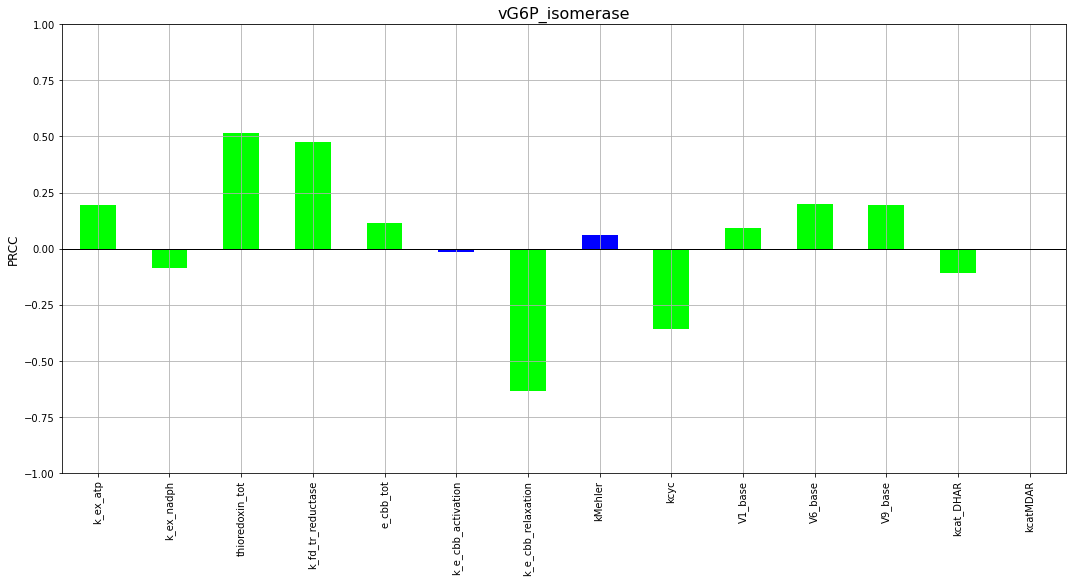

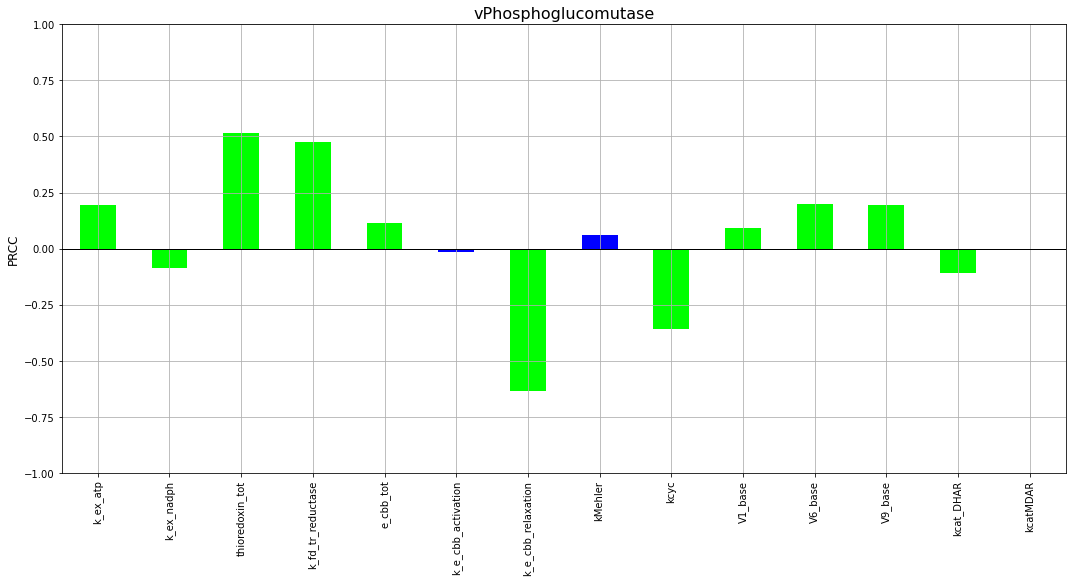

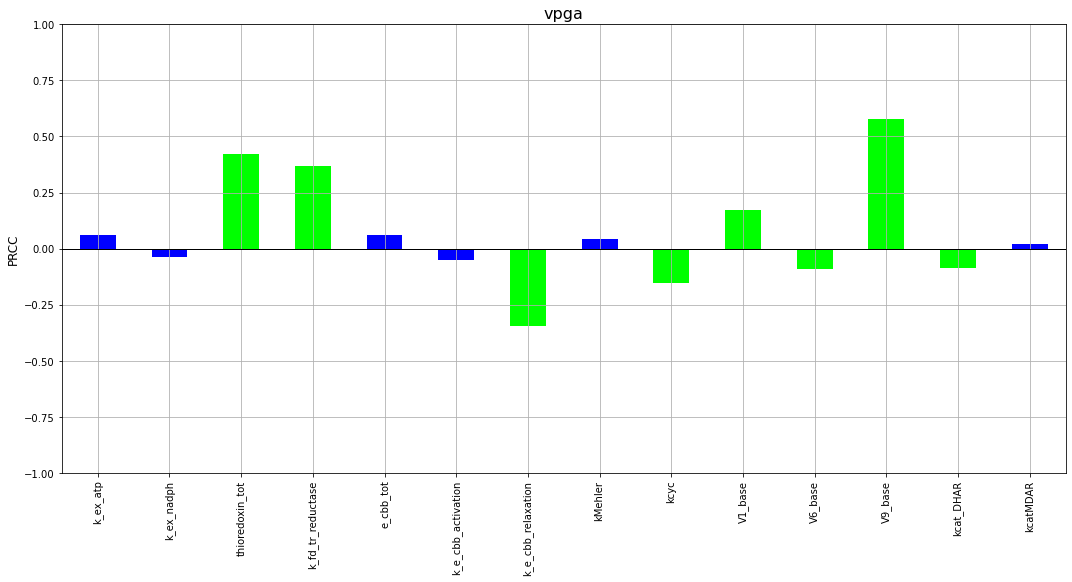

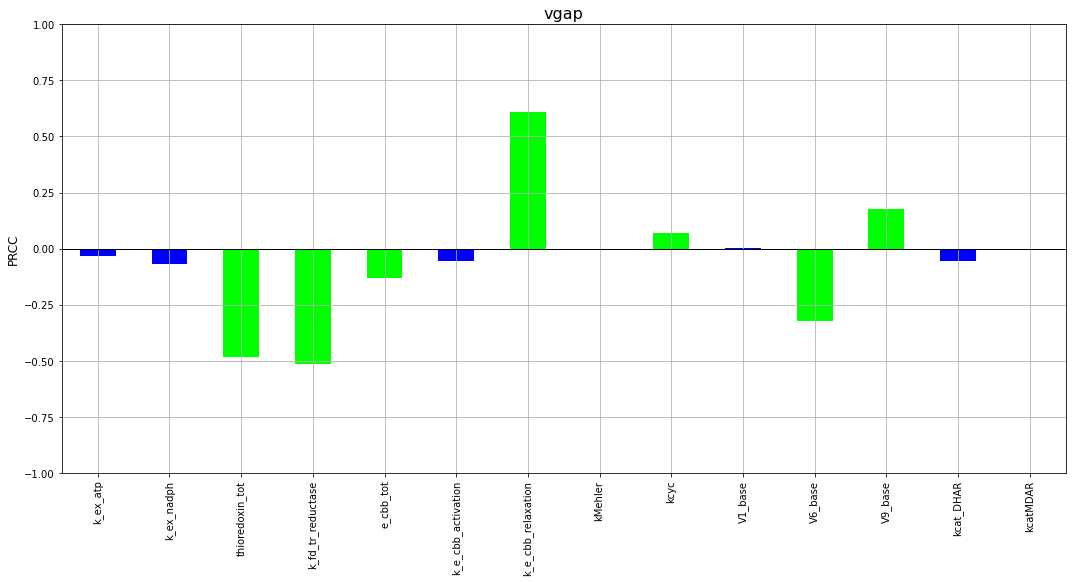

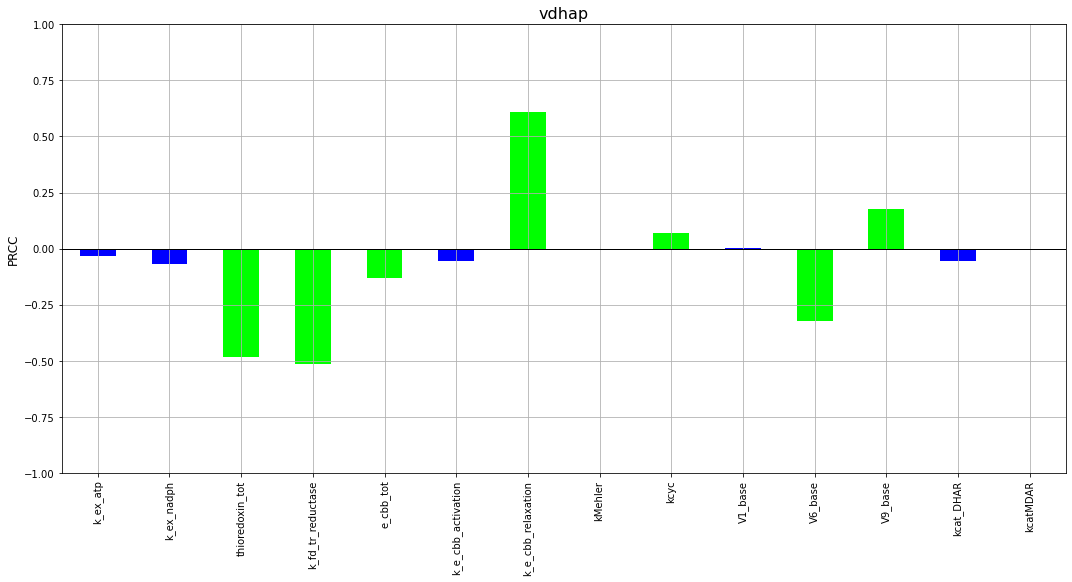

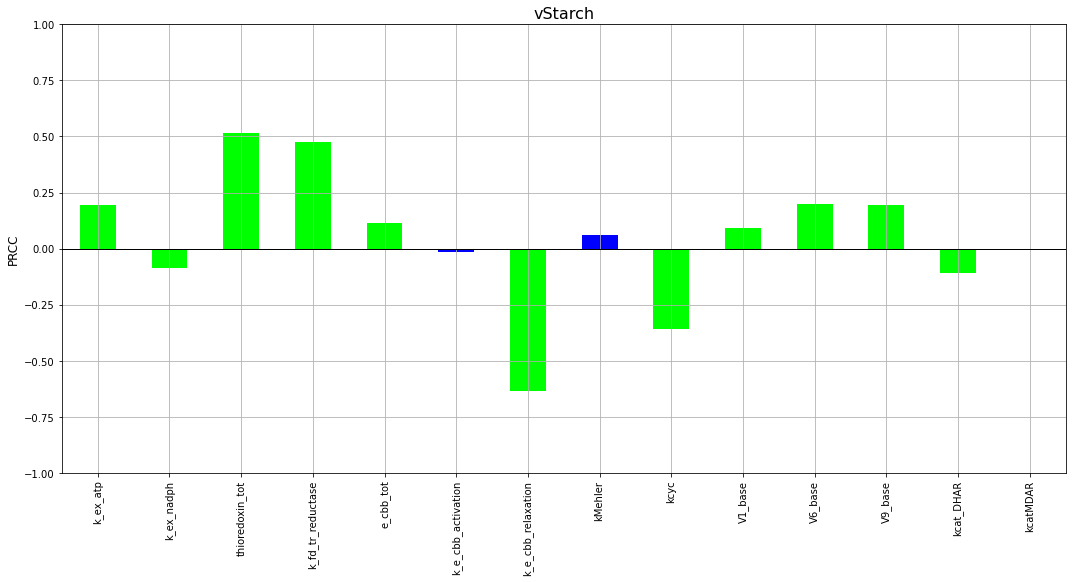

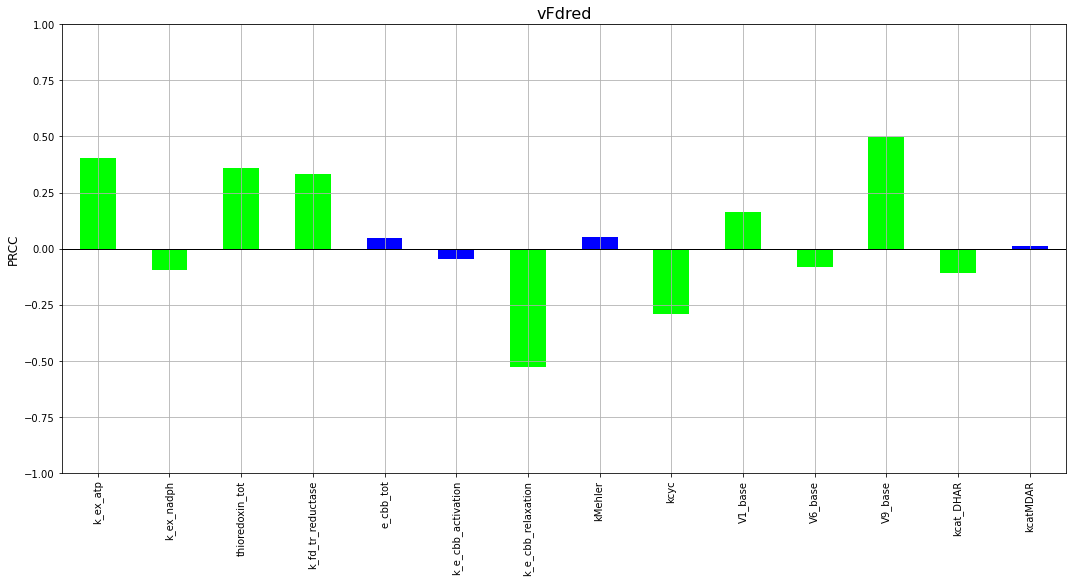

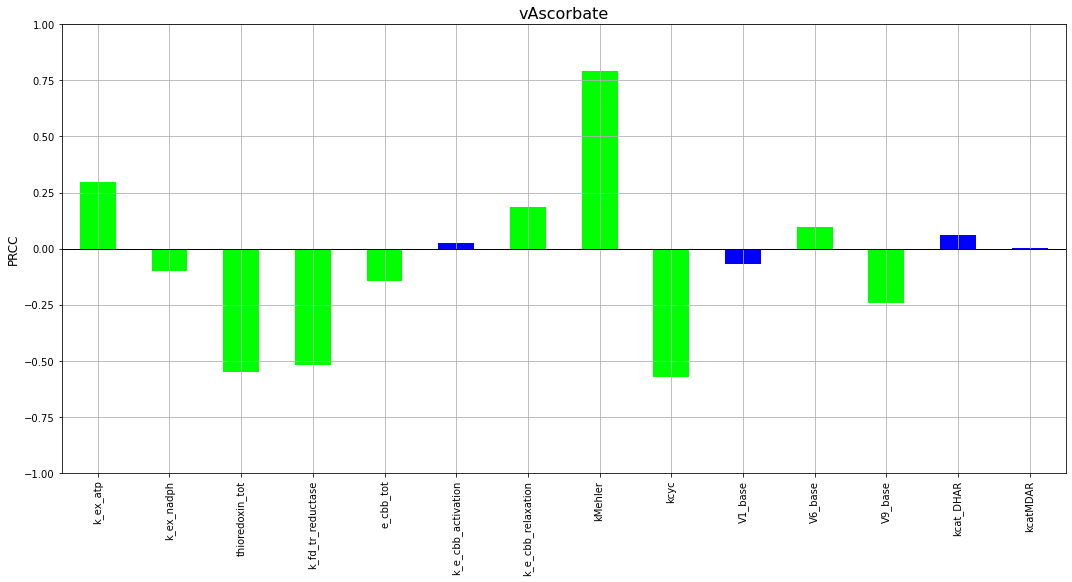

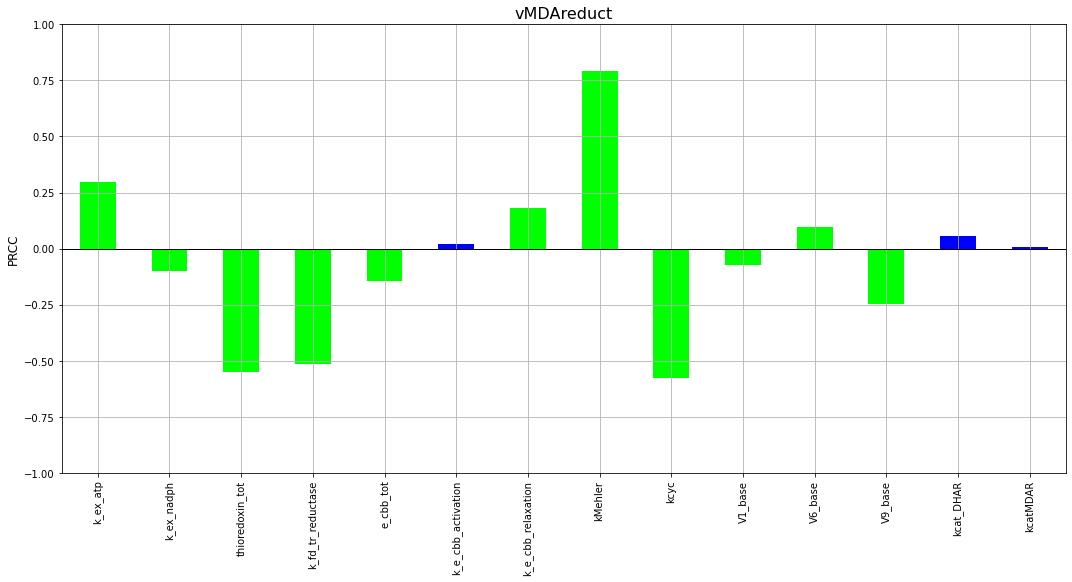

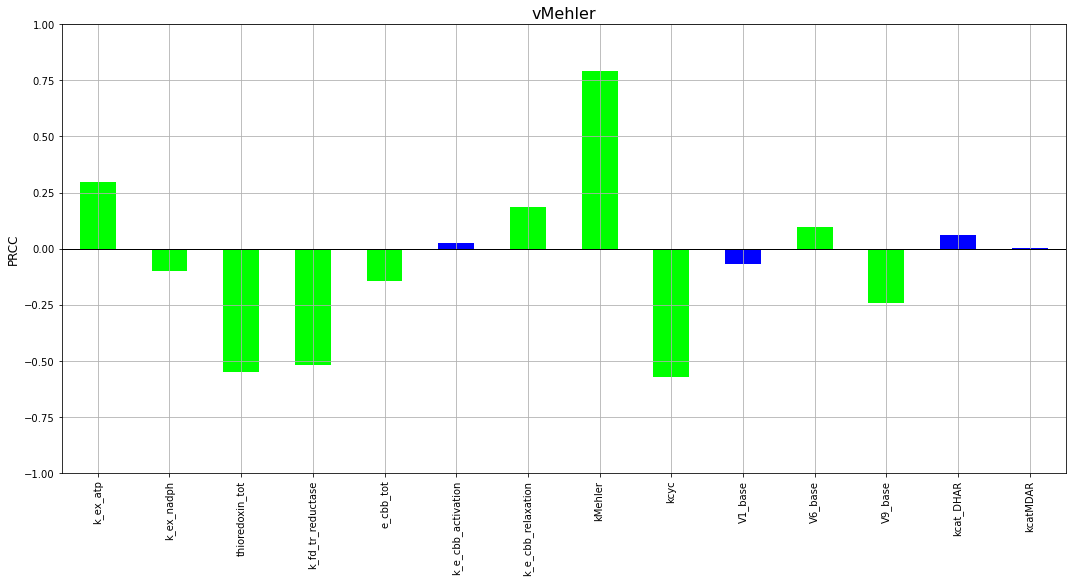

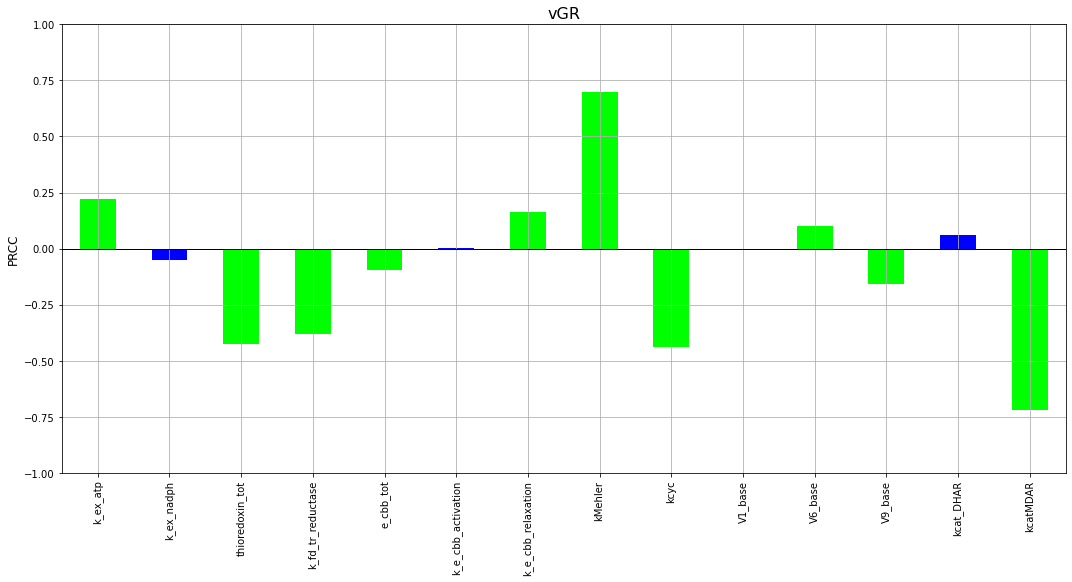

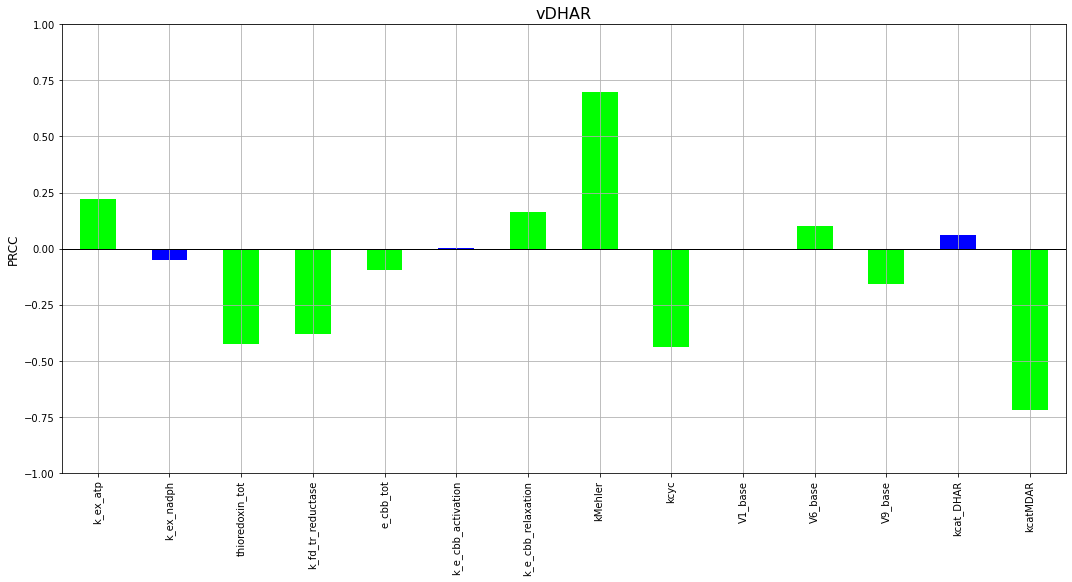

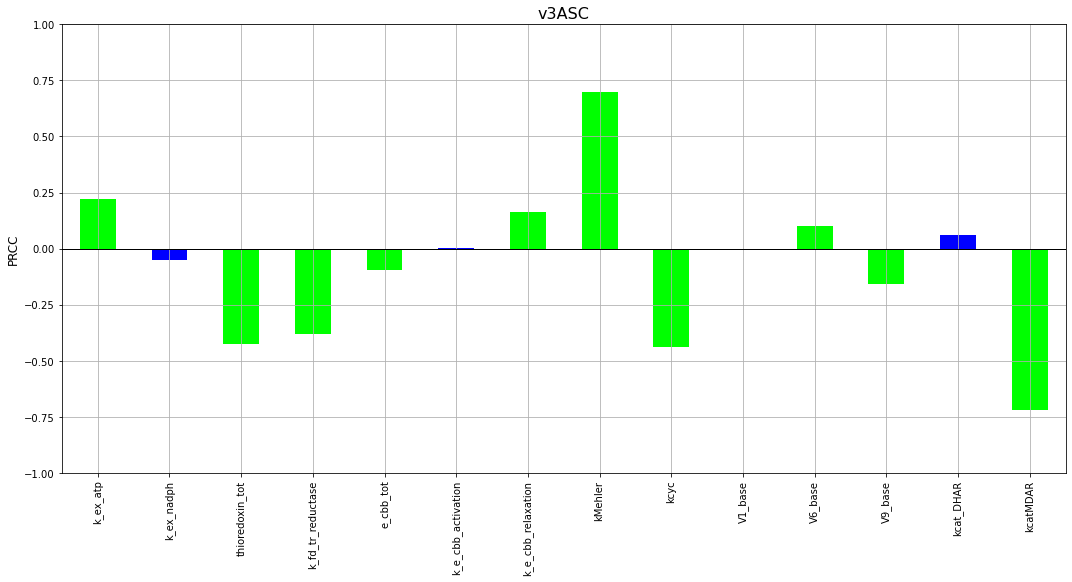

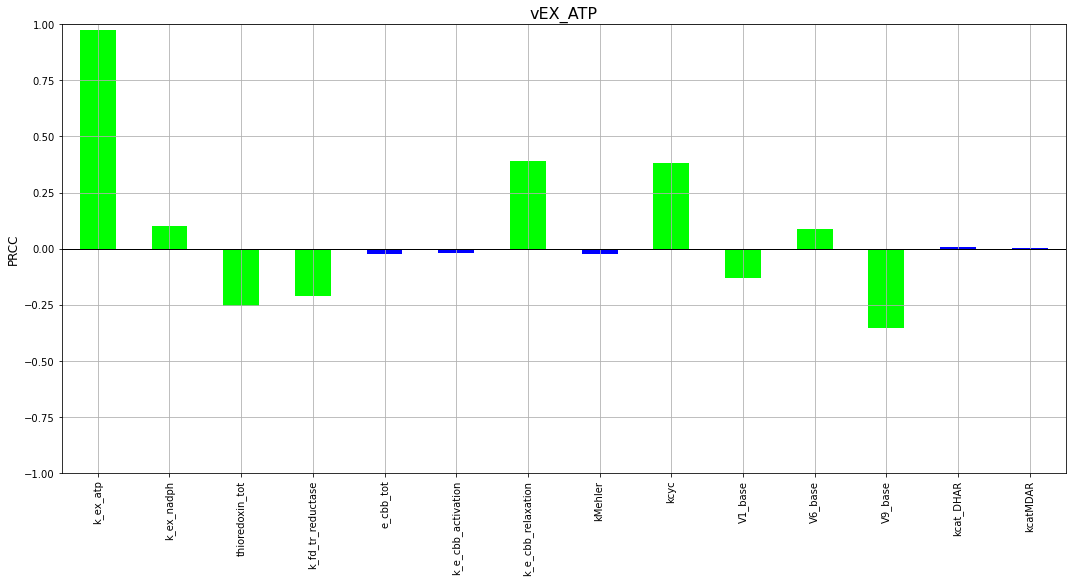

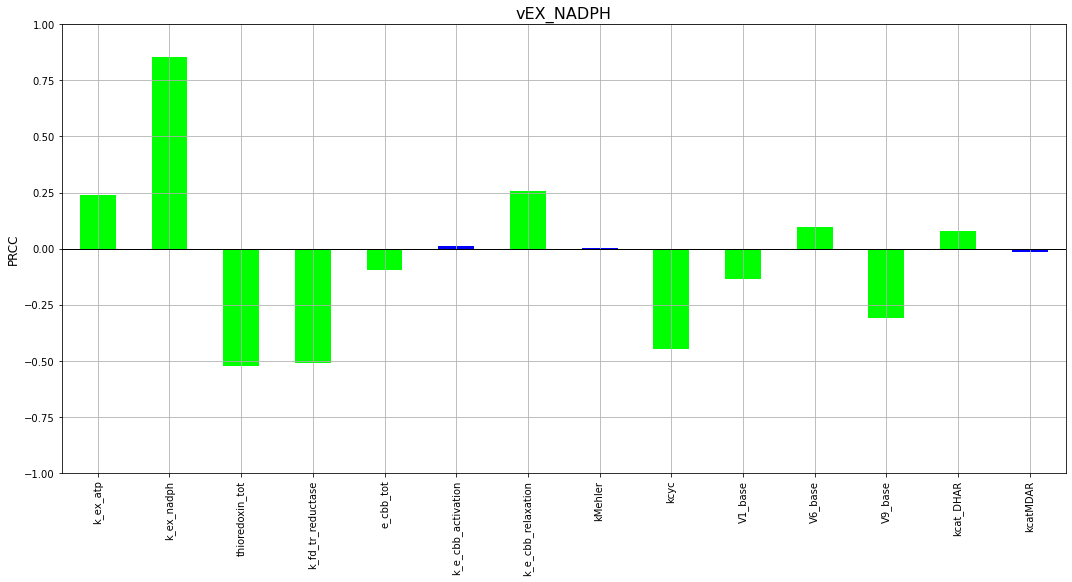

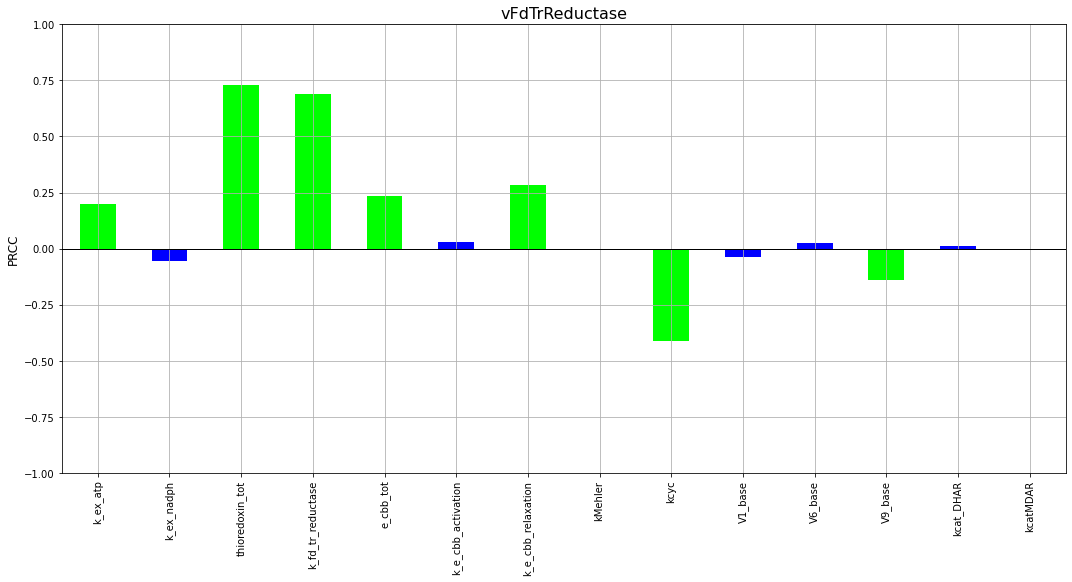

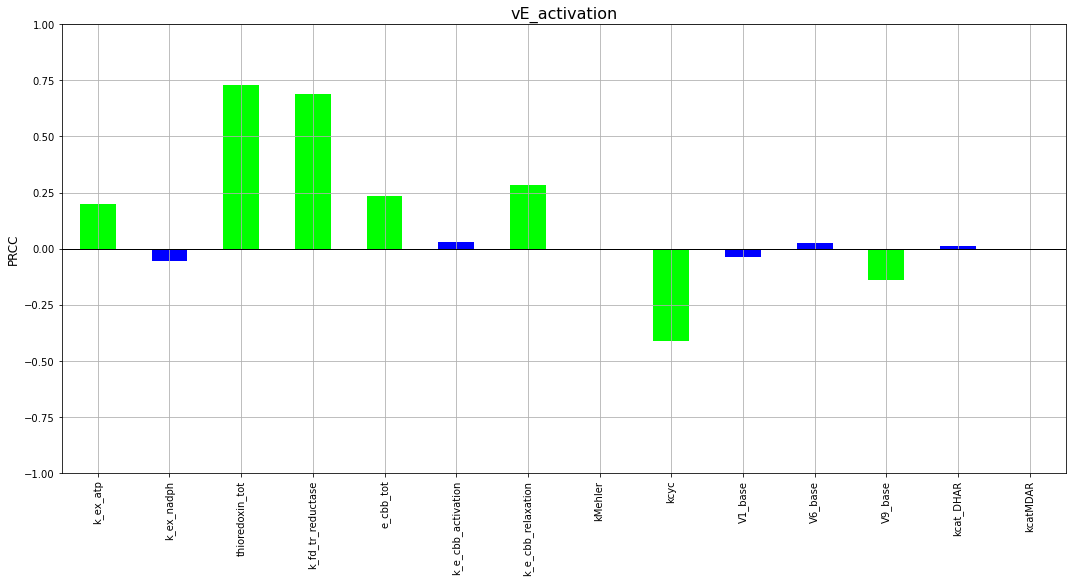

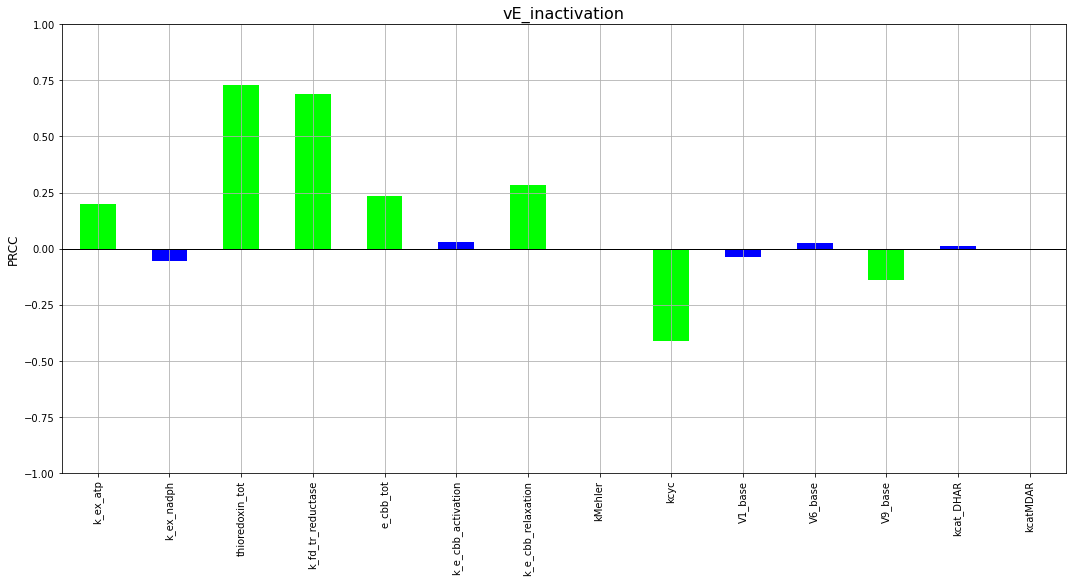

In [15]:
for i in output_matrix.columns:
    name = i
    out = PRCC(design_out_matrix,output_matrix,output_variable=name)
    fig,ax = plot_PCRR(out)
    ax.set_title(i)
    #fig.savefig('GSA_output/img/' + name + '.png')
    plt.show()
   # plot_residuals(out,name=name,save=True)

## Heatmap plot

In [17]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
        
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    

elev_min=-1
elev_max=1
mid_val=0


out_df = pd.DataFrame()
for i in output_matrix.columns:
    name = i
    out = PRCC(design_out_matrix,output_matrix,output_variable=name)
    df = pd.DataFrame(out).loc[['r']]
    df.index = [i]
    try:
        out_df = pd.concat([out_df,df])
    except:
        pass
        

In [18]:
compounds = s.model.compounds
fluxes = s.model.get_rate_names()

In [19]:
compounds_df = out_df.loc[compounds].astype(float)
fluxes_df = out_df.loc[fluxes].astype(float)

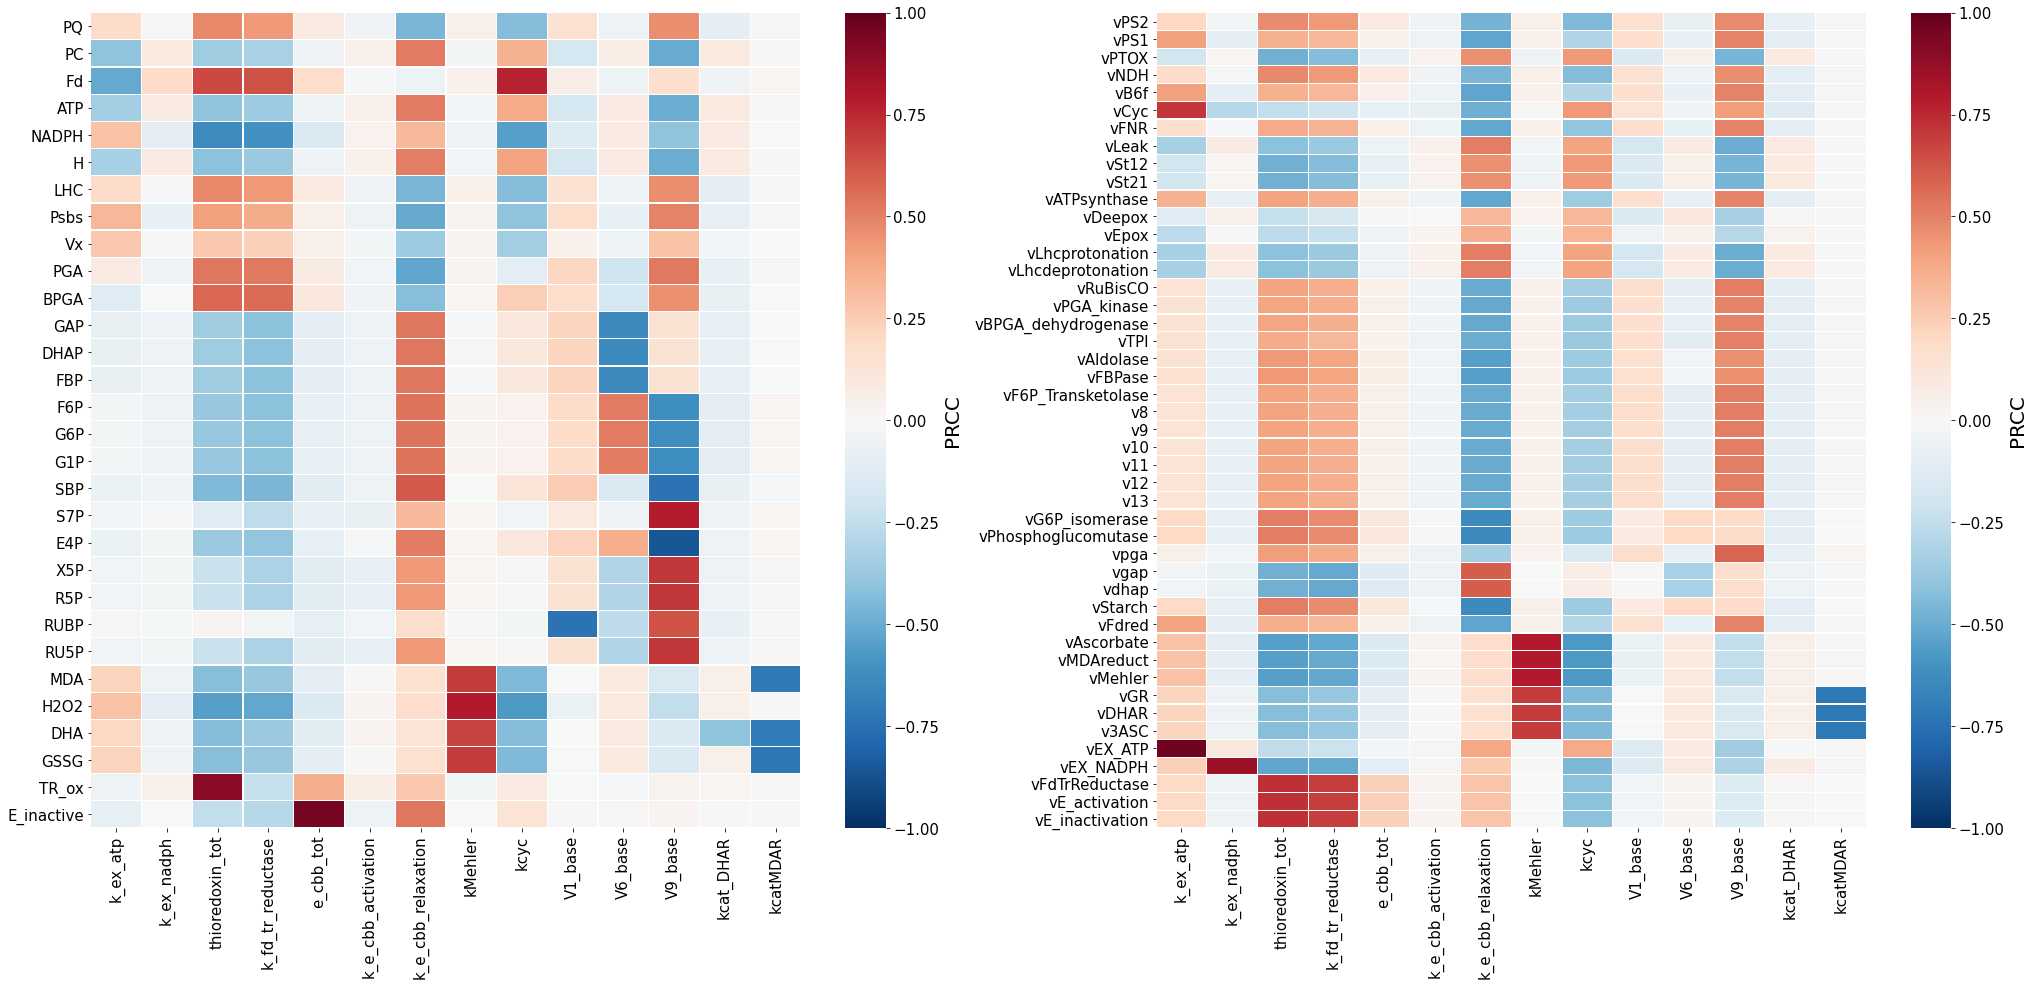

In [20]:
fig,ax = plt.subplots(1,2,figsize=(35,15))
sns.heatmap(compounds_df,cmap='RdBu_r',ax=ax[0],linewidth=0.2, norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[0].tick_params(labelsize=15)
ax[0].figure.axes[-1].set_ylabel('PRCC', size=20)
ax[0].figure.axes[-1].tick_params(labelsize=15)
sns.heatmap(fluxes_df,cmap='RdBu_r',ax=ax[1],linewidth=0.2, norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[1].tick_params(labelsize=15)
ax[1].figure.axes[-1].set_ylabel('PRCC', size=20)
ax[1].figure.axes[-1].tick_params(labelsize=15)
fig.savefig('lognorm_1000.png')